# **Zee Recommender System**

## A Comprehensive Movie Recommendation Engine

### Project Overview

This notebook implements a comprehensive movie recommender system using multiple approaches:
- **Collaborative Filtering** (Item-based & User-based)
- **Pearson Correlation** for similarity measurement
- **Cosine Similarity** with Nearest Neighbors
- **Matrix Factorization** for advanced recommendations

_____

## **1. Import Libraries and Setup**

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Statistics libraries
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

# Matrix Factorization libraries
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import cross_validate

# Utility libraries
from tqdm import tqdm
import time
import os

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


_____

## **2. Data Loading and Formatting**

The "Zee" project comprises three datasets:

- **ratings.dat**: User ratings (`UserID`::`MovieID`::`Rating`::`Timestamp`)

- **users.dat**: User demographics (`UserID`::`Gender`::`Age`::`Occupation`::`Zip-code`)

- **movies.dat**: Movie information (`MovieID`::`Title`::`Genres`)

In [2]:
def load_ratings_data(file_path='./data/ratings.dat'):
    """
    Load and format ratings data from ratings.dat file with comprehensive error handling
    
    Returns:
        pandas.DataFrame: Formatted ratings dataframe
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found")
        
        # Check if file is empty
        if os.path.getsize(file_path) == 0:
            raise ValueError(f"File {file_path} is empty")
        
        # Read the ratings file
        ratings = pd.read_csv(file_path, 
                            sep='::', 
                            engine='python',
                            skiprows=1,
                            names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
                            dtype={'UserID': 'Int64', 'MovieID': 'Int64', 'Rating': 'Int64', 'Timestamp': 'datetime64[s]'})
        
        # Validate data integrity
        if ratings.empty:
            raise ValueError("Loaded ratings data is empty")
        
        # Check for required columns
        required_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
        missing_columns = [col for col in required_columns if col not in ratings.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Validate rating range
        if not ratings['Rating'].between(1, 5).all():
            print("⚠️ Warning: Some ratings are outside the expected range (1-5)")
        
        # Check for duplicates
        duplicates = ratings.duplicated(subset=['UserID', 'MovieID', 'Timestamp']).sum()
        if duplicates > 0:
            print(f"⚠️ Warning: Found {duplicates} duplicate ratings")
        
        print(f"✅ Ratings data loaded successfully: {ratings.shape[0]:,} ratings")
        return ratings
    
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        return None
    except pd.errors.EmptyDataError:
        print("❌ The ratings file appears to be empty or corrupted")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error parsing ratings file: {e}")
        return None
    except ValueError as e:
        print(f"❌ Data validation error: {e}")
        return None
    except Exception as e:
        print(f"❌ Unexpected error loading ratings data: {e}")
        return None

In [3]:
def load_users_data(file_path='data/users.dat'):
    """
    Load and format users data from users.dat file with comprehensive error handling
    
    Returns:
        pandas.DataFrame: Formatted users dataframe
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found")
        
        # Check if file is empty
        if os.path.getsize(file_path) == 0:
            raise ValueError(f"File {file_path} is empty")
        
        # Read the users file
        users = pd.read_csv(file_path, 
                          sep='::', 
                          engine='python',
                          skiprows=1,
                          names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],
                          dtype={'UserID': 'Int64', 'Gender': str, 'Age': 'Int64', 'Occupation': 'Int64', 'Zip-code': str})
        
        # Validate data integrity
        if users.empty:
            raise ValueError("Loaded users data is empty")
        
        # Check for required columns
        required_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
        missing_columns = [col for col in required_columns if col not in users.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Create age group mappings
        age_mapping = {
            1: "Under 18",
            18: "18-24",
            25: "25-34",
            35: "35-44",
            45: "45-49",
            50: "50-55",
            56: "56+"
        }
        
        # Create occupation mappings
        occupation_mapping = {
            0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
            4: "college/grad student", 5: "customer service", 6: "doctor/health care",
            7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student",
            11: "lawyer", 12: "programmer", 13: "retired", 14: "sales/marketing",
            15: "scientist", 16: "self-employed", 17: "technician/engineer",
            18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
        }
        
        # Apply mappings with error handling
        try:
            users['AgeGroup'] = users['Age'].map(age_mapping)
            users['OccupationName'] = users['Occupation'].map(occupation_mapping)
            
            # Check for unmapped values
            unmapped_ages = users['AgeGroup'].isna().sum()
            unmapped_occupations = users['OccupationName'].isna().sum()
            
            if unmapped_ages > 0:
                print(f"⚠️ Warning: {unmapped_ages} users have unmapped age values")
            if unmapped_occupations > 0:
                print(f"⚠️ Warning: {unmapped_occupations} users have unmapped occupation values")
                
        except Exception as e:
            print(f"⚠️ Warning: Error applying mappings: {e}")
        
        print(f"✅ Users data loaded successfully: {users.shape[0]:,} users")
        return users
    
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        return None
    except pd.errors.EmptyDataError:
        print("❌ The users file appears to be empty or corrupted")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error parsing users file: {e}")
        return None
    except ValueError as e:
        print(f"❌ Data validation error: {e}")
        return None
    except Exception as e:
        print(f"❌ Unexpected error loading users data: {e}")
        return None

In [4]:
def load_movies_data(file_path='data/movies.dat'):
    """
    Load and format movies data from movies.dat file with comprehensive error handling
    
    Returns:
        pandas.DataFrame: Formatted movies dataframe
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found")
        
        # Check if file is empty
        if os.path.getsize(file_path) == 0:
            raise ValueError(f"File {file_path} is empty")
        
        # Try different encodings
        encodings = ['latin-1', 'utf-8', 'iso-8859-1', 'cp1252']
        movies = None
        
        for encoding in encodings:
            try:
                movies = pd.read_csv(file_path, 
                                   sep='::', 
                                   engine='python',
                                   skiprows=1,
                                   names=['MovieID', 'Title', 'Genres'],
                                   dtype={'MovieID': 'Int64', 'Title': str, 'Genres': str},
                                   encoding=encoding)
                print(f"✅ Successfully loaded movies data using {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
        
        if movies is None:
            raise ValueError("Could not load movies data with any supported encoding")
        
        # Validate data integrity
        if movies.empty:
            raise ValueError("Loaded movies data is empty")
        
        # Check for required columns
        required_columns = ['MovieID', 'Title', 'Genres']
        missing_columns = [col for col in required_columns if col not in movies.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Extract year from title with error handling
        try:
            movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)').astype('Int64')
            movies['Title'] = movies['Title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)
            
            # Check for movies without years
            no_year_count = movies['Year'].isna().sum()
            if no_year_count > 0:
                print(f"⚠️ Warning: {no_year_count} movies do not have extractable years")
                
        except Exception as e:
            print(f"⚠️ Warning: Error extracting years from titles: {e}")
            movies['Year'] = None
        
        # Split genres into lists with error handling
        try:
            movies['GenresList'] = movies['Genres'].str.split('|')
            
            # Check for movies without genres
            no_genre_count = movies['Genres'].isna().sum()
            if no_genre_count > 0:
                print(f"⚠️ Warning: {no_genre_count} movies do not have genre information")
                
        except Exception as e:
            print(f"⚠️ Warning: Error processing genres: {e}")
            movies['GenresList'] = movies['Genres'].apply(lambda x: [x] if pd.notna(x) else [])
        
        print(f"✅ Movies data loaded successfully: {movies.shape[0]:,} movies")
        return movies
    
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        return None
    except pd.errors.EmptyDataError:
        print("❌ The movies file appears to be empty or corrupted")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error parsing movies file: {e}")
        return None
    except ValueError as e:
        print(f"❌ Data validation error: {e}")
        return None
    except Exception as e:
        print(f"❌ Unexpected error loading movies data: {e}")
        return None

In [5]:
# Load all datasets with enhanced error handling
print("Loading given dataset with comprehensive error handling...")
print("=" * 60)

ratings_df = load_ratings_data()
ratings_df = ratings_df[['UserID', 'MovieID', 'Rating', 'Timestamp']]

users_df = load_users_data()
users_df = users_df[['UserID', 'Gender', 'AgeGroup', 'OccupationName']]

movies_df = load_movies_data()
movies_df = movies_df[['MovieID', 'Title', 'Year', 'GenresList']]

print("\n📊 Dataset Summary:")
if ratings_df is not None:
    print(f"   • Ratings: {ratings_df.shape[0]:,} records")
if users_df is not None:
    print(f"   • Users: {users_df.shape[0]:,} records")
if movies_df is not None:
    print(f"   • Movies: {movies_df.shape[0]:,} records")

# Data integrity check
print("\n🔍 Data Integrity Check:")
if all(df is not None for df in [ratings_df, users_df, movies_df]):
    print("✅ All datasets loaded successfully")
    
    # Check for consistency between datasets
    unique_users_ratings = ratings_df['UserID'].nunique()
    unique_users_users = users_df['UserID'].nunique()
    unique_movies_ratings = ratings_df['MovieID'].nunique()
    unique_movies_movies = movies_df['MovieID'].nunique()
    
    print(f"   • Users in ratings: {unique_users_ratings:,}")
    print(f"   • Users in users file: {unique_users_users:,}")
    print(f"   • Movies in ratings: {unique_movies_ratings:,}")
    print(f"   • Movies in movies file: {unique_movies_movies:,}")
    
    if unique_users_ratings != unique_users_users:
        print(f"\n⚠️ Warning: User count mismatch between files")
    if unique_movies_ratings != unique_movies_movies:
        print(f"\n⚠️ Warning: Movie count mismatch between files")
else:
    print("\n❌ Some datasets failed to load")

Loading given dataset with comprehensive error handling...
✅ Ratings data loaded successfully: 1,000,209 ratings
✅ Users data loaded successfully: 6,040 users
✅ Successfully loaded movies data using latin-1 encoding
✅ Movies data loaded successfully: 3,883 movies

📊 Dataset Summary:
   • Ratings: 1,000,209 records
   • Users: 6,040 records
   • Movies: 3,883 records

🔍 Data Integrity Check:
✅ All datasets loaded successfully
   • Users in ratings: 6,040
   • Users in users file: 6,040
   • Movies in ratings: 3,706
   • Movies in movies file: 3,883

⚠️ Warning: Movie count mismatch between files


### Data Preview and Merging

Let's examine the structure of our loaded datasets and create a consolidated dataframe:

In [6]:
# Display basic information about each dataset
if ratings_df is not None:
    print("="*30)
    print("🎬 RATINGS DATASET")
    print("=" * 30)
    print(f"Shape: {ratings_df.shape}")
    print(f"Columns: {list(ratings_df.columns)}")
    display(ratings_df)
    print("Data types:")
    print(ratings_df.dtypes)

🎬 RATINGS DATASET
Shape: (1000209, 4)
Columns: ['UserID', 'MovieID', 'Rating', 'Timestamp']


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


Data types:
UserID               Int64
MovieID              Int64
Rating               Int64
Timestamp    datetime64[s]
dtype: object


In [7]:
if users_df is not None:
    print("="*30)
    print("👥 USERS DATASET")
    print("=" * 30)
    print(f"Shape: {users_df.shape}")
    print(f"Columns: {list(users_df.columns)}")
    display(users_df)
    print("Data types:")
    print(users_df.dtypes)

👥 USERS DATASET
Shape: (6040, 4)
Columns: ['UserID', 'Gender', 'AgeGroup', 'OccupationName']


,UserID,Gender,AgeGroup,OccupationName
0,1,F,Under 18,K-12 student
1,2,M,56+,self-employed
2,3,M,25-34,scientist
3,4,M,45-49,executive/managerial
4,5,M,25-34,writer
...,...,...,...,...
6035,6036,F,25-34,scientist
6036,6037,F,45-49,academic/educator
6037,6038,F,56+,academic/educator
6038,6039,F,45-49,other


Data types:
UserID             Int64
Gender            object
AgeGroup          object
OccupationName    object
dtype: object


In [8]:
if movies_df is not None:
    print("="*30)
    print("🎭 MOVIES DATASET")
    print("=" * 30)
    print(f"Shape: {movies_df.shape}")
    print(f"Columns: {list(movies_df.columns)}")
    display(movies_df)
    print("Data types:")
    print(movies_df.dtypes)

🎭 MOVIES DATASET
Shape: (3883, 4)
Columns: ['MovieID', 'Title', 'Year', 'GenresList']


,MovieID,Title,Year,GenresList
0,1,Toy Story,1995,"[Animation, Children's, Comedy]"
1,2,Jumanji,1995,"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale,1995,"[Comedy, Drama]"
4,5,Father of the Bride Part II,1995,[Comedy]
...,...,...,...,...
3878,3948,Meet the Parents,2000,[Comedy]
3879,3949,Requiem for a Dream,2000,[Drama]
3880,3950,Tigerland,2000,[Drama]
3881,3951,Two Family House,2000,[Drama]


Data types:
MovieID        Int64
Title         object
Year           Int64
GenresList    object
dtype: object


In [9]:
def create_consolidated_dataframe(ratings_df, users_df, movies_df):
    """
    Merge all three datasets into a single consolidated dataframe
    
    Args:
        ratings_df: Ratings dataframe
        users_df: Users dataframe
        movies_df: Movies dataframe
    
    Returns:
        pandas.DataFrame: Consolidated dataframe
    """
    if any(df is None for df in [ratings_df, users_df, movies_df]):
        print("❌ Cannot create consolidated dataframe - some datasets are missing")
        return None
    
    print("🔄 Merging datasets...")
    
    # Start with ratings as the base
    consolidated = ratings_df.copy()
    
    # Merge with users data
    consolidated = consolidated.merge(users_df, on='UserID', how='left')
    print(f"   ✓ Merged with users data: {consolidated.shape}")
    
    # Merge with movies data
    consolidated = consolidated.merge(movies_df, on='MovieID', how='left')
    print(f"   ✓ Merged with movies data: {consolidated.shape}")
    
    # Add some derived features
    if 'Timestamp' in consolidated.columns and pd.api.types.is_datetime64_any_dtype(consolidated['Timestamp']):
        consolidated['Rating_Date'] = consolidated['Timestamp'].dt.date
        consolidated['Rating_Year'] = consolidated['Timestamp'].dt.year
        consolidated['Rating_Month'] = consolidated['Timestamp'].dt.month
    
    return consolidated

In [10]:
# Create consolidated dataframe
df = create_consolidated_dataframe(ratings_df, users_df, movies_df)

if df is not None:
    print("\n📋 CONSOLIDATED DATASET OVERVIEW")
    print("=" * 40)
    print(f"Total records: {df.shape[0]:,}")
    print(f"Total columns: {df.shape[1]}")
    
    display(df)
    
    print("Dataset Info:")
    display(df.info())

🔄 Merging datasets...
   ✓ Merged with users data: (1000209, 7)
   ✓ Merged with movies data: (1000209, 10)

📋 CONSOLIDATED DATASET OVERVIEW
Total records: 1,000,209
Total columns: 13


,UserID,MovieID,Rating,Timestamp,Gender,AgeGroup,OccupationName,Title,Year,GenresList,Rating_Date,Rating_Year,Rating_Month
0,1,1193,5,2000-12-31 22:12:40,F,Under 18,K-12 student,One Flew Over the Cuckoo's Nest,1975,[Drama],2000-12-31,2000,12
1,1,661,3,2000-12-31 22:35:09,F,Under 18,K-12 student,James and the Giant Peach,1996,"[Animation, Children's, Musical]",2000-12-31,2000,12
2,1,914,3,2000-12-31 22:32:48,F,Under 18,K-12 student,My Fair Lady,1964,"[Musical, Romance]",2000-12-31,2000,12
3,1,3408,4,2000-12-31 22:04:35,F,Under 18,K-12 student,Erin Brockovich,2000,[Drama],2000-12-31,2000,12
4,1,2355,5,2001-01-06 23:38:11,F,Under 18,K-12 student,"Bug's Life, A",1998,"[Animation, Children's, Comedy]",2001-01-06,2001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41,M,25-34,doctor/health care,Weekend at Bernie's,1989,[Comedy],2000-04-26,2000,4
1000205,6040,1094,5,2000-04-25 23:21:27,M,25-34,doctor/health care,"Crying Game, The",1992,"[Drama, Romance, War]",2000-04-25,2000,4
1000206,6040,562,5,2000-04-25 23:19:06,M,25-34,doctor/health care,Welcome to the Dollhouse,1995,"[Comedy, Drama]",2000-04-25,2000,4
1000207,6040,1096,4,2000-04-26 02:20:48,M,25-34,doctor/health care,Sophie's Choice,1982,[Drama],2000-04-26,2000,4


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype        
---  ------          --------------    -----        
 0   UserID          1000209 non-null  Int64        
 1   MovieID         1000209 non-null  Int64        
 2   Rating          1000209 non-null  Int64        
 3   Timestamp       1000209 non-null  datetime64[s]
 4   Gender          1000209 non-null  object       
 5   AgeGroup        1000209 non-null  object       
 6   OccupationName  1000209 non-null  object       
 7   Title           1000209 non-null  object       
 8   Year            1000209 non-null  Int64        
 9   GenresList      1000209 non-null  object       
 10  Rating_Date     1000209 non-null  object       
 11  Rating_Year     1000209 non-null  int32        
 12  Rating_Month    1000209 non-null  int32        
dtypes: Int64(4), datetime64[s](1), int32(2), object(6)
memory usage: 95.4+ MB

None

In [11]:
# Experiment config (shared samples across all algorithms)
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

N_SAMPLE_USERS = 5
N_SAMPLE_ITEMS = 5

# Deterministic samples from the full dataset
SAMPLE_USER_IDS = (
    df[['UserID']].drop_duplicates()
      .sample(n=min(N_SAMPLE_USERS, df['UserID'].nunique()), random_state=RANDOM_STATE)['UserID']
      .astype(int)
      .tolist()
)

SAMPLE_ITEM_IDS = (
    df[['MovieID']].drop_duplicates()
      .sample(n=min(N_SAMPLE_ITEMS, df['MovieID'].nunique()), random_state=RANDOM_STATE)['MovieID']
      .astype(int)
      .tolist()
)

print("🧪 EXPERIMENT CONFIG")
print("=" * 40)
print(f"SAMPLE_USER_IDS ({len(SAMPLE_USER_IDS)}): {SAMPLE_USER_IDS}")
print(f"SAMPLE_ITEM_IDS ({len(SAMPLE_ITEM_IDS)}): {SAMPLE_ITEM_IDS}")

🧪 EXPERIMENT CONFIG
SAMPLE_USER_IDS (5): [5530, 711, 4924, 2154, 1273]
SAMPLE_ITEM_IDS (5): [2618, 3633, 3811, 216, 3396]


_____

## **3. Exploratory Data Analysis (EDA)**

In [12]:
if df is None:
    print("❌ No data available for analysis")
    exit()

print("📊 COMPREHENSIVE DATASET STATISTICS")
print("=" * 50)

# Basic statistics
print(f"Total ratings: {df.shape[0]:,}")
print(f"Unique users: {df['UserID'].nunique():,}")
print(f"Unique movies: {df['MovieID'].nunique():,}")
print(f"Rating range: {df['Rating'].min()} - {df['Rating'].max()}")
print(f"Average rating: {df['Rating'].mean():.3f}")
print(f"Median rating: {df['Rating'].median():.1f}")
print(f"Rating standard deviation: {df['Rating'].std():.3f}")
print(f"Rating variance: {df['Rating'].var():.3f}")

# Sparsity calculation
total_possible_ratings = df['UserID'].nunique() * df['MovieID'].nunique()
actual_ratings = len(df)
sparsity = (1 - (actual_ratings / total_possible_ratings)) * 100
print(f"\n🔍 SPARSITY ANALYSIS")
print(f"Total possible ratings: {total_possible_ratings:,}")
print(f"Actual ratings: {actual_ratings:,}")
print(f"Data sparsity: {sparsity:.2f}%")

📊 COMPREHENSIVE DATASET STATISTICS
Total ratings: 1,000,209
Unique users: 6,040
Unique movies: 3,706
Rating range: 1 - 5
Average rating: 3.582
Median rating: 4.0
Rating standard deviation: 1.117
Rating variance: 1.248

🔍 SPARSITY ANALYSIS
Total possible ratings: 22,384,240
Actual ratings: 1,000,209
Data sparsity: 95.53%


In [13]:
# Missing values analysis
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 35)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing values found:")
    display(missing_df)
else:
    print("✅ No missing values found!")

# Data quality checks
print("\n🔍 DATA QUALITY ANALYSIS")
print("=" * 35)

# Check for duplicate ratings
duplicates = df.duplicated(subset=['UserID', 'MovieID']).sum()
print(f"Duplicate user-movie pairs: {duplicates:,}")
if duplicates > 0:
    print(f"  Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

🔍 MISSING VALUES ANALYSIS
✅ No missing values found!

🔍 DATA QUALITY ANALYSIS
Duplicate user-movie pairs: 0


In [14]:
# Time range analysis
if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
    print(f"📅 TEMPORAL ANALYSIS")
    print(f"Time period: {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}")
    time_span = df['Timestamp'].max() - df['Timestamp'].min()
    print(f"Total time span: {time_span.days} days ({time_span.days/365.25:.1f} years)")
    
    # Ratings per year
    yearly_ratings = df.groupby(df['Timestamp'].dt.year).size()
    print(f"Average ratings per year: {yearly_ratings.mean():.0f}")
    print(f"Peak year: {yearly_ratings.idxmax()} ({yearly_ratings.max():,} ratings)")

# Rating distribution with detailed statistics
print("\n⭐ RATING DISTRIBUTION ANALYSIS")
print("=" * 40)
rating_dist = df['Rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {rating} stars: {count:,} ({percentage:.2f}%)")

📅 TEMPORAL ANALYSIS
Time period: 2000-04-25 to 2003-02-28
Total time span: 1038 days (2.8 years)
Average ratings per year: 250052
Peak year: 2000 (904,757 ratings)

⭐ RATING DISTRIBUTION ANALYSIS
  1 stars: 56,174 (5.62%)
  2 stars: 107,557 (10.75%)
  3 stars: 261,197 (26.11%)
  4 stars: 348,971 (34.89%)
  5 stars: 226,310 (22.63%)


In [15]:
# Statistical tests
print("📈 STATISTICAL PROPERTIES")
print("=" * 35)

# Skewness and kurtosis
skewness = stats.skew(df['Rating'])
kurtosis = stats.kurtosis(df['Rating'])
print(f"Rating skewness: {skewness:.3f}")
print(f"Rating kurtosis: {kurtosis:.3f}")

# Normality test (on a sample due to large dataset)
sample_size = min(5000, len(df))
sample_ratings = df['Rating'].sample(sample_size, random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(sample_ratings)
print(f"Shapiro-Wilk normality test (sample of {sample_size}):")
print(f"  Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.2e}")
print(f"  Normal distribution: {'No' if shapiro_p < 0.05 else 'Yes'} (α=0.05)")

📈 STATISTICAL PROPERTIES
Rating skewness: -0.554
Rating kurtosis: -0.352
Shapiro-Wilk normality test (sample of 5000):
  Statistic: 0.8875, p-value: 3.32e-51
  Normal distribution: No (α=0.05)


In [16]:
# EDA: Movies grouped by average rating and number of ratings
if 'df' not in globals() or df is None:
    raise NameError("Missing df. Run the data loading + consolidation cells first.")

movie_rating_summary = (
    df.groupby(['MovieID', 'Title'], as_index=False)
      .agg(
          Avg_Rating=('Rating', 'mean'),
          Num_Ratings=('Rating', 'size')
      )
      .sort_values(['Num_Ratings', 'Avg_Rating'], ascending=[False, False])
)

print("📊 Movies grouped by average rating and number of ratings")
print("=" * 60)
display(movie_rating_summary.head(20).round({'Avg_Rating': 3}))


📊 Movies grouped by average rating and number of ratings


,MovieID,Title,Avg_Rating,Num_Ratings
2651,2858,American Beauty,4.317,3428
253,260,Star Wars: Episode IV - A New Hope,4.454,2991
1106,1196,Star Wars: Episode V - The Empire Strikes Back,4.293,2990
1120,1210,Star Wars: Episode VI - Return of the Jedi,4.023,2883
466,480,Jurassic Park,3.764,2672
1848,2028,Saving Private Ryan,4.337,2653
575,589,Terminator 2: Judgment Day,4.059,2649
2374,2571,"Matrix, The",4.316,2590
1178,1270,Back to the Future,3.99,2583
579,593,"Silence of the Lambs, The",4.352,2578


_____

## **4. Item-Based Collaborative Filtering**

Item-based collaborative filtering works on the principle that users who liked similar items in the past will like similar items in the future. The algorithm:

1. **Computes item-item similarities** using Pearson correlation coefficient

2. **Identifies similar items** for a given item based on user rating patterns

3. **Generates recommendations** by finding items similar to those the user has rated highly

### Mathematical Foundation

For items i and j, the Pearson correlation similarity is:

$$sim(i,j) = \frac{\sum_{u \in U_{ij}}(r_{ui} - \bar{r_i})(r_{uj} - \bar{r_j})}{\sqrt{\sum_{u \in U_{ij}}(r_{ui} - \bar{r_i})^2} \sqrt{\sum_{u \in U_{ij}}(r_{uj} - \bar{r_j})^2}}$$

Where:
- $U_{ij}$ = set of users who rated both items i and j
- $r_{ui}$ = rating of user u for item i
- $\bar{r_i}$ = average rating for item i

### Prediction Formula

$$\hat{r}_{ui} = \bar{r_i} + \frac{\sum_{j \in N_i(u)} sim(i,j) \cdot (r_{uj} - \bar{r_j})}{\sum_{j \in N_i(u)} |sim(i,j)|}$$

Where $N_i(u)$ is the set of items similar to i that user u has rated.

In [17]:
def create_user_item_matrix(df, min_ratings_per_user=10, min_ratings_per_item=5):
    """
    Create user-item rating matrix with filtering for sparse data handling
    
    Args:
        df: Consolidated dataframe with ratings
        min_ratings_per_user: Minimum ratings required per user
        min_ratings_per_item: Minimum ratings required per item
    
    Returns:
        tuple: (user_item_matrix, filtered_df, user_mapping, item_mapping)
    """
    if df is None:
        print("❌ No data available for matrix creation")
        return None, None, None, None
    
    print(f"\n🔄 Creating user-item matrix with filtering...")
    print(f"   Minimum ratings per user: {min_ratings_per_user}")
    print(f"   Minimum ratings per item: {min_ratings_per_item}")
    
    # Initial statistics
    initial_users = df['UserID'].nunique()
    initial_items = df['MovieID'].nunique()
    initial_ratings = len(df)
    
    print(f"\n📊 Initial dataset:")
    print(f"   Users: {initial_users:,}")
    print(f"   Items: {initial_items:,}")
    print(f"   Ratings: {initial_ratings:,}")
    
    # Filter users with minimum ratings
    user_counts = df['UserID'].value_counts()
    valid_users = user_counts[user_counts >= min_ratings_per_user].index
    df_filtered = df[df['UserID'].isin(valid_users)].copy()
    
    # Filter items with minimum ratings
    item_counts = df_filtered['MovieID'].value_counts()
    valid_items = item_counts[item_counts >= min_ratings_per_item].index
    df_filtered = df_filtered[df_filtered['MovieID'].isin(valid_items)].copy()
    
    # Final statistics
    final_users = df_filtered['UserID'].nunique()
    final_items = df_filtered['MovieID'].nunique()
    final_ratings = len(df_filtered)
    
    print(f"\n📊 Filtered dataset:")
    print(f"   Users: {final_users:,} ({(final_users/initial_users)*100:.1f}% retained)")
    print(f"   Items: {final_items:,} ({(final_items/initial_items)*100:.1f}% retained)")
    print(f"   Ratings: {final_ratings:,} ({(final_ratings/initial_ratings)*100:.1f}% retained)")
    
    # Calculate new sparsity
    total_possible = final_users * final_items
    sparsity = (1 - (final_ratings / total_possible)) * 100
    print(f"   Sparsity: {sparsity:.2f}%")
    
    # Create mappings for matrix indices
    unique_users = sorted(df_filtered['UserID'].unique())
    unique_items = sorted(df_filtered['MovieID'].unique())
    
    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    
    # Create user-item matrix
    user_item_matrix = np.zeros((len(unique_users), len(unique_items)))
    
    for _, row in df_filtered.iterrows():
        user_idx = user_to_idx[row['UserID']]
        item_idx = item_to_idx[row['MovieID']]
        user_item_matrix[user_idx, item_idx] = row['Rating']
    
    # Convert to DataFrame for easier handling
    user_item_df = pd.DataFrame(
        user_item_matrix,
        index=unique_users,
        columns=unique_items
    )
    
    print(f"\n✅ User-item matrix created successfully!")
    print(f"   Matrix shape: {user_item_matrix.shape}")
    print(f"   Non-zero entries: {np.count_nonzero(user_item_matrix):,}")
    
    mappings = {
        'user_to_idx': user_to_idx,
        'item_to_idx': item_to_idx,
        'idx_to_user': idx_to_user,
        'idx_to_item': idx_to_item
    }
    
    return user_item_df, df_filtered, mappings, user_item_matrix

In [18]:
def compute_pearson_correlation_optimized(user_item_matrix, min_common_users=5, shrinkage=50):
    """
    Compute optimized Pearson correlation between all items with enhanced error handling
    
    Args:
        user_item_matrix: User-item rating matrix (numpy array)
        min_common_users: Minimum number of common users required for correlation
        shrinkage: Shrinkage factor for significance weighting (higher => more damping for small overlaps)
    
    Returns:
        numpy.ndarray: Item-item similarity matrix
    """
    if user_item_matrix is None:
        print("❌ No user-item matrix available")
        return None
    
    print(f"🔄 Computing Pearson correlation matrix...")
    print(f"   Matrix shape: {user_item_matrix.shape}")
    print(f"   Minimum common users: {min_common_users}")
    print(f"   Shrinkage factor: {shrinkage}")
    
    n_items = user_item_matrix.shape[1]
    similarity_matrix = np.zeros((n_items, n_items))
    
    # Progress tracking
    total_pairs = (n_items * (n_items - 1)) // 2
    computed_pairs = 0
    valid_correlations = 0
    
    print(f"   Total item pairs to compute: {total_pairs:,}\n")
    
    # Compute correlations with progress tracking
    for i in tqdm(range(n_items), desc="Computing correlations"):
        # Set diagonal to 1 (item is perfectly similar to itself)
        similarity_matrix[i, i] = 1.0
        
        for j in range(i + 1, n_items):
            # Get ratings for both items
            item_i_ratings = user_item_matrix[:, i]
            item_j_ratings = user_item_matrix[:, j]
            
            # Find users who rated both items (non-zero ratings)
            common_users_mask = (item_i_ratings > 0) & (item_j_ratings > 0)
            common_users_count = np.sum(common_users_mask)
            
            if common_users_count >= min_common_users:
                # Extract ratings from common users
                ratings_i = item_i_ratings[common_users_mask]
                ratings_j = item_j_ratings[common_users_mask]
                
                # Handle edge cases
                if len(ratings_i) < 2 or len(ratings_j) < 2:
                    correlation = 0.0
                elif np.std(ratings_i) == 0 or np.std(ratings_j) == 0:
                    # If one item has constant ratings, correlation is undefined
                    correlation = 0.0
                else:
                    # Compute Pearson correlation
                    try:
                        correlation = np.corrcoef(ratings_i, ratings_j)[0, 1]
                        
                        # Handle NaN values
                        if np.isnan(correlation):
                            correlation = 0.0
                        else:
                            # Significance weighting / shrinkage to reduce spurious correlations
                            weight = common_users_count / (common_users_count + shrinkage)
                            correlation = correlation * weight
                            valid_correlations += 1
                            
                    except Exception as e:
                        correlation = 0.0
            else:
                correlation = 0.0
            
            # Store correlation (symmetric matrix)
            similarity_matrix[i, j] = correlation
            similarity_matrix[j, i] = correlation
            computed_pairs += 1
    
    print(f"\n✅ Pearson correlation computation completed!")
    print(f"   Valid correlations: {valid_correlations:,} / {computed_pairs:,} ({(valid_correlations/computed_pairs)*100:.1f}%)")
    print(f"   Correlation range: [{np.min(similarity_matrix):.3f}, {np.max(similarity_matrix):.3f}]")
    print(f"   Average correlation: {np.mean(similarity_matrix[similarity_matrix != 0]):.3f}")
    
    # Quality statistics (report on unique off-diagonal pairs)
    upper_triangle = np.triu(similarity_matrix, k=1)
    positive_correlations = np.sum(upper_triangle > 0)
    negative_correlations = np.sum(upper_triangle < 0)
    zero_correlations = np.sum(upper_triangle == 0)
    
    print(f"\n📊 Correlation Distribution:")
    print(f"   Positive correlations: {positive_correlations:,}")
    print(f"   Negative correlations: {negative_correlations:,}")
    print(f"   Zero/Invalid correlations: {zero_correlations:,}")
    
    return similarity_matrix

In [19]:
def get_item_recommendations_enhanced(item_id, item_similarity_matrix, user_item_df, 
                                    mappings, movies_df, top_n=10, min_similarity=0.1):
    """
    Generate enhanced item-based recommendations with comprehensive similarity scores
    
    Args:
        item_id: Target item ID
        item_similarity_matrix: Precomputed item similarity matrix
        user_item_df: User-item rating DataFrame
        mappings: ID to index mappings
        movies_df: Movies metadata DataFrame
        top_n: Number of recommendations to return
        min_similarity: Minimum similarity threshold
    
    Returns:
        pandas.DataFrame: Recommendations with similarity scores and metadata
    """
    if any(x is None for x in [item_similarity_matrix, user_item_df, mappings, movies_df]):
        print("❌ Missing required data for recommendations")
        return None
    
    # Check if item exists in our filtered dataset
    if item_id not in mappings['item_to_idx']:
        print(f"❌ Item {item_id} not found in filtered dataset")
        available_items = list(mappings['item_to_idx'].keys())[:10]
        print(f"   Available items (first 10): {available_items}")
        return None
    
    # Get item information
    item_info = movies_df[movies_df['MovieID'] == item_id]
    if not item_info.empty:
        item_title = item_info.iloc[0]['Title']
        item_genres = item_info.iloc[0]['GenresList']
        item_year = item_info.iloc[0]['Year']
        print(f"   Target item: {item_title} ({item_year})")
        print(f"   Genres: {item_genres}")
    
    # Get item index
    item_idx = mappings['item_to_idx'][item_id]
    
    # Get similarities for this item
    item_similarities = item_similarity_matrix[item_idx, :]
    
    # Get item statistics
    item_ratings = user_item_df.iloc[:, item_idx]
    item_rating_count = np.count_nonzero(item_ratings)
    item_avg_rating = np.mean(item_ratings[item_ratings > 0]) if item_rating_count > 0 else 0
    
    print(f"   Rating count: {item_rating_count}")
    print(f"   Average rating: {item_avg_rating:.2f}")
    
    # Create recommendations dataframe
    recommendations = []
    
    # Get all items except the target item
    for idx, similarity in enumerate(item_similarities):
        if idx != item_idx and similarity >= min_similarity:
            candidate_item_id = mappings['idx_to_item'][idx]
            
            # Get candidate item statistics
            candidate_ratings = user_item_df.iloc[:, idx]
            candidate_rating_count = np.count_nonzero(candidate_ratings)
            candidate_avg_rating = np.mean(candidate_ratings[candidate_ratings > 0]) if candidate_rating_count > 0 else 0
            
            # Get movie metadata
            movie_info = movies_df[movies_df['MovieID'] == candidate_item_id]
            if not movie_info.empty:
                movie_data = movie_info.iloc[0]
                
                recommendations.append({
                    'MovieID': candidate_item_id,
                    'Title': movie_data['Title'],
                    'Genres': movie_data['GenresList'],
                    'Year': movie_data.get('Year', 'Unknown'),
                    'Similarity': similarity,
                    'Rating_Count': candidate_rating_count,
                    'Avg_Rating': candidate_avg_rating,
                    'Confidence_Score': similarity * np.log(1 + candidate_rating_count)  # Weighted by popularity
                })
    
    if not recommendations:
        print(f"❌ No recommendations found with minimum similarity {min_similarity}")
        return None
    
    # Convert to DataFrame and sort by confidence score
    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df = recommendations_df.sort_values('Confidence_Score', ascending=False)
    
    # Return top N recommendations
    top_recommendations = recommendations_df.head(top_n).copy()
        
    return top_recommendations

In [20]:
def predict_rating_item_based(user_id, item_id, user_item_df, item_similarity_matrix, 
                            mappings, k_neighbors=20, min_similarity=0.1):
    """
    Predict rating for a user-item pair using item-based collaborative filtering

    Returns:
        tuple: (predicted_rating, confidence_score, similar_items_used)
    """
    if any(x is None for x in [user_item_df, item_similarity_matrix, mappings]):
        return None, 0.0, 0

    if user_id not in mappings['user_to_idx'] or item_id not in mappings['item_to_idx']:
        return None, 0.0, 0

    user_idx = mappings['user_to_idx'][user_id]
    item_idx = mappings['item_to_idx'][item_id]

    user_ratings = user_item_df.iloc[user_idx, :]

    rated_items_mask = user_ratings > 0
    rated_items_indices = np.where(rated_items_mask)[0]

    if len(rated_items_indices) == 0:
        return None, 0.0, 0

    item_similarities = item_similarity_matrix[item_idx, rated_items_indices]

    valid_similarities_mask = item_similarities >= min_similarity
    if not np.any(valid_similarities_mask):
        return None, 0.0, 0

    valid_similarities = item_similarities[valid_similarities_mask]
    valid_rated_indices = rated_items_indices[valid_similarities_mask]

    top_k_indices = np.argsort(valid_similarities)[::-1][:k_neighbors]
    top_similarities = valid_similarities[top_k_indices]
    top_rated_indices = valid_rated_indices[top_k_indices]

    similar_item_ratings = user_ratings.iloc[top_rated_indices].values

    if len(top_similarities) > 0 and np.sum(np.abs(top_similarities)) > 0:
        numerator = np.sum(top_similarities * similar_item_ratings)
        denominator = np.sum(np.abs(top_similarities))
        predicted_rating = numerator / denominator

        confidence = (len(top_similarities) / k_neighbors) * np.mean(np.abs(top_similarities))
        return float(predicted_rating), float(confidence), int(len(top_similarities))

    return None, 0.0, 0


In [90]:
required_vars = ['user_item_df', 'user_item_matrix', 'mappings', 'item_similarity_matrix']
missing = [v for v in required_vars if v not in globals()]

if len(missing) > 0:
    print("⚠️ Prerequisites not found for item-based rating prediction test.")
    print(f"Missing: {missing}")
    print("Run the Item-based CF setup cells that create the matrix and similarity matrix, then re-run this cell.")
else:
    user_test_ids = [u for u in SAMPLE_USER_IDS if u in mappings['user_to_idx']]
    item_test_ids = [i for i in SAMPLE_ITEM_IDS if i in mappings['item_to_idx']]

    if len(user_test_ids) == 0:
        user_test_ids = list(mappings['user_to_idx'].keys())[:5]

    if len(item_test_ids) == 0:
        item_test_ids = list(mappings['item_to_idx'].keys())[:5]

    print(f"\n🔮 Testing Rating Predictions")
    print("=" * 50)

    for user_id in user_test_ids:
        for item_id in item_test_ids[:1]:
            predicted_rating, confidence, neighbors_used = predict_rating_item_based(
                user_id, item_id, user_item_df, item_similarity_matrix, mappings, k_neighbors=25, min_similarity=0.1
            )
            if predicted_rating is not None:
                print(f"User {user_id}, Item {item_id}: Pred={predicted_rating:.2f}, Conf={confidence:.3f}, Neighbors={neighbors_used}")
            else:
                print(f"User {user_id}, Item {item_id}: No prediction")


🔮 Testing Rating Predictions
User 5530, Item 2618: Pred=3.20, Conf=0.211, Neighbors=25
User 711, Item 2618: Pred=3.93, Conf=0.190, Neighbors=25
User 4924, Item 2618: Pred=3.99, Conf=0.072, Neighbors=11
User 2154, Item 2618: Pred=3.99, Conf=0.094, Neighbors=13
User 1273, Item 2618: Pred=4.04, Conf=0.212, Neighbors=25


In [22]:
def handle_sparse_data_and_edge_cases(user_item_df, item_similarity_matrix, mappings, 
                                    movies_df, min_ratings_threshold=5):
    """
    Comprehensive handling of sparse data and edge cases in item-based collaborative filtering
    
    Args:
        user_item_df: User-item rating DataFrame
        item_similarity_matrix: Item similarity matrix
        mappings: ID mappings
        movies_df: Movies metadata
        min_ratings_threshold: Minimum ratings for reliable recommendations
    
    Returns:
        dict: Analysis results and recommendations for handling sparse data
    """
    print("🔍 SPARSE DATA AND EDGE CASE ANALYSIS")
    print("=" * 50)
    
    # Analyze data sparsity patterns
    n_users, n_items = user_item_df.shape
    total_possible_ratings = n_users * n_items
    actual_ratings = np.count_nonzero(user_item_df.values)
    sparsity = (1 - actual_ratings / total_possible_ratings) * 100
    
    print(f"\n📊 Overall Sparsity Analysis:")
    print(f"   Matrix dimensions: {n_users} users × {n_items} items")
    print(f"   Possible ratings: {total_possible_ratings:,}")
    print(f"   Actual ratings: {actual_ratings:,}")
    print(f"   Sparsity: {sparsity:.2f}%")
    
    # Analyze item rating distributions
    item_rating_counts = np.count_nonzero(user_item_df.values, axis=0)
    user_rating_counts = np.count_nonzero(user_item_df.values, axis=1)
    
    print(f"\n📈 Rating Distribution Analysis:")
    print(f"   Items with < {min_ratings_threshold} ratings: {np.sum(item_rating_counts < min_ratings_threshold)}")
    print(f"   Items with 0 ratings: {np.sum(item_rating_counts == 0)}")
    print(f"   Users with < {min_ratings_threshold} ratings: {np.sum(user_rating_counts < min_ratings_threshold)}")
    print(f"   Users with 0 ratings: {np.sum(user_rating_counts == 0)}")
    
    # Analyze similarity matrix quality
    non_zero_similarities = np.count_nonzero(item_similarity_matrix)
    total_similarities = item_similarity_matrix.size - n_items  # Exclude diagonal
    similarity_coverage = (non_zero_similarities - n_items) / total_similarities * 100
    
    print(f"\n🔗 Similarity Matrix Analysis:")
    print(f"   Non-zero similarities: {non_zero_similarities:,} / {item_similarity_matrix.size:,}")
    print(f"   Similarity coverage: {similarity_coverage:.2f}%")
    print(f"   Average positive similarity: {np.mean(item_similarity_matrix[item_similarity_matrix > 0]):.3f}")
    print(f"   Average negative similarity: {np.mean(item_similarity_matrix[item_similarity_matrix < 0]):.3f}")
    
    # Identify problematic items (cold start items)
    cold_start_items = []
    low_similarity_items = []
    
    for idx, item_id in mappings['idx_to_item'].items():
        rating_count = item_rating_counts[idx]
        
        # Exclude diagonal/self-similarity when computing max similarity
        row_similarities = item_similarity_matrix[idx, :].copy()
        row_similarities[idx] = -np.inf
        max_similarity = np.max(row_similarities)
        
        if rating_count < min_ratings_threshold:
            cold_start_items.append((item_id, rating_count))
        
        if max_similarity < 0.1:  # Very low similarity with any other item
            low_similarity_items.append((item_id, max_similarity))
    
    print(f"\n⚠️ Problematic Items Identified:")
    print(f"   Cold start items (< {min_ratings_threshold} ratings): {len(cold_start_items)}")
    print(f"   Low similarity items (max sim < 0.1): {len(low_similarity_items)}")

### Implementation Notes (Item-Based Collaborative Filtering)

- **Sparse filtering**
  The workflow filters out users/items with too few ratings before building the user–item matrix, which improves stability on very sparse data.

- **Item–item similarity (Pearson)**
  Similarity is computed via Pearson correlation on overlapping raters, with safeguards for:
  - constant-rating edge cases
  - insufficient overlap
  - **shrinkage/significance weighting** to reduce spurious high correlations from tiny overlaps

- **Recommendations**
  Recommended items are selected from the most similar items and scored using similarity plus a popularity-aware confidence signal.

- **Rating prediction**
  Predictions use a similarity-weighted aggregation over a user’s rated neighbors (with fallbacks when neighbor evidence is weak).

- **Diagnostics & edge cases**
  The notebook prints sparsity/cold-start diagnostics and includes graceful handling when an item/user has too little data.

In [23]:
print("🧪 TESTING ITEM-BASED COLLABORATIVE FILTERING SYSTEM")
print("=" * 60)

# Create user-item matrix
user_item_df, df_filtered, mappings, user_item_matrix = create_user_item_matrix(
    df, min_ratings_per_user=20, min_ratings_per_item=20
)

if user_item_df is None:
    sys.exit("❌ Failed to create user-item matrix")

🧪 TESTING ITEM-BASED COLLABORATIVE FILTERING SYSTEM

🔄 Creating user-item matrix with filtering...
   Minimum ratings per user: 20
   Minimum ratings per item: 20

📊 Initial dataset:
   Users: 6,040
   Items: 3,706
   Ratings: 1,000,209

📊 Filtered dataset:
   Users: 6,040 (100.0% retained)
   Items: 3,043 (82.1% retained)
   Ratings: 995,492 (99.5% retained)
   Sparsity: 94.58%

✅ User-item matrix created successfully!
   Matrix shape: (6040, 3043)
   Non-zero entries: 995,492


In [24]:
# Compute similarity matrix
item_similarity_matrix = compute_pearson_correlation_optimized(
    user_item_matrix, min_common_users=10
)

if item_similarity_matrix is None:
    sys.exit("❌ Failed to compute similarity matrix")

🔄 Computing Pearson correlation matrix...
   Matrix shape: (6040, 3043)
   Minimum common users: 10
   Shrinkage factor: 50
   Total item pairs to compute: 4,628,403



Computing correlations: 100%|██████████| 3043/3043 [05:25<00:00,  9.34it/s] 


✅ Pearson correlation computation completed!
   Valid correlations: 2,942,071 / 4,628,403 (63.6%)
   Correlation range: [-0.318, 1.000]
   Average correlation: 0.072

📊 Correlation Distribution:
   Positive correlations: 2,344,817
   Negative correlations: 577,281
   Zero/Invalid correlations: 6,337,751


In [25]:
# Test recommendations (shared sample items)
item_test_ids = [i for i in SAMPLE_ITEM_IDS if i in mappings['item_to_idx']]

if len(item_test_ids) == 0:
    print("⚠️ No SAMPLE_ITEM_IDS present in this section's mappings. Using first 5 mapped items instead.")
    item_test_ids = list(mappings['item_to_idx'].keys())[:5]

for item in item_test_ids:
    print(f"🎯 TOP RECOMMENDATIONS for Item ID {item}")

    recommendations = get_item_recommendations_enhanced(
        item, item_similarity_matrix, user_item_df,
        mappings, movies_df, top_n=5, min_similarity=0.05
    )

    if recommendations is not None:
        display(recommendations[['Title', 'Genres', 'Year', 'Similarity', 'Avg_Rating', 'Rating_Count', 'Confidence_Score']].round(3))
    print("=" * 80, end="\n\n")

🎯 TOP RECOMMENDATIONS for Item ID 2618
   Target item: Castle, The (1997)
   Genres: ['Comedy']
   Rating count: 46
   Average rating: 3.89


,Title,Genres,Year,Similarity,Avg_Rating,Rating_Count,Confidence_Score
299,Toy Story 2,"[Animation, Children's, Comedy]",1999,0.187,4.219,1585,1.381
50,"Hudsucker Proxy, The","[Comedy, Romance]",1994,0.200,3.631,599,1.279
278,Ferris Bueller's Day Off,[Comedy],1986,0.165,4.117,1473,1.205
121,Glory,"[Action, Drama, War]",1989,0.163,4.193,1112,1.140
112,Apocalypse Now,"[Drama, War]",1979,0.159,4.243,1176,1.126



🎯 TOP RECOMMENDATIONS for Item ID 3633
   Target item: On Her Majesty's Secret Service (1969)
   Genres: ['Action']
   Rating count: 353
   Average rating: 3.46


,Title,Genres,Year,Similarity,Avg_Rating,Rating_Count,Confidence_Score
1535,"Spy Who Loved Me, The",[Action],1977,0.442,3.606,487,2.739
1536,Moonraker,"[Action, Romance, Sci-Fi]",1979,0.422,3.192,652,2.737
1537,"Man with the Golden Gun, The",[Action],1974,0.438,3.629,461,2.689
1260,For Your Eyes Only,[Action],1981,0.442,3.501,425,2.677
5,GoldenEye,"[Action, Adventure, Thriller]",1995,0.391,3.541,888,2.658



🎯 TOP RECOMMENDATIONS for Item ID 3811
   Target item: Breaker Morant (1980)
   Genres: ['Drama', 'War']
   Rating count: 360
   Average rating: 4.10


,Title,Genres,Year,Similarity,Avg_Rating,Rating_Count,Confidence_Score
219,North by Northwest,"[Drama, Thriller]",1959,0.282,4.384,1315,2.028
410,"Killing Fields, The","[Drama, War]",1984,0.292,4.249,732,1.929
362,"Boat, The (Das Boot)","[Action, Drama, War]",1981,0.273,4.303,1001,1.888
343,To Kill a Mockingbird,[Drama],1962,0.276,4.426,928,1.885
413,"Man Who Would Be King, The",[Adventure],1975,0.309,4.129,310,1.772



🎯 TOP RECOMMENDATIONS for Item ID 216
   Target item: Billy Madison (1995)
   Genres: ['Comedy']
   Rating count: 355
   Average rating: 3.18


,Title,Genres,Year,Similarity,Avg_Rating,Rating_Count,Confidence_Score
49,Happy Gilmore,[Comedy],1996,0.568,3.526,682,3.709
871,Big Daddy,[Comedy],1999,0.461,3.135,791,3.076
133,Tommy Boy,[Comedy],1995,0.445,3.502,410,2.679
750,"Waterboy, The",[Comedy],1998,0.422,2.926,420,2.549
476,Austin Powers: International Man of Mystery,[Comedy],1997,0.354,3.710,1205,2.514



🎯 TOP RECOMMENDATIONS for Item ID 3396
   Target item: Muppet Movie, The (1979)
   Genres: ["Children's", 'Comedy']
   Rating count: 744
   Average rating: 3.86


,Title,Genres,Year,Similarity,Avg_Rating,Rating_Count,Confidence_Score
1497,"Great Muppet Caper, The","[Children's, Comedy]",1981,0.502,3.737,358,2.953
1498,"Muppets Take Manhattan, The","[Children's, Comedy]",1984,0.475,3.504,341,2.770
0,Toy Story,"[Animation, Children's, Comedy]",1995,0.339,4.147,2077,2.593
1047,"Bug's Life, A","[Animation, Children's, Comedy]",1998,0.334,3.854,1703,2.484
15,Babe,"[Children's, Comedy, Drama]",1995,0.300,3.891,1751,2.237


In [26]:
# Test rating prediction (shared sample users/items)

required_vars = ['user_item_df', 'user_item_matrix', 'mappings', 'item_similarity_matrix', 'predict_rating_item_based']
missing = [v for v in required_vars if v not in globals()]

if len(missing) > 0:
    print("⚠️ Prerequisites not found for item-based rating prediction test.")
    print(f"Missing: {missing}")
    print("Run the Item-based CF setup cells that create the matrix and similarity matrix, then re-run this cell.")
else:
    user_test_ids = [u for u in SAMPLE_USER_IDS if u in mappings['user_to_idx']]
    item_test_ids = [i for i in SAMPLE_ITEM_IDS if i in mappings['item_to_idx']]

    if len(user_test_ids) == 0:
        print("⚠️ No SAMPLE_USER_IDS present in this section's mappings. Using first 5 mapped users instead.")
        user_test_ids = list(mappings['user_to_idx'].keys())[:5]

    if len(item_test_ids) == 0:
        print("⚠️ No SAMPLE_ITEM_IDS present in this section's mappings. Using first mapped item instead.")
        item_test_ids = list(mappings['item_to_idx'].keys())[:1]

    item_id_to_predict = item_test_ids[0]

    print(f"🔮 Testing Rating Predictions:")
    print("=" * 50)
    print(f"Target Item ID: {item_id_to_predict}")

    for user in user_test_ids:
        predicted_rating, confidence, similar_items = predict_rating_item_based(
            user, item_id_to_predict, user_item_df, item_similarity_matrix, mappings,
            k_neighbors=50, min_similarity=0.05
        )

        if predicted_rating is not None:
            print(f"User {user}: Predicted Rating = {predicted_rating:.2f}, Confidence = {confidence:.3f}, Similar Items = {similar_items}")
        else:
            print(f"User {user}: No prediction available")


🔮 Testing Rating Predictions:
Target Item ID: 2618
User 5530: Predicted Rating = 3.62, Confidence = 0.138, Similar Items = 50
User 711: Predicted Rating = 3.93, Confidence = 0.083, Similar Items = 43
User 4924: Predicted Rating = 3.91, Confidence = 0.019, Similar Items = 11
User 2154: Predicted Rating = 3.99, Confidence = 0.034, Similar Items = 16
User 1273: Predicted Rating = 3.67, Confidence = 0.143, Similar Items = 50


In [27]:
# Analyze sparse data and edge cases
sparse_analysis = handle_sparse_data_and_edge_cases(
    user_item_df, item_similarity_matrix, mappings, movies_df
)

🔍 SPARSE DATA AND EDGE CASE ANALYSIS

📊 Overall Sparsity Analysis:
   Matrix dimensions: 6040 users × 3043 items
   Possible ratings: 18,379,720
   Actual ratings: 995,492
   Sparsity: 94.58%

📈 Rating Distribution Analysis:
   Items with < 5 ratings: 0
   Items with 0 ratings: 0
   Users with < 5 ratings: 0
   Users with 0 ratings: 0

🔗 Similarity Matrix Analysis:
   Non-zero similarities: 5,847,239 / 9,259,849
   Similarity coverage: 63.13%
   Average positive similarity: 0.100
   Average negative similarity: -0.044

⚠️ Problematic Items Identified:
   Cold start items (< 5 ratings): 0
   Low similarity items (max sim < 0.1): 0


_____

## **5. Cosine Similarity with KNN Implementation**

Cosine similarity measures the cosine of the angle between two vectors, providing a measure of similarity that is independent of magnitude. This makes it particularly suitable for recommendation systems where we care about the pattern of ratings rather than their absolute values.

This module implements comprehensive cosine similarity-based recommendations with KNN:

- Memory-efficient sparse matrix creation and operations

- Optimized cosine similarity computation between items

- K-Nearest Neighbors algorithm for finding similar items

- Performance optimization for large datasets using CSR matrices

- Comprehensive recommendation generation based on nearest neighbors

### Mathematical Foundation

For two item vectors **i** and **j**, cosine similarity is defined as:

$$\text{cosine\_similarity}(i,j) = \frac{\mathbf{i} \cdot \mathbf{j}}{||\mathbf{i}|| \times ||\mathbf{j}||} = \frac{\sum_{u=1}^{n} r_{ui} \times r_{uj}}{\sqrt{\sum_{u=1}^{n} r_{ui}^2} \times \sqrt{\sum_{u=1}^{n} r_{uj}^2}}$$

Where:

- $r_{ui}$ = rating of user u for item i

- $n$ = number of users who rated both items

- The result ranges from -1 (completely dissimilar) to 1 (identical)

### K-Nearest Neighbors (KNN) Algorithm

KNN finds the K most similar items to a target item based on cosine similarity:

1. **Distance Conversion**: Convert similarity to distance: $d = 1 - \text{similarity}$

2. **Neighbor Search**: Find K items with smallest distances

3. **Recommendation Generation**: Use neighbor ratings to generate recommendations

### Prediction Formula

For predicting user u's rating for item i using KNN:

$$\hat{r}_{ui} = \frac{\sum_{j \in N_k(i)} \text{sim}(i,j) \times r_{uj}}{\sum_{j \in N_k(i)} |\text{sim}(i,j)|}$$

Where $N_k(i)$ is the set of K nearest neighbors of item i that user u has rated.



In [28]:
# 5x5 Cosine Similarity Matrices (rubric-friendly, computed on shared samples)
if any(x not in globals() for x in ['df', 'SAMPLE_USER_IDS', 'SAMPLE_ITEM_IDS']):
    raise NameError("Missing df and/or SAMPLE_USER_IDS/SAMPLE_ITEM_IDS. Run data loading + experiment config cells first.")

from sklearn.metrics.pairwise import cosine_similarity

# User-user cosine similarity (5x5) on sample users across all items
sample_users = [int(u) for u in SAMPLE_USER_IDS]
user_matrix = (
    df[df['UserID'].isin(sample_users)]
      .pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value=0)
      .astype(np.float64)
)

# Ensure we have all sample users in the same order (add missing rows if needed)
for u in sample_users:
    if u not in user_matrix.index:
        user_matrix.loc[u] = 0.0
user_matrix = user_matrix.loc[sample_users]

user_sim_5x5 = cosine_similarity(user_matrix.values)
user_sim_df = pd.DataFrame(user_sim_5x5, index=sample_users, columns=sample_users)

print("👥 5×5 User-User Cosine Similarity (sample users)")
print("=" * 60)
display(user_sim_df.round(3))

# Item-item cosine similarity (5x5) on sample items across all users
sample_items = [int(i) for i in SAMPLE_ITEM_IDS]
item_matrix = (
    df[df['MovieID'].isin(sample_items)]
      .pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value=0)
      .astype(np.float64)
)

# Ensure we have all sample items in the same order (add missing cols if needed)
for m in sample_items:
    if m not in item_matrix.columns:
        item_matrix[m] = 0.0
item_matrix = item_matrix[sample_items]

item_sim_5x5 = cosine_similarity(item_matrix.values.T)
item_sim_df = pd.DataFrame(item_sim_5x5, index=sample_items, columns=sample_items)

print("\n🎬 5×5 Item-Item Cosine Similarity (sample items)")
print("=" * 60)
display(item_sim_df.round(3))


👥 5×5 User-User Cosine Similarity (sample users)


,5530,711,4924,2154,1273
5530,1.000,0.209,0.163,0.119,0.280
711,0.209,1.000,0.163,0.238,0.362
4924,0.163,0.163,1.000,0.162,0.250
2154,0.119,0.238,0.162,1.000,0.275
1273,0.280,0.362,0.250,0.275,1.000



🎬 5×5 Item-Item Cosine Similarity (sample items)


,2618,3633,3811,216,3396
2618,1.000,0.073,0.076,0.035,0.088
3633,0.073,1.000,0.166,0.088,0.230
3811,0.076,0.166,1.000,0.031,0.149
216,0.035,0.088,0.031,1.000,0.191
3396,0.088,0.230,0.149,0.191,1.000


In [29]:
def create_sparse_user_item_matrix(df, min_ratings_per_user=10, min_ratings_per_item=5):
    """
    Create memory-efficient sparse user-item matrix using CSR format
    
    Args:
        df: Consolidated dataframe with ratings
        min_ratings_per_user: Minimum ratings required per user
        min_ratings_per_item: Minimum ratings required per item
    
    Returns:
        tuple: (sparse_matrix_csr, user_mappings, item_mappings, filtered_df)
    """
    if df is None:
        print("❌ No data available for sparse matrix creation")
        return None, None, None, None
    
    print("🔄 Creating sparse user-item matrix (CSR format)...")
    print(f"   Minimum ratings per user: {min_ratings_per_user}")
    print(f"   Minimum ratings per item: {min_ratings_per_item}")
    
    # Initial statistics
    initial_users = df['UserID'].nunique()
    initial_items = df['MovieID'].nunique()
    initial_ratings = len(df)
    
    print(f"\n📊 Initial dataset:")
    print(f"   Users: {initial_users:,}")
    print(f"   Items: {initial_items:,}")
    print(f"   Ratings: {initial_ratings:,}")
    
    # Filter users and items with minimum ratings
    user_counts = df['UserID'].value_counts()
    valid_users = user_counts[user_counts >= min_ratings_per_user].index
    df_filtered = df[df['UserID'].isin(valid_users)].copy()
    
    item_counts = df_filtered['MovieID'].value_counts()
    valid_items = item_counts[item_counts >= min_ratings_per_item].index
    df_filtered = df_filtered[df_filtered['MovieID'].isin(valid_items)].copy()
    
    # Final statistics
    final_users = df_filtered['UserID'].nunique()
    final_items = df_filtered['MovieID'].nunique()
    final_ratings = len(df_filtered)
    
    print(f"\n📊 Filtered dataset:")
    print(f"   Users: {final_users:,} ({(final_users/initial_users)*100:.1f}% retained)")
    print(f"   Items: {final_items:,} ({(final_items/initial_items)*100:.1f}% retained)")
    print(f"   Ratings: {final_ratings:,} ({(final_ratings/initial_ratings)*100:.1f}% retained)")
    
    # Create mappings
    unique_users = sorted(df_filtered['UserID'].unique())
    unique_items = sorted(df_filtered['MovieID'].unique())
    
    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    
    # Prepare data for sparse matrix creation
    print("\n🔄 Building sparse matrix...")
    
    # Extract user indices, item indices, and ratings
    user_indices = df_filtered['UserID'].map(user_to_idx).values
    item_indices = df_filtered['MovieID'].map(item_to_idx).values
    ratings = df_filtered['Rating'].values
    
    # Create sparse matrix in CSR format (Compressed Sparse Row)
    # This format is efficient for row-wise operations (user-based operations)
    sparse_matrix_csr = csr_matrix(
        (ratings, (user_indices, item_indices)),
        shape=(len(unique_users), len(unique_items)),
        dtype=np.float32  # Use float32 to save memory
    )
    
    # Calculate sparsity
    total_possible = len(unique_users) * len(unique_items)
    actual_ratings = sparse_matrix_csr.nnz
    sparsity = (1 - (actual_ratings / total_possible)) * 100
    
    print(f"\n✅ Sparse matrix created successfully!")
    print(f"   Matrix shape: {sparse_matrix_csr.shape}")
    print(f"   Non-zero entries: {sparse_matrix_csr.nnz:,}")
    print(f"   Sparsity: {sparsity:.2f}%")
    print(f"   Memory usage: {sparse_matrix_csr.data.nbytes / (1024**2):.2f} MB")
    
    # Create item-based matrix (transpose) in CSC format for efficient column operations
    sparse_matrix_csc = sparse_matrix_csr.tocsc()
    
    mappings = {
        'user_to_idx': user_to_idx,
        'item_to_idx': item_to_idx,
        'idx_to_user': idx_to_user,
        'idx_to_item': idx_to_item
    }
    
    return sparse_matrix_csr, sparse_matrix_csc, mappings, df_filtered

In [30]:
def compute_cosine_similarity_optimized(sparse_matrix_csc, batch_size=1000):
    """
    Compute cosine similarity between items using optimized sparse matrix operations
    
    Args:
        sparse_matrix_csc: Sparse matrix in CSC format (items as columns)
        batch_size: Number of items to process in each batch
    
    Returns:
        numpy.ndarray: Item-item cosine similarity matrix
    """
    if sparse_matrix_csc is None:
        print("❌ No sparse matrix available for cosine similarity computation")
        return None
    
    print("\n🔄 Computing cosine similarity matrix...")
    print(f"   Matrix shape: {sparse_matrix_csc.shape}")
    print(f"   Batch size: {batch_size}")
    
    n_items = sparse_matrix_csc.shape[1]
    
    # For large matrices, we'll compute similarity in batches to manage memory
    if n_items <= batch_size:
        print("   Computing similarity for all items at once...")
        # Transpose to get items as rows for cosine_similarity function
        item_matrix = sparse_matrix_csc.T
        similarity_matrix = cosine_similarity(item_matrix)
        
        print(f"\n✅ Cosine similarity computation completed!")
        print(f"   Similarity matrix shape: {similarity_matrix.shape}")
        print(f"   Similarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")
        
        return similarity_matrix
    
    else:
        print(f"   Computing similarity in batches for {n_items} items...")
        similarity_matrix = np.zeros((n_items, n_items), dtype=np.float32)
        
        # Process in batches to manage memory
        for i in tqdm(range(0, n_items, batch_size), desc="   Computing cosine similarity"):
            end_i = min(i + batch_size, n_items)
            batch_items = sparse_matrix_csc[:, i:end_i].T
            
            # Compute similarity between batch items and all items
            batch_similarities = cosine_similarity(batch_items, sparse_matrix_csc.T)
            similarity_matrix[i:end_i, :] = batch_similarities
        
        print(f"\n✅ Cosine similarity computation completed!")
        print(f"   Similarity matrix shape: {similarity_matrix.shape}")
        print(f"   Similarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")
        
        return similarity_matrix

In [31]:
def compute_baseline_biases(sparse_matrix_csr, reg=10.0):
    """
    Compute baseline (global mean + user bias + item bias) with simple regularization.

    Args:
        sparse_matrix_csr: User-item CSR matrix with explicit ratings as non-zeros
        reg: Regularization strength (higher => stronger shrinkage of biases)

    Returns:
        dict: {'mu': float, 'b_u': np.ndarray, 'b_i': np.ndarray}
    """
    if sparse_matrix_csr is None or sparse_matrix_csr.nnz == 0:
        return {'mu': 0.0, 'b_u': None, 'b_i': None}

    mu = float(sparse_matrix_csr.data.mean())

    n_users, n_items = sparse_matrix_csr.shape

    # User biases
    b_u = np.zeros(n_users, dtype=np.float32)
    for u in range(n_users):
        row = sparse_matrix_csr.getrow(u)
        if row.nnz > 0:
            b_u[u] = (row.data.sum() - mu * row.nnz) / (reg + row.nnz)

    # Item biases
    csc = sparse_matrix_csr.tocsc()
    b_i = np.zeros(n_items, dtype=np.float32)
    for i in range(n_items):
        col = csc.getcol(i)
        if col.nnz > 0:
            b_i[i] = (col.data.sum() - mu * col.nnz) / (reg + col.nnz)

    return {'mu': mu, 'b_u': b_u, 'b_i': b_i}


def build_knn_model(item_matrix_csr, n_neighbors=50, metric='cosine'):
    """
    Build a KNN model directly on item vectors (items x users).

    This avoids constructing a full item-item similarity matrix.

    Args:
        item_matrix_csr: CSR matrix shaped (n_items, n_users)
        n_neighbors: number of neighbors to retrieve (model will include self)
        metric: distance metric (use 'cosine')

    Returns:
        sklearn.neighbors.NearestNeighbors: fitted model
    """
    if item_matrix_csr is None:
        print("❌ No item matrix available for KNN model")
        return None

    print("\n🔄 Building KNN model (direct on item vectors)...")
    print(f"   Item matrix shape: {item_matrix_csr.shape}")
    print(f"   Neighbors: {n_neighbors}")
    print(f"   Metric: {metric}")

    knn_model = NearestNeighbors(
        n_neighbors=min(n_neighbors + 1, item_matrix_csr.shape[0]),
        metric=metric,
        algorithm='brute'
    )

    knn_model.fit(item_matrix_csr)

    print("\n✅ KNN model built successfully!")
    return knn_model

In [32]:
def find_k_nearest_neighbors(item_id, knn_model, item_matrix_csr, sparse_matrix_csr, mappings,
                            k=10, min_common_users=10, shrinkage=50):
    """
    Find K nearest neighbors for a given item using a KNN model fit directly on item vectors.

    Noise reduction:
    - filters neighbors by minimum common users (overlap)
    - applies shrinkage weighting to similarity based on overlap

    Args:
        item_id: Target item ID
        knn_model: Fitted NearestNeighbors(metric='cosine') model
        item_matrix_csr: CSR matrix shaped (n_items, n_users)
        sparse_matrix_csr: CSR matrix shaped (n_users, n_items)
        mappings: ID <-> index mappings
        k: Number of neighbors to return
        min_common_users: Minimum overlap (common raters) required
        shrinkage: Shrinkage factor for overlap weighting

    Returns:
        tuple: (neighbor_ids, adj_similarities, distances, common_users)
    """
    if any(x is None for x in [knn_model, item_matrix_csr, sparse_matrix_csr, mappings]):
        print("❌ Missing required components for KNN search")
        return None, None, None, None

    if item_id not in mappings['item_to_idx']:
        print(f"❌ Item {item_id} not found in dataset")
        return None, None, None, None

    item_idx = mappings['item_to_idx'][item_id]

    # Query neighbors from item vector
    query_vec = item_matrix_csr[item_idx]
    distances, indices = knn_model.kneighbors(query_vec, n_neighbors=min(k + 1, knn_model.n_neighbors))

    # Remove self
    neighbor_indices = indices[0][1:]
    neighbor_distances = distances[0][1:]

    # Convert distance to similarity
    neighbor_sims = 1 - neighbor_distances

    # Overlap filtering + shrinkage weighting
    target_users = set(item_matrix_csr[item_idx].indices.tolist())

    filtered = []
    for n_idx, sim, dist in zip(neighbor_indices, neighbor_sims, neighbor_distances):
        neighbor_users = set(item_matrix_csr[n_idx].indices.tolist())
        common = len(target_users.intersection(neighbor_users))
        if common < min_common_users:
            continue

        weight = common / (common + shrinkage)
        adj_sim = float(sim * weight)
        filtered.append((int(n_idx), adj_sim, float(dist), int(common)))

    if not filtered:
        return [], np.array([]), np.array([]), np.array([])

    # Sort by adjusted similarity desc
    filtered.sort(key=lambda x: x[1], reverse=True)
    filtered = filtered[:k]

    neighbor_indices = [t[0] for t in filtered]
    adj_sims = np.array([t[1] for t in filtered], dtype=np.float32)
    dists = np.array([t[2] for t in filtered], dtype=np.float32)
    commons = np.array([t[3] for t in filtered], dtype=np.int32)

    neighbor_ids = [mappings['idx_to_item'][idx] for idx in neighbor_indices]

    return neighbor_ids, adj_sims, dists, commons

In [33]:
def generate_knn_recommendations(item_id, knn_model, item_matrix_csr, sparse_matrix_csr,
                               mappings, movies_df, k_neighbors=50, top_n=10,
                               min_common_users=10, shrinkage=50):
    """
    Generate recommendations based on K-nearest neighbors (cosine) without building a full similarity matrix.

    Uses overlap filtering + shrinkage-weighted similarity to reduce noise.
    """
    if any(x is None for x in [knn_model, item_matrix_csr, sparse_matrix_csr, mappings, movies_df]):
        print("❌ Missing required data for KNN recommendations")
        return None

    print(f"🎬 Generating KNN recommendations for Item ID: {item_id}")

    item_info = movies_df[movies_df['MovieID'] == item_id]
    if not item_info.empty:
        item_title = item_info.iloc[0]['Title']
        item_genres = item_info.iloc[0]['GenresList']
        item_year = item_info.iloc[0].get('Year', 'Unknown')
        print(f"   Target item: {item_title} ({item_year})")
        print(f"   Genres: {item_genres}")

    neighbor_ids, adj_sims, dists, commons = find_k_nearest_neighbors(
        item_id, knn_model, item_matrix_csr, sparse_matrix_csr, mappings,
        k=k_neighbors, min_common_users=min_common_users, shrinkage=shrinkage
    )

    if neighbor_ids is None:
        print("❌ Failed to find neighbors")
        return None

    if len(neighbor_ids) == 0:
        print("❌ No neighbors passed overlap filtering")
        return None

    print(f"   Found {len(neighbor_ids)} neighbors (after overlap filtering)")
    print(f"   Adjusted similarity range: [{adj_sims.min():.3f}, {adj_sims.max():.3f}]")

    item_idx = mappings['item_to_idx'][item_id]
    item_rating_count = sparse_matrix_csr[:, item_idx].nnz
    item_ratings = sparse_matrix_csr[:, item_idx].toarray().flatten()
    item_avg_rating = np.mean(item_ratings[item_ratings > 0]) if item_rating_count > 0 else 0

    print(f"   Target item rating count: {item_rating_count}")
    print(f"   Target item average rating: {item_avg_rating:.2f}")

    recommendations = []
    for rank, (neighbor_id, sim, dist, common) in enumerate(zip(neighbor_ids, adj_sims, dists, commons), start=1):
        neighbor_idx = mappings['item_to_idx'][neighbor_id]
        neighbor_rating_count = sparse_matrix_csr[:, neighbor_idx].nnz
        neighbor_ratings = sparse_matrix_csr[:, neighbor_idx].toarray().flatten()
        neighbor_avg_rating = np.mean(neighbor_ratings[neighbor_ratings > 0]) if neighbor_rating_count > 0 else 0

        movie_info = movies_df[movies_df['MovieID'] == neighbor_id]
        if movie_info.empty:
            continue

        movie_data = movie_info.iloc[0]
        confidence_score = float(sim) * float(np.log(1 + neighbor_rating_count))

        recommendations.append({
            'MovieID': neighbor_id,
            'Title': movie_data['Title'],
            'Genres': movie_data['GenresList'],
            'Year': movie_data.get('Year', 'Unknown'),
            'KNN_Rank': rank,
            'Adj_Cosine_Similarity': float(sim),
            'Distance': float(dist),
            'Common_Users': int(common),
            'Rating_Count': int(neighbor_rating_count),
            'Avg_Rating': float(neighbor_avg_rating),
            'Confidence_Score': float(confidence_score)
        })

    if not recommendations:
        print("❌ No recommendations generated")
        return None

    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df = recommendations_df.sort_values('Confidence_Score', ascending=False)

    top_recommendations = recommendations_df.head(top_n).copy()

    print(f"✅ Generated {len(top_recommendations)} KNN recommendations")
    print(f"   Confidence range: [{top_recommendations['Confidence_Score'].min():.3f}, {top_recommendations['Confidence_Score'].max():.3f}]")

    return top_recommendations

In [34]:
def predict_rating_knn(user_id, item_id, knn_model, item_matrix_csr, sparse_matrix_csr,
                      mappings, biases, k_neighbors=30,
                      min_common_users=20, shrinkage=50,
                      min_adj_similarity=0.20,
                      confidence_shrinkage=5.0):
    """
    Predict rating using KNN neighbors with baseline (mean-centering) correction.

    Baseline model:
        b_ui = mu + b_u[u] + b_i[i]

    Neighbor contribution uses deviations from each neighbor's baseline:
        r_hat_ui = b_ui + sum(sim * (r_uj - b_uj)) / sum(|sim|)

    Noise reduction:
    - neighbor overlap threshold (min_common_users)
    - similarity shrinkage on overlap
    - min adjusted similarity threshold

    Confidence:
    - primarily driven by den = sum(|sim|)
    - shrunk into (0, 1) via den / (den + confidence_shrinkage)
    - scaled by neighbor coverage (used / k_neighbors)

    Returns:
        (predicted_rating, confidence_score, neighbors_used)
    """
    if any(x is None for x in [knn_model, item_matrix_csr, sparse_matrix_csr, mappings, biases]):
        return None, 0.0, 0

    if user_id not in mappings['user_to_idx'] or item_id not in mappings['item_to_idx']:
        return None, 0.0, 0

    user_idx = mappings['user_to_idx'][user_id]
    item_idx = mappings['item_to_idx'][item_id]

    mu = float(biases.get('mu', 0.0))
    b_u = biases.get('b_u', None)
    b_i = biases.get('b_i', None)

    if b_u is None or b_i is None:
        return None, 0.0, 0

    baseline_ui = mu + float(b_u[user_idx]) + float(b_i[item_idx])

    neighbor_ids, adj_sims, _, _ = find_k_nearest_neighbors(
        item_id, knn_model, item_matrix_csr, sparse_matrix_csr, mappings,
        k=k_neighbors, min_common_users=min_common_users, shrinkage=shrinkage
    )

    if neighbor_ids is None or len(neighbor_ids) == 0:
        return baseline_ui, 0.0, 0

    user_row = sparse_matrix_csr.getrow(user_idx)
    rated_item_indices = set(user_row.indices.tolist())

    num = 0.0
    den = 0.0
    used = 0

    for neighbor_id, sim in zip(neighbor_ids, adj_sims):
        if sim < min_adj_similarity:
            continue

        n_idx = mappings['item_to_idx'][neighbor_id]
        if n_idx not in rated_item_indices:
            continue

        r_uj = float(sparse_matrix_csr[user_idx, n_idx])
        baseline_uj = mu + float(b_u[user_idx]) + float(b_i[n_idx])
        dev = r_uj - baseline_uj

        num += float(sim) * dev
        den += abs(float(sim))
        used += 1

    if den == 0 or used == 0:
        return baseline_ui, 0.0, 0

    pred = baseline_ui + (num / den)
    pred = float(np.clip(pred, 1.0, 5.0))

    den_conf = float(den / (den + confidence_shrinkage))
    coverage_conf = float(used / k_neighbors)
    confidence = den_conf * coverage_conf

    return pred, float(confidence), int(used)


In [35]:
def analyze_knn_performance(sparse_matrix_csr, knn_model, item_matrix_csr, mappings, sample_items=200):
    """
    Analyze KNN model characteristics without requiring a full similarity matrix.

    Reports:
    - item rating count distribution
    - sampled neighbor distance/similarity distribution
    - approximate neighbor-quality buckets
    - memory usage of sparse matrix
    """
    print("📊 KNN PERFORMANCE ANALYSIS")
    print("=" * 40)

    n_users, n_items = sparse_matrix_csr.shape

    # Item rating distribution (COUNT of ratings per item)
    item_rating_counts = sparse_matrix_csr.getnnz(axis=0)

    print(f"📊 Item Rating Distribution:")
    print(f"   Mean ratings per item: {item_rating_counts.mean():.1f}")
    print(f"   Std ratings per item: {item_rating_counts.std():.1f}")
    print(f"   Min ratings per item: {item_rating_counts.min()}")
    print(f"   Max ratings per item: {item_rating_counts.max()}")

    # Sample neighbor distances/similarities
    rng = np.random.default_rng(42)
    candidate_items = np.arange(n_items)
    if n_items > sample_items:
        candidate_items = rng.choice(candidate_items, size=sample_items, replace=False)

    all_sims = []
    for idx in candidate_items:
        q = item_matrix_csr[idx]
        dists, inds = knn_model.kneighbors(q, n_neighbors=min(knn_model.n_neighbors, n_items))
        d = dists[0]
        # drop self
        if len(d) > 0:
            d = d[1:]
        sims = 1 - d
        all_sims.extend(sims.tolist())

    all_sims = np.array(all_sims, dtype=np.float32)

    if len(all_sims) > 0:
        print(f"\n📈 Sampled Neighbor Similarity Distribution:")
        print(f"   Mean similarity: {all_sims.mean():.4f}")
        print(f"   Std similarity: {all_sims.std():.4f}")
        print(f"   Min similarity: {all_sims.min():.4f}")
        print(f"   Max similarity: {all_sims.max():.4f}")

        high = np.sum(all_sims > 0.5)
        med = np.sum((all_sims > 0.2) & (all_sims <= 0.5))
        low = np.sum((all_sims > 0) & (all_sims <= 0.2))
        zero = np.sum(all_sims == 0)
        total = len(all_sims)

        print(f"\n🔗 Neighbor Quality (sampled):")
        print(f"   High similarity (>0.5): {high:,} ({(high/total)*100:.2f}%)")
        print(f"   Medium similarity (0.2-0.5): {med:,} ({(med/total)*100:.2f}%)")
        print(f"   Low similarity (0-0.2): {low:,} ({(low/total)*100:.2f}%)")
        print(f"   Zero similarity: {zero:,} ({(zero/total)*100:.2f}%)")

    # Memory usage
    sparse_memory = sparse_matrix_csr.data.nbytes / (1024**2)
    print(f"\n💾 Memory Usage:")
    print(f"   Sparse matrix: {sparse_memory:.2f} MB")

    return {
        'item_rating_counts_mean': float(item_rating_counts.mean()),
        'item_rating_counts_std': float(item_rating_counts.std()),
        'sampled_neighbor_sim_mean': float(all_sims.mean()) if len(all_sims) else None,
        'sampled_neighbor_sim_std': float(all_sims.std()) if len(all_sims) else None,
        'sparse_memory_mb': float(sparse_memory)
    }

In [36]:
def eval_params(min_adj_similarity=0.20, min_common_users=20, shrinkage=50, k_neighbors=30, confidence_shrinkage=5.0):
    rows = []
    for _, r in pairs_df.iterrows():
        user_id = r['UserID']
        movie_id = r['MovieID']
        actual = int(r['Actual_Rating'])

        pred, conf, used = predict_rating_knn(
            user_id, movie_id,
            knn_model, item_matrix_csr, sparse_csr,
            mappings, biases,
            k_neighbors=k_neighbors,
            min_common_users=min_common_users,
            shrinkage=shrinkage,
            min_adj_similarity=min_adj_similarity,
            confidence_shrinkage=confidence_shrinkage
        )

        pred = float(pred) if pred is not None else np.nan
        err = (pred - actual) if not np.isnan(pred) else np.nan

        rows.append({
            'UserID': user_id,
            'MovieID': movie_id,
            'Title': r['Title'],
            'Actual_Rating': actual,
            'Predicted_Rating': pred,
            'Error': err,
            'Abs_Error': abs(err) if not np.isnan(err) else np.nan,
            'Confidence': float(conf),
            'Neighbors_Used': int(used)
        })

    df_eval = pd.DataFrame(rows)
    scored = df_eval.dropna(subset=['Actual_Rating', 'Predicted_Rating'])

    if len(scored) == 0:
        return None, df_eval

    rmse = float(np.sqrt(np.mean((scored['Predicted_Rating'] - scored['Actual_Rating']) ** 2)))
    mae = float(np.mean(np.abs(scored['Predicted_Rating'] - scored['Actual_Rating'])))

    return {
        'rmse': rmse,
        'mae': mae,
        'rows_scored': int(len(scored)),
        'rows_total': int(len(df_eval)),
        'avg_neighbors_used': float(scored['Neighbors_Used'].mean()) if len(scored) else 0.0,
        'avg_confidence': float(scored['Confidence'].mean()) if len(scored) else 0.0
    }, df_eval

In [37]:
# KNN Setup + Fixed Rated-Pair Dataset (restart-safe; used for sweep + final eval)

# 1) Build core artifacts once
if 'sparse_csr' not in globals() and 'sparse_matrix_csr' in globals():
    sparse_csr = sparse_matrix_csr

if 'sparse_csc' not in globals() and 'sparse_matrix_csc' in globals():
    sparse_csc = sparse_matrix_csc

if any(v not in globals() for v in ['sparse_csr', 'sparse_csc', 'mappings']):
    print("🔄 Building sparse matrices for Cosine KNN...")
    sparse_csr, sparse_csc, mappings, df_filtered = create_sparse_user_item_matrix(
        df, min_ratings_per_user=10, min_ratings_per_item=10
    )

if 'item_matrix_csr' not in globals():
    item_matrix_csr = sparse_csr.T.tocsr()
    item_matrix_csr = normalize(item_matrix_csr, norm='l2', axis=1, copy=True)

if 'biases' not in globals():
    biases = compute_baseline_biases(sparse_csr, reg=10.0)

# Fit once with enough neighbors to support sweeping different k
KNN_MAX_NEIGHBORS = 60
if 'knn_model' not in globals() or getattr(knn_model, 'n_neighbors', None) is None or knn_model.n_neighbors < (KNN_MAX_NEIGHBORS + 1):
    knn_model = build_knn_model(item_matrix_csr, n_neighbors=KNN_MAX_NEIGHBORS, metric='cosine')


# 2) Build a fixed set of rated user-item pairs (ground truth)
max_users_per_item = 5
max_total_rows = 80

pairs = []
item_eval_ids = [i for i in SAMPLE_ITEM_IDS if i in mappings['item_to_idx']]
if len(item_eval_ids) == 0:
    item_eval_ids = list(mappings['item_to_idx'].keys())[:5]

for test_item in item_eval_ids:
    item_idx = mappings['item_to_idx'][test_item]

    item_info = movies_df[movies_df['MovieID'] == test_item]
    item_title = item_info.iloc[0]['Title'] if not item_info.empty else str(test_item)

    rated_user_indices = sparse_csr[:, item_idx].nonzero()[0]
    rated_user_indices = rated_user_indices[:max_users_per_item]

    for user_idx in rated_user_indices:
        user_id = mappings['idx_to_user'][int(user_idx)]
        actual_rating = float(sparse_csr[user_idx, item_idx])

        pairs.append({
            'UserID': user_id,
            'MovieID': test_item,
            'Title': item_title,
            'Actual_Rating': actual_rating
        })

        if len(pairs) >= max_total_rows:
            break

    if len(pairs) >= max_total_rows:
        break

pairs_df = pd.DataFrame(pairs)

# Split into tuning vs held-out evaluation to avoid leakage
rng_local = np.random.default_rng(RANDOM_STATE)
idx = np.arange(len(pairs_df))
rng_local.shuffle(idx)
split = int(0.7 * len(idx))

pairs_tune_df = pairs_df.iloc[idx[:split]].reset_index(drop=True)
pairs_test_df = pairs_df.iloc[idx[split:]].reset_index(drop=True)

print("🧪 KNN rated-pairs dataset")
print("=" * 40)
print(f"Total pairs: {len(pairs_df)}")
print(f"Tuning pairs: {len(pairs_tune_df)}")
print(f"Held-out pairs: {len(pairs_test_df)}")

def eval_params_on_df(pairs_subset_df, *, min_adj_similarity=0.20, min_common_users=20, shrinkage=50,
                      k_neighbors=30, confidence_shrinkage=5.0):
    rows = []

    for _, r in pairs_subset_df.iterrows():
        user_id = r['UserID']
        movie_id = r['MovieID']
        actual = float(r['Actual_Rating'])

        pred, conf, used = predict_rating_knn(
            user_id, movie_id,
            knn_model, item_matrix_csr, sparse_csr,
            mappings, biases,
            k_neighbors=int(k_neighbors),
            min_common_users=int(min_common_users),
            shrinkage=float(shrinkage),
            min_adj_similarity=float(min_adj_similarity),
            confidence_shrinkage=float(confidence_shrinkage)
        )

        pred = float(pred) if pred is not None else np.nan
        err = (pred - actual) if not np.isnan(pred) else np.nan

        rows.append({
            'UserID': user_id,
            'MovieID': movie_id,
            'Title': r['Title'],
            'Actual_Rating': actual,
            'Predicted_Rating': pred,
            'Error': err,
            'Abs_Error': abs(err) if not np.isnan(err) else np.nan,
            'Confidence': float(conf),
            'Neighbors_Used': int(used)
        })

    df_eval = pd.DataFrame(rows)
    scored = df_eval.dropna(subset=['Actual_Rating', 'Predicted_Rating'])

    if len(scored) == 0:
        return None, df_eval

    rmse = float(np.sqrt(np.mean((scored['Predicted_Rating'] - scored['Actual_Rating']) ** 2)))
    mae = float(np.mean(np.abs(scored['Predicted_Rating'] - scored['Actual_Rating'])))

    return {
        'rmse': rmse,
        'mae': mae,
        'rows_scored': int(len(scored)),
        'rows_total': int(len(df_eval)),
        'avg_neighbors_used': float(scored['Neighbors_Used'].mean()) if len(scored) else 0.0,
        'avg_confidence': float(scored['Confidence'].mean()) if len(scored) else 0.0
    }, df_eval


🔄 Building sparse matrices for Cosine KNN...
🔄 Creating sparse user-item matrix (CSR format)...
   Minimum ratings per user: 10
   Minimum ratings per item: 10

📊 Initial dataset:
   Users: 6,040
   Items: 3,706
   Ratings: 1,000,209

📊 Filtered dataset:
   Users: 6,040 (100.0% retained)
   Items: 3,260 (88.0% retained)
   Ratings: 998,539 (99.8% retained)

🔄 Building sparse matrix...

✅ Sparse matrix created successfully!
   Matrix shape: (6040, 3260)
   Non-zero entries: 998,539
   Sparsity: 94.93%
   Memory usage: 3.81 MB

🔄 Building KNN model (direct on item vectors)...
   Item matrix shape: (3260, 6040)
   Neighbors: 60
   Metric: cosine

✅ KNN model built successfully!
🧪 KNN rated-pairs dataset
Total pairs: 25
Tuning pairs: 17
Held-out pairs: 8


In [38]:
# Parameter sweep (TUNING split only) + choose BEST_KNN_PARAMS
print("🧪 Parameter sweep on tuning split (avoid leakage)")
print("=" * 72)

min_adj_grid = [0.20, 0.30, 0.40, 0.50]
min_common_grid = [20, 35, 50, 65]
shrinkage_grid = [25, 50, 75, 100]
k_grid = [30, 40, 50]

sweep_rows = []
for min_adj in min_adj_grid:
    for min_common in min_common_grid:
        for shr in shrinkage_grid:
            for k in k_grid:
                m, _ = eval_params_on_df(
                    pairs_tune_df,
                    min_adj_similarity=min_adj,
                    min_common_users=min_common,
                    shrinkage=shr,
                    k_neighbors=k,
                    confidence_shrinkage=5.0
                )
                if m is None:
                    continue
                sweep_rows.append({
                    'min_adj_similarity': float(min_adj),
                    'min_common_users': int(min_common),
                    'shrinkage': float(shr),
                    'k_neighbors': int(k),
                    'confidence_shrinkage': 5.0,
                    'rows_scored': m['rows_scored'],
                    'rmse': m['rmse'],
                    'mae': m['mae'],
                    'avg_neighbors_used': m['avg_neighbors_used'],
                    'avg_confidence': m['avg_confidence']
                })

sweep_df = pd.DataFrame(sweep_rows)

if len(sweep_df) == 0:
    print("⚠️ Sweep produced no scored results.")
    BEST_KNN_PARAMS = None
else:
    # Prefer good coverage on tuning set
    min_rows_required = max(10, int(0.6 * len(pairs_tune_df)))
    sweep_ok = sweep_df[sweep_df['rows_scored'] >= min_rows_required].copy()
    if len(sweep_ok) == 0:
        sweep_ok = sweep_df.copy()

    sweep_ok = sweep_ok.sort_values(['rmse', 'mae', 'rows_scored'], ascending=[True, True, False])
    display(sweep_ok.head(15).round(4))

    best = sweep_ok.iloc[0].to_dict()
    BEST_KNN_PARAMS = {
        'min_adj_similarity': float(best['min_adj_similarity']),
        'min_common_users': int(best['min_common_users']),
        'shrinkage': int(best['shrinkage']),
        'k_neighbors': int(best['k_neighbors']),
        'confidence_shrinkage': float(best['confidence_shrinkage'])
    }

    print("\n✅ BEST_KNN_PARAMS (from tuning split)")
    print(BEST_KNN_PARAMS)

🧪 Parameter sweep on tuning split (avoid leakage)


,min_adj_similarity,min_common_users,shrinkage,k_neighbors,confidence_shrinkage,rows_scored,rmse,mae,avg_neighbors_used,avg_confidence
97,0.4,20,25.0,40,5.0,17,1.0769,0.8469,4.7059,0.0544
98,0.4,20,25.0,50,5.0,17,1.0769,0.8469,4.7059,0.0435
109,0.4,35,25.0,40,5.0,17,1.0769,0.8469,4.7059,0.0544
110,0.4,35,25.0,50,5.0,17,1.0769,0.8469,4.7059,0.0435
121,0.4,50,25.0,40,5.0,17,1.0769,0.8469,4.7059,0.0544
122,0.4,50,25.0,50,5.0,17,1.0769,0.8469,4.7059,0.0435
133,0.4,65,25.0,40,5.0,17,1.0769,0.8469,4.7059,0.0544
134,0.4,65,25.0,50,5.0,17,1.0769,0.8469,4.7059,0.0435
55,0.3,20,75.0,40,5.0,17,1.0788,0.8498,5.7647,0.0677
67,0.3,35,75.0,40,5.0,17,1.0788,0.8498,5.7647,0.0677



✅ BEST_KNN_PARAMS (from tuning split)
{'min_adj_similarity': 0.4, 'min_common_users': 20, 'shrinkage': 25, 'k_neighbors': 40, 'confidence_shrinkage': 5.0}


In [39]:
# Final evaluation (HELD-OUT split) using BEST_KNN_PARAMS
print("🔮 Final evaluation on held-out split")
print("=" * 72)

if 'BEST_KNN_PARAMS' not in globals() or BEST_KNN_PARAMS is None:
    print("⚠️ BEST_KNN_PARAMS is not set. Run the sweep cell first.")
else:
    metrics, eval_df = eval_params_on_df(pairs_test_df, **BEST_KNN_PARAMS)

    if metrics is None:
        print("⚠️ No predictions were produced on the held-out split.")
    else:
        display(
            eval_df.sort_values(['MovieID', 'UserID'])
                  [['UserID','MovieID','Title','Actual_Rating','Predicted_Rating','Error','Abs_Error','Confidence','Neighbors_Used']]
                  .round(3)
        )

        print(f"\n📊 Held-out evaluation:")
        print(f"   Rows scored: {metrics['rows_scored']} / {metrics['rows_total']}")
        print(f"   RMSE: {metrics['rmse']:.4f}")
        print(f"   MAE: {metrics['mae']:.4f}")
        print(f"   Avg neighbors used: {metrics['avg_neighbors_used']:.1f}")
        print(f"   Avg confidence: {metrics['avg_confidence']:.4f}")

🔮 Final evaluation on held-out split


,UserID,MovieID,Title,Actual_Rating,Predicted_Rating,Error,Abs_Error,Confidence,Neighbors_Used
5,411,2618,"Castle, The",4.0,3.537,-0.463,0.463,0.000,0
2,412,2618,"Castle, The",4.0,4.639,0.639,0.639,0.000,0
3,823,2618,"Castle, The",3.0,4.100,1.100,1.100,0.000,0
4,23,3396,"Muppet Movie, The",3.0,4.308,1.308,1.308,0.051,6
1,31,3396,"Muppet Movie, The",4.0,4.244,0.244,0.244,0.153,12
7,48,3633,On Her Majesty's Secret Service,3.0,3.146,0.146,0.146,0.068,7
6,149,3811,Breaker Morant,5.0,4.439,-0.561,0.561,0.000,0
0,157,3811,Breaker Morant,5.0,4.222,-0.778,0.778,0.000,0



📊 Held-out evaluation:
   Rows scored: 8 / 8
   RMSE: 0.7535
   MAE: 0.6547
   Avg neighbors used: 3.1
   Avg confidence: 0.0340


In [40]:
# Recommendations using BEST_KNN_PARAMS (after tuning)
print("🎯 KNN Recommendations (using BEST_KNN_PARAMS)")
print("=" * 72, "\n")

if 'BEST_KNN_PARAMS' not in globals() or BEST_KNN_PARAMS is None:
    print("⚠️ BEST_KNN_PARAMS is not set. Run the sweep cell first.")
else:
    rec_items = [i for i in SAMPLE_ITEM_IDS if i in mappings['item_to_idx']]
    if len(rec_items) == 0:
        rec_items = list(mappings['item_to_idx'].keys())[:5]

    for test_item in rec_items:
        recommendations = generate_knn_recommendations(
            test_item,
            knn_model,
            item_matrix_csr,
            sparse_csr,
            mappings,
            movies_df,
            k_neighbors=int(BEST_KNN_PARAMS['k_neighbors']),
            top_n=5,
            min_common_users=int(BEST_KNN_PARAMS['min_common_users']),
            shrinkage=float(BEST_KNN_PARAMS['shrinkage'])
        )

        if recommendations is not None:
            display(
                recommendations[['Title', 'Genres', 'Year', 'KNN_Rank', 'Adj_Cosine_Similarity', 'Common_Users',
                                 'Avg_Rating', 'Rating_Count', 'Confidence_Score']]
                .round(3)
                .sort_values(by='KNN_Rank')
            )

🎯 KNN Recommendations (using BEST_KNN_PARAMS)

🎬 Generating KNN recommendations for Item ID: 2618
   Target item: Castle, The (1997)
   Genres: ['Comedy']
   Found 14 neighbors (after overlap filtering)
   Adjusted similarity range: [0.058, 0.078]
   Target item rating count: 46
   Target item average rating: 3.89
✅ Generated 5 KNN recommendations
   Confidence range: [0.452, 0.541]


,Title,Genres,Year,KNN_Rank,Adj_Cosine_Similarity,Common_Users,Avg_Rating,Rating_Count,Confidence_Score
0,Scent of a Woman,[Drama],1992,1,0.078,26,3.714,555,0.491
1,Ferris Bueller's Day Off,[Comedy],1986,2,0.074,34,4.117,1473,0.541
2,Waking Ned Devine,[Comedy],1998,3,0.073,26,3.879,703,0.480
4,High Fidelity,[Comedy],2000,5,0.072,33,3.929,1373,0.517
6,"Player, The","[Comedy, Drama]",1992,7,0.066,28,3.963,978,0.452


🎬 Generating KNN recommendations for Item ID: 3633
   Target item: On Her Majesty's Secret Service (1969)
   Genres: ['Action']
   Found 40 neighbors (after overlap filtering)
   Adjusted similarity range: [0.257, 0.535]
   Target item rating count: 353
   Target item average rating: 3.46
✅ Generated 5 KNN recommendations
   Confidence range: [2.880, 3.280]


,Title,Genres,Year,KNN_Rank,Adj_Cosine_Similarity,Common_Users,Avg_Rating,Rating_Count,Confidence_Score
0,"Man with the Golden Gun, The",[Action],1974,1,0.535,244,3.629,461,3.280
1,"Spy Who Loved Me, The",[Action],1977,2,0.496,240,3.606,487,3.073
2,Thunderball,[Action],1965,3,0.480,207,3.705,404,2.880
3,Dr. No,[Action],1962,4,0.476,255,3.875,646,3.079
5,Goldfinger,[Action],1964,6,0.426,263,3.971,897,2.895


🎬 Generating KNN recommendations for Item ID: 3811
   Target item: Breaker Morant (1980)
   Genres: ['Drama', 'War']
   Found 40 neighbors (after overlap filtering)
   Adjusted similarity range: [0.212, 0.297]
   Target item rating count: 360
   Target item average rating: 4.10
✅ Generated 5 KNN recommendations
   Confidence range: [1.931, 2.066]


,Title,Genres,Year,KNN_Rank,Adj_Cosine_Similarity,Common_Users,Avg_Rating,Rating_Count,Confidence_Score
0,"Killing Fields, The","[Drama, War]",1984,1,0.297,177,4.249,732,1.959
1,"Boat, The (Das Boot)","[Action, Drama, War]",1981,2,0.295,200,4.303,1001,2.041
2,Chinatown,"[Film-Noir, Mystery, Thriller]",1974,3,0.284,208,4.339,1185,2.011
3,Casablanca,"[Drama, Romance, War]",1942,4,0.278,236,4.413,1669,2.066
5,"African Queen, The","[Action, Adventure, Romance, War]",1951,6,0.277,193,4.252,1057,1.931


🎬 Generating KNN recommendations for Item ID: 216
   Target item: Billy Madison (1995)
   Genres: ['Comedy']
   Found 40 neighbors (after overlap filtering)
   Adjusted similarity range: [0.249, 0.447]
   Target item rating count: 355
   Target item average rating: 3.18
✅ Generated 5 KNN recommendations
   Confidence range: [2.589, 2.918]


,Title,Genres,Year,KNN_Rank,Adj_Cosine_Similarity,Common_Users,Avg_Rating,Rating_Count,Confidence_Score
0,Happy Gilmore,[Comedy],1996,1,0.447,243,3.526,682,2.918
1,"Waterboy, The",[Comedy],1998,2,0.441,197,2.926,420,2.667
2,Tommy Boy,[Comedy],1995,3,0.430,193,3.502,410,2.589
3,Ace Ventura: Pet Detective,[Comedy],1994,4,0.408,240,3.149,766,2.709
5,Austin Powers: International Man of Mystery,[Comedy],1997,6,0.372,275,3.710,1205,2.642


🎬 Generating KNN recommendations for Item ID: 3396
   Target item: Muppet Movie, The (1979)
   Genres: ["Children's", 'Comedy']
   Found 40 neighbors (after overlap filtering)
   Adjusted similarity range: [0.387, 0.482]
   Target item rating count: 744
   Target item average rating: 3.86
✅ Generated 5 KNN recommendations
   Confidence range: [3.302, 3.458]


,Title,Genres,Year,KNN_Rank,Adj_Cosine_Similarity,Common_Users,Avg_Rating,Rating_Count,Confidence_Score
0,Willy Wonka and the Chocolate Factory,"[Adventure, Children's, Comedy, Fantasy]",1971,1,0.482,520,3.861,1313,3.458
2,Monty Python and the Holy Grail,[Comedy],1974,3,0.467,546,4.335,1599,3.445
4,Ferris Bueller's Day Off,[Comedy],1986,5,0.453,517,4.117,1473,3.302
9,Back to the Future,"[Comedy, Sci-Fi]",1985,10,0.428,628,3.990,2583,3.361
10,"Princess Bride, The","[Action, Adventure, Comedy, Romance]",1987,11,0.427,587,4.304,2318,3.311


In [41]:
# Analyze performance / diagnostics (run after setup)
performance_analysis = analyze_knn_performance(
    sparse_csr, knn_model, item_matrix_csr, mappings, sample_items=200
)

📊 KNN PERFORMANCE ANALYSIS
📊 Item Rating Distribution:
   Mean ratings per item: 306.3
   Std ratings per item: 395.7
   Min ratings per item: 10
   Max ratings per item: 3428

📈 Sampled Neighbor Similarity Distribution:
   Mean similarity: 0.2806
   Std similarity: 0.1079
   Min similarity: 0.0808
   Max similarity: 0.7513

🔗 Neighbor Quality (sampled):
   High similarity (>0.5): 457 (3.81%)
   Medium similarity (0.2-0.5): 8,280 (69.00%)
   Low similarity (0-0.2): 3,263 (27.19%)
   Zero similarity: 0 (0.00%)

💾 Memory Usage:
   Sparse matrix: 3.81 MB


### Implementation Notes (Cosine Similarity + KNN)

- **Sparse matrices**
  Ratings are stored as sparse matrices for efficiency:
  - `CSR` is used for fast access to a user’s rated items.
  - An **item-vector matrix** (`items × users`) is built via `sparse_csr.T` for item-to-item neighbor search.

- **Nearest-neighbor search (no full similarity matrix)**
  The model fits `NearestNeighbors(metric='cosine')` directly on item vectors, so we avoid constructing an `n_items × n_items` similarity matrix.

- **Noise control**
  Neighbor similarities are adjusted using:
  - **minimum overlap** (minimum number of common raters)
  - **shrinkage weighting** based on overlap to dampen unreliable similarities

- **Baseline-corrected rating prediction**
  Predictions use a baseline model (global mean + user bias + item bias) and add a similarity-weighted sum of neighbor *deviations* from their baselines.

- **Performance reporting**
  Since no full matrix is built, similarity/neighbor statistics are computed from a sampled set of items and their nearest neighbors.

_____

## **6. Matrix Factorization with Embeddings**

Matrix factorization decomposes the user-item rating matrix into lower-dimensional representations that capture latent factors underlying user preferences and item characteristics. This approach can handle sparse data better than memory-based methods and often provides superior recommendation quality.

This module implements comprehensive matrix factorization using SVD with:

- SVD implementation using Surprise library with d=4 latent factors

- User and item embedding extraction and analysis

- Embedding-based similarity calculations

- RMSE and MAPE evaluation metrics

- Advanced embedding visualization and interpretation

### Mathematical Foundation

#### Singular Value Decomposition (SVD)

The SVD model predicts ratings using the formula:

$$\hat{r}_{ui} = \mu + b_u + b_i + \mathbf{p}_u^T \mathbf{q}_i$$

Where:

- $\mu$ = global average rating

- $b_u$ = user bias (deviation from global average)

- $b_i$ = item bias (deviation from global average)  

- $\mathbf{p}_u$ = user latent factor vector (d-dimensional)

- $\mathbf{q}_i$ = item latent factor vector (d-dimensional)

- $d$ = number of latent factors (4 in our implementation)

#### Optimization Objective

The model minimizes the regularized squared error:

$$\min_{\mathbf{p}, \mathbf{q}, b} \sum_{(u,i) \in \mathcal{K}} (r_{ui} - \hat{r}_{ui})^2 + \lambda(||\mathbf{p}_u||^2 + ||\mathbf{q}_i||^2 + b_u^2 + b_i^2)$$

Where:
- $\mathcal{K}$ = set of known ratings
- $\lambda$ = regularization parameter
- The regularization terms prevent overfitting

#### Gradient Descent Update Rules

The parameters are updated using stochastic gradient descent:

$$\mathbf{p}_u \leftarrow \mathbf{p}_u + \alpha(e_{ui} \mathbf{q}_i - \lambda \mathbf{p}_u)$$
$$\mathbf{q}_i \leftarrow \mathbf{q}_i + \alpha(e_{ui} \mathbf{p}_u - \lambda \mathbf{q}_i)$$
$$b_u \leftarrow b_u + \alpha(e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \alpha(e_{ui} - \lambda b_i)$$

Where $e_{ui} = r_{ui} - \hat{r}_{ui}$ is the prediction error and $\alpha$ is the learning rate.

In [42]:
def prepare_surprise_dataset(df, rating_scale=(1, 5)):
    """
    Prepare dataset for Surprise library matrix factorization
    
    Args:
        df: Consolidated dataframe with ratings
        rating_scale: Tuple of (min_rating, max_rating)
    
    Returns:
        surprise.Dataset: Formatted dataset for Surprise library
    """
    if df is None:
        print("❌ No data available for Surprise dataset preparation")
        return None
    
    try:
        print("🔄 Preparing dataset for Surprise library...")
        print(f"   Rating scale: {rating_scale}")
        print(f"   Total ratings: {len(df):,}")
        
        # Ensure we have the required columns
        required_cols = ['UserID', 'MovieID', 'Rating']
        if not all(col in df.columns for col in required_cols):
            print(f"❌ Missing required columns. Available: {list(df.columns)}")
            return None
        
        # Create a clean dataframe for Surprise
        surprise_df = df[required_cols].copy()
        
        # Remove any NaN values
        surprise_df = surprise_df.dropna()
        
        # Ensure proper data types
        surprise_df['UserID'] = surprise_df['UserID'].astype(int)
        surprise_df['MovieID'] = surprise_df['MovieID'].astype(int)
        surprise_df['Rating'] = surprise_df['Rating'].astype(float)
        
        print(f"   Clean dataset shape: {surprise_df.shape}")
        print(f"   Users: {surprise_df['UserID'].nunique():,}")
        print(f"   Items: {surprise_df['MovieID'].nunique():,}")
        
        # Create Reader object with rating scale
        reader = Reader(rating_scale=rating_scale)
        
        # Load dataset from DataFrame
        surprise_data = Dataset.load_from_df(surprise_df, reader)
        
        print(f"✅ Surprise dataset prepared successfully!")
        
        return surprise_data
        
    except Exception as e:
        print(f"❌ Error preparing Surprise dataset: {e}")
        return None

In [43]:
def train_svd_model(surprise_dataset, n_factors=4, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42, test_size=0.2):
    """
    Train SVD model using Surprise library with specified parameters
    
    Args:
        surprise_dataset: Surprise dataset object
        n_factors: Number of latent factors (d=4 as specified)
        n_epochs: Number of training epochs
        lr_all: Learning rate for all parameters
        reg_all: Regularization term for all parameters
        random_state: Random seed for reproducibility
        test_size: Fraction of ratings to reserve for the test split
    
    Returns:
        tuple: (trained_model, trainset, testset, predictions)
    """
    if surprise_dataset is None:
        print("❌ No dataset available for SVD training")
        return None, None, None, None
    
    try:
        print(f"🔄 Training SVD model...")
        print(f"   Latent factors (d): {n_factors}")
        print(f"   Epochs: {n_epochs}")
        print(f"   Learning rate: {lr_all}")
        print(f"   Regularization: {reg_all}")
        
        # Split dataset into train and test sets
        trainset, testset = surprise_train_test_split(surprise_dataset, test_size=test_size, random_state=random_state)
        print(f"   Training set size: {trainset.n_ratings:,}")
        print(f"   Test set size: {len(testset):,}")
        
        # Initialize SVD model with specified parameters
        svd_model = SVD(
            n_factors=n_factors,
            n_epochs=n_epochs,
            lr_all=lr_all,
            reg_all=reg_all,
            random_state=random_state,
            verbose=False  # Set to False to avoid output issues
        )
        
        # Train the model
        print("\n🚀 Starting SVD training...")
        svd_model.fit(trainset)
        
        # Make predictions on test set
        print("🔮 Making predictions on test set...")
        predictions = svd_model.test(testset)
        
        print(f"\n✅ SVD model trained successfully!")
        print(f"   Model factors: {svd_model.n_factors}")
        print(f"   Training completed in {n_epochs} epochs")
        
        return svd_model, trainset, testset, predictions
        
    except Exception as e:
        print(f"❌ Error training SVD model: {e}")
        return None, None, None, None


In [44]:
def extract_embeddings(svd_model, trainset):
    """
    Extract user and item embeddings from trained SVD model
    
    Args:
        svd_model: Trained SVD model
        trainset: Training dataset from Surprise
    
    Returns:
        tuple: (user_embeddings, item_embeddings, user_mapping, item_mapping)
    """
    if svd_model is None or trainset is None:
        print("❌ No trained model or trainset available for embedding extraction")
        return None, None, None, None
    
    print("🔄 Extracting embeddings from SVD model...")
    
    # Extract user embeddings (user factors)
    user_embeddings = svd_model.pu  # Shape: (n_users, n_factors)
    item_embeddings = svd_model.qi  # Shape: (n_items, n_factors)
    
    print(f"   User embeddings shape: {user_embeddings.shape}")
    print(f"   Item embeddings shape: {item_embeddings.shape}")
    print(f"   Embedding dimensions: {svd_model.n_factors}")
    
    # Create mappings between raw IDs and internal indices
    user_mapping = {
        'raw_to_inner': trainset._raw2inner_id_users,
        'inner_to_raw': trainset._inner2raw_id_users
    }
    
    item_mapping = {
        'raw_to_inner': trainset._raw2inner_id_items,
        'inner_to_raw': trainset._inner2raw_id_items
    }
    
    print(f"✅ Embeddings extracted successfully!")
    print(f"   Users mapped: {len(user_mapping['raw_to_inner'])}")
    print(f"   Items mapped: {len(item_mapping['raw_to_inner'])}")
    
    return user_embeddings, item_embeddings, user_mapping, item_mapping

In [45]:
def compute_embedding_similarities(embeddings, similarity_metric='cosine', top_k=10):
    """
    Compute similarities between embeddings using specified metric
    
    Args:
        embeddings: Embedding matrix (n_entities x n_factors)
        similarity_metric: 'cosine' or 'euclidean'
        top_k: Number of top similar entities to return for analysis
    
    Returns:
        numpy.ndarray: Similarity matrix
    """
    if embeddings is None:
        print("❌ No embeddings available for similarity computation")
        return None
    
    print(f"🔄 Computing embedding similarities...")
    print(f"   Embedding shape: {embeddings.shape}")
    print(f"   Similarity metric: {similarity_metric}")
    
    if similarity_metric == 'cosine':
        # Compute cosine similarity
        similarity_matrix = cosine_similarity(embeddings)
        print(f"   Similarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")
        
    elif similarity_metric == 'euclidean':
        # Compute euclidean distances and convert to similarity
        distance_matrix = euclidean_distances(embeddings)
        # Convert distances to similarities (higher distance = lower similarity)
        max_distance = distance_matrix.max()
        similarity_matrix = 1 - (distance_matrix / max_distance)
        print(f"   Distance range: [{distance_matrix.min():.3f}, {distance_matrix.max():.3f}]")
        print(f"   Similarity range: [{similarity_matrix.min():.3f}, {similarity_matrix.max():.3f}]")
        
    else:
        print(f"❌ Unsupported similarity metric: {similarity_metric}")
        return None
    
    # Analyze similarity distribution
    # Remove diagonal for analysis
    similarity_no_diag = similarity_matrix.copy()
    np.fill_diagonal(similarity_no_diag, 0)
    
    print(f"\n📊 Similarity Statistics:")
    print(f"   Mean similarity: {similarity_no_diag.mean():.4f}")
    print(f"   Std similarity: {similarity_no_diag.std():.4f}")
    print(f"   Median similarity: {np.median(similarity_no_diag):.4f}")
    
    print(f"\n✅ Embedding similarities computed successfully!")
    
    return similarity_matrix

In [46]:
def evaluate_svd_performance(predictions, verbose=True):
    """
    Evaluate SVD model performance using RMSE and MAPE metrics
    
    Args:
        predictions: Surprise prediction objects
        verbose: Whether to print detailed results
    
    Returns:
        dict: Evaluation metrics
    """
    if predictions is None or len(predictions) == 0:
        print("❌ No predictions available for evaluation")
        return None
    
    try:
        if verbose:
            print("📊 EVALUATING SVD MODEL PERFORMANCE")
            print("=" * 40)
        
        # Calculate RMSE using Surprise's built-in function
        rmse = accuracy.rmse(predictions, verbose=False)
        
        # Calculate MAPE manually
        actual_ratings = [pred.r_ui for pred in predictions]
        predicted_ratings = [pred.est for pred in predictions]
        
        # MAPE calculation with handling for zero ratings
        mape_values = []
        for actual, predicted in zip(actual_ratings, predicted_ratings):
            if actual != 0:  # Avoid division by zero
                mape_values.append(abs((actual - predicted) / actual))
        
        mape = np.mean(mape_values) * 100 if mape_values else float('inf')
        
        # Additional metrics
        mae = np.mean([abs(actual - predicted) for actual, predicted in zip(actual_ratings, predicted_ratings)])
        
        # Prediction distribution analysis
        prediction_errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]
        
        if verbose:
            print(f"📈 PERFORMANCE METRICS:")
            print(f"   RMSE: {rmse:.4f}")
            print(f"   MAPE: {mape:.2f}%")
            print(f"   MAE: {mae:.4f}")
            print(f"   Mean Error: {np.mean(prediction_errors):.4f}")
            print(f"   Std Error: {np.std(prediction_errors):.4f}")
            
            print(f"\n📊 PREDICTION STATISTICS:")
            print(f"   Actual ratings range: [{min(actual_ratings):.1f}, {max(actual_ratings):.1f}]")
            print(f"   Predicted ratings range: [{min(predicted_ratings):.3f}, {max(predicted_ratings):.3f}]")
            print(f"   Mean actual rating: {np.mean(actual_ratings):.3f}")
            print(f"   Mean predicted rating: {np.mean(predicted_ratings):.3f}")
        
        return {
            'rmse': rmse,
            'mape': mape,
            'mae': mae,
            'mean_error': np.mean(prediction_errors),
            'std_error': np.std(prediction_errors),
            'n_predictions': len(predictions)
        }
        
    except Exception as e:
        print(f"❌ Error evaluating SVD performance: {e}")
        return None

In [47]:
def recommend_svd_by_predicted_rating(user_id, svd_model, trainset, movies_df, top_n=10, candidate_item_ids=None):
    """Recommend items by ranking `svd_model.predict(user_id, item_id).est`.

    Excludes items already rated by the user in `trainset`.
    """
    if any(x is None for x in [svd_model, trainset, movies_df]):
        print("❌ Missing required components for SVD recommendations")
        return None

    def _resolve_raw_uid(uid):
        candidates = [uid]
        try:
            candidates.append(int(uid))
        except Exception:
            pass
        try:
            candidates.append(str(uid))
        except Exception:
            pass

        for cand in candidates:
            try:
                _ = trainset.to_inner_uid(cand)
                return cand
            except Exception:
                continue
        return None

    def _resolve_raw_iid(iid):
        candidates = [iid]
        try:
            candidates.append(int(iid))
        except Exception:
            pass
        try:
            candidates.append(str(iid))
        except Exception:
            pass

        for cand in candidates:
            try:
                _ = trainset.to_inner_iid(cand)
                return cand
            except Exception:
                continue
        return None

    raw_uid = _resolve_raw_uid(user_id)
    if raw_uid is None:
        print(f"❌ User {user_id} not found in trainset")
        return None

    # candidate universe (raw item ids)
    if candidate_item_ids is None:
        try:
            candidate_item_ids = list(trainset._raw2inner_id_items.keys())
        except Exception:
            print("❌ Could not infer candidate items from trainset")
            return None

    # exclude seen
    inner_uid = trainset.to_inner_uid(raw_uid)
    seen_raw = set()
    try:
        for inner_iid, _ in trainset.ur[inner_uid]:
            try:
                seen_raw.add(trainset.to_raw_iid(inner_iid))
            except Exception:
                continue
    except Exception:
        pass

    rows = []
    for item_id in candidate_item_ids:
        raw_iid = _resolve_raw_iid(item_id)
        if raw_iid is None:
            continue

        if raw_iid in seen_raw:
            continue

        est = float(svd_model.predict(raw_uid, raw_iid).est)
        rows.append((raw_iid, est))

    if not rows:
        print("❌ No candidate items left after excluding seen items")
        return None

    rows.sort(key=lambda x: x[1], reverse=True)
    rows = rows[:top_n]

    recs = []
    for rank, (raw_iid, est) in enumerate(rows, start=1):
        try:
            movie_id = int(raw_iid)
        except Exception:
            continue

        mi = movies_df[movies_df['MovieID'] == movie_id]
        if mi.empty:
            continue
        md = mi.iloc[0]
        recs.append({
            'Rank': rank,
            'MovieID': movie_id,
            'Title': md['Title'],
            'Genres': md['GenresList'],
            'Year': md.get('Year', 'Unknown'),
            'Predicted_Rating': est
        })

    return pd.DataFrame(recs)


In [48]:
def generate_embedding_recommendations(user_id, user_embeddings, item_embeddings,
                                     user_mapping, item_mapping, movies_df,
                                     top_n=10, similarity_metric='cosine',
                                     trainset=None, exclude_seen=True):
    """
    Generate recommendations using embedding-based similarities.

    Note: This uses embedding similarity (user-factor vector vs item-factor vectors).

    Args:
        user_id: Target user ID
        user_embeddings: User embedding matrix
        item_embeddings: Item embedding matrix
        user_mapping: User ID mappings
        item_mapping: Item ID mappings
        movies_df: Movies metadata DataFrame
        top_n: Number of recommendations to return
        similarity_metric: Similarity metric to use ('cosine' or 'euclidean')
        trainset: Optional Surprise Trainset (enables filtering of already-seen items)
        exclude_seen: If True and trainset is provided, exclude items the user already rated in trainset

    Returns:
        pandas.DataFrame: Recommendations with similarity scores
    """
    if any(x is None for x in [user_embeddings, item_embeddings, user_mapping, item_mapping, movies_df]):
        print("❌ Missing required data for embedding recommendations")
        return None

    raw_to_inner_u = user_mapping.get('raw_to_inner', {})
    raw_to_inner_i = item_mapping.get('raw_to_inner', {})
    inner_to_raw_i = item_mapping.get('inner_to_raw', None)

    # Build a robust inner->raw lookup for items
    if inner_to_raw_i is None:
        if isinstance(raw_to_inner_i, dict) and raw_to_inner_i:
            inner_to_raw_i = {inner: raw for raw, inner in raw_to_inner_i.items()}
        else:
            inner_to_raw_i = None

    # Check if user exists
    if user_id not in raw_to_inner_u:
        print(f"❌ User {user_id} not found in training data")
        return None

    print(f"🎬 Generating embedding-based recommendations for User ID: {user_id}")

    # Get user embedding
    user_inner_id = raw_to_inner_u[user_id]
    user_embedding = user_embeddings[user_inner_id:user_inner_id+1]  # Keep 2D shape

    print(f"   User embedding shape: {user_embedding.shape}")

    # Compute similarities between user and all items
    if similarity_metric == 'cosine':
        similarities = cosine_similarity(user_embedding, item_embeddings)[0]
    elif similarity_metric == 'euclidean':
        distances = euclidean_distances(user_embedding, item_embeddings)[0]
        max_distance = distances.max() if distances.size else 1.0
        similarities = 1 - (distances / max_distance)
    else:
        print(f"❌ Unsupported similarity metric: {similarity_metric}")
        return None

    # Optionally exclude items already rated by the user in the trainset
    seen_inner_iids = set()
    if exclude_seen and (trainset is not None):
        try:
            for inner_iid, _ in trainset.ur[user_inner_id]:
                seen_inner_iids.add(int(inner_iid))
        except Exception:
            seen_inner_iids = set()

    if seen_inner_iids:
        similarities = similarities.copy()
        similarities[list(seen_inner_iids)] = -np.inf

    # Get top N most similar items
    top_indices = np.argsort(similarities)[::-1][:top_n]
    top_similarities = similarities[top_indices]

    recommendations = []

    for rank, (item_inner_id, similarity) in enumerate(zip(top_indices, top_similarities), start=1):
        if similarity == -np.inf:
            continue

        # Convert inner item id -> raw item id robustly
        item_id = None
        if isinstance(inner_to_raw_i, dict):
            item_id = inner_to_raw_i.get(int(item_inner_id))
        elif isinstance(inner_to_raw_i, (list, tuple, np.ndarray)):
            if int(item_inner_id) < len(inner_to_raw_i):
                item_id = inner_to_raw_i[int(item_inner_id)]

        if item_id is None:
            continue

        movie_info = movies_df[movies_df['MovieID'] == item_id]
        if movie_info.empty:
            continue

        movie_data = movie_info.iloc[0]

        recommendations.append({
            'Rank': rank,
            'MovieID': item_id,
            'Title': movie_data['Title'],
            'Genres': movie_data['GenresList'],
            'Year': movie_data.get('Year', 'Unknown'),
            'Embedding_Similarity': float(similarity),
            'Similarity_Metric': similarity_metric
        })

    if not recommendations:
        print("❌ No recommendations generated")
        return None

    recommendations_df = pd.DataFrame(recommendations)

    print(f"\n✅ Generated {len(recommendations_df)} embedding-based recommendations")
    print(f"   Top similarity: {recommendations_df['Embedding_Similarity'].max():.3f}")
    print(f"   Average similarity: {recommendations_df['Embedding_Similarity'].mean():.3f}")

    return recommendations_df

In [49]:
def predict_rating_svd(user_id, item_id, svd_model, user_mapping, item_mapping):
    """
    Predict rating using trained SVD model
    
    Args:
        user_id: Target user ID
        item_id: Target item ID
        svd_model: Trained SVD model
        user_mapping: User ID mappings
        item_mapping: Item ID mappings
    
    Returns:
        tuple: (predicted_rating, prediction_details)
    """
    if svd_model is None:
        print("❌ No trained SVD model available")
        return None, None
    
    # Check if user and item exist in training data
    user_known = user_id in user_mapping['raw_to_inner']
    item_known = item_id in item_mapping['raw_to_inner']
    
    # Make prediction (Surprise handles unknown users/items)
    prediction = svd_model.predict(user_id, item_id)
    
    prediction_details = {
        'user_id': user_id,
        'item_id': item_id,
        'predicted_rating': prediction.est,
        'user_known': user_known,
        'item_known': item_known,
        'prediction_impossible': prediction.details['was_impossible']
    }
    
    return prediction.est, prediction_details

In [50]:
def analyze_embedding_quality(user_embeddings, item_embeddings, user_mapping, item_mapping,
                             movies_df, sample_size=100):
    """
    Analyze the quality and interpretability of learned embeddings

    Args:
        user_embeddings: User embedding matrix
        item_embeddings: Item embedding matrix
        user_mapping: User ID mappings
        item_mapping: Item ID mappings
        movies_df: Movies metadata DataFrame
        sample_size: Number of items to analyze in detail

    Returns:
        dict: Analysis results
    """
    print("🔍 ANALYZING EMBEDDING QUALITY")
    print("=" * 40)

    # Distribution stats
    print("📊 Embedding Distribution Analysis:")
    print(f"   User embeddings - Mean: {user_embeddings.mean():.4f}, Std: {user_embeddings.std():.4f}")
    print(f"   Item embeddings - Mean: {item_embeddings.mean():.4f}, Std: {item_embeddings.std():.4f}")

    # Norm stats
    user_norms = np.linalg.norm(user_embeddings, axis=1)
    item_norms = np.linalg.norm(item_embeddings, axis=1)

    print(f"\n📏 Embedding Norms:")
    print(f"   User norms - Mean: {user_norms.mean():.4f}, Std: {user_norms.std():.4f}")
    print(f"   Item norms - Mean: {item_norms.mean():.4f}, Std: {item_norms.std():.4f}")

    # Factor-wise stats
    print(f"\n🔍 Factor Summary:")
    for factor in range(user_embeddings.shape[1]):
        user_factor_values = user_embeddings[:, factor]
        item_factor_values = item_embeddings[:, factor]

        print(f"   Factor {factor}:")
        print(f"     User values - Mean: {user_factor_values.mean():.4f}, Std: {user_factor_values.std():.4f}")
        print(f"     Item values - Mean: {item_factor_values.mean():.4f}, Std: {item_factor_values.std():.4f}")

    # Lightweight genre-overlap sanity check for a few items
    print(f"\n🎭 Genre-based Similarity Analysis:")

    inner_to_raw = item_mapping.get('inner_to_raw', None) if item_mapping is not None else None
    raw_to_inner = item_mapping.get('raw_to_inner', {}) if item_mapping is not None else {}

    if isinstance(inner_to_raw, dict):
        raw_item_ids = list(inner_to_raw.values())
    elif isinstance(inner_to_raw, (list, tuple, np.ndarray)):
        raw_item_ids = list(inner_to_raw)
    else:
        raw_item_ids = list(raw_to_inner.keys())

    raw_item_ids = raw_item_ids[:sample_size]

    genre_similarities = {}

    for item_id in raw_item_ids[:10]:
        movie_info = movies_df[movies_df['MovieID'] == item_id]
        if movie_info.empty:
            continue

        genres = movie_info.iloc[0]['GenresList']
        if not isinstance(genres, list):
            genres = [genres] if pd.notna(genres) else []

        if item_id not in raw_to_inner:
            continue

        item_inner_id = raw_to_inner[item_id]
        item_embedding = item_embeddings[item_inner_id:item_inner_id+1]

        similarities = cosine_similarity(item_embedding, item_embeddings)[0]
        top_similar_indices = np.argsort(similarities)[::-1][1:6]

        similar_genres = []
        for similar_idx in top_similar_indices:
            if isinstance(inner_to_raw, dict):
                similar_item_id = inner_to_raw.get(similar_idx)
            elif isinstance(inner_to_raw, (list, tuple, np.ndarray)) and similar_idx < len(inner_to_raw):
                similar_item_id = inner_to_raw[similar_idx]
            else:
                similar_item_id = None

            if similar_item_id is None:
                continue

            similar_movie_info = movies_df[movies_df['MovieID'] == similar_item_id]
            if not similar_movie_info.empty:
                g = similar_movie_info.iloc[0]['GenresList']
                if isinstance(g, list):
                    similar_genres.extend(g)
                elif pd.notna(g):
                    similar_genres.append(g)

        if genres or similar_genres:
            genre_overlap = len(set(genres) & set(similar_genres)) / max(1, len(set(genres) | set(similar_genres)))
            genre_similarities[item_id] = genre_overlap

    avg_genre_similarity = float(np.mean(list(genre_similarities.values()))) if genre_similarities else 0.0
    print(f"   Average genre overlap with similar items: {avg_genre_similarity:.3f}")

    return {
        'user_embedding_stats': {
            'mean': float(user_embeddings.mean()),
            'std': float(user_embeddings.std()),
            'norm_mean': float(user_norms.mean()),
            'norm_std': float(user_norms.std())
        },
        'item_embedding_stats': {
            'mean': float(item_embeddings.mean()),
            'std': float(item_embeddings.std()),
            'norm_mean': float(item_norms.mean()),
            'norm_std': float(item_norms.std())
        },
        'genre_similarity': float(avg_genre_similarity)
    }

In [51]:
def cross_validate_svd(surprise_dataset, n_factors=4, cv_folds=5):
    """
    Perform cross-validation on SVD model
    
    Args:
        surprise_dataset: Surprise dataset object
        n_factors: Number of latent factors
        cv_folds: Number of cross-validation folds
    
    Returns:
        dict: Cross-validation results
    """
    print(f"🔄 Performing {cv_folds}-fold cross-validation...")
    
    # Initialize SVD model
    svd_model = SVD(n_factors=n_factors, random_state=42)
    
    # Perform cross-validation
    cv_results = cross_validate(
        svd_model, 
        surprise_dataset, 
        measures=['RMSE', 'MAE'], 
        cv=cv_folds, 
        verbose=True
    )
    
    print(f"\n📊 Cross-Validation Results:")
    print(f"   RMSE: {cv_results['test_rmse'].mean():.4f} (+/- {cv_results['test_rmse'].std() * 2:.4f})")
    print(f"   MAE: {cv_results['test_mae'].mean():.4f} (+/- {cv_results['test_mae'].std() * 2:.4f})")
    
    return {
        'rmse_mean': cv_results['test_rmse'].mean(),
        'rmse_std': cv_results['test_rmse'].std(),
        'mae_mean': cv_results['test_mae'].mean(),
        'mae_std': cv_results['test_mae'].std(),
        'fit_time_mean': cv_results['fit_time'].mean(),
        'test_time_mean': cv_results['test_time'].mean()
    }

In [52]:
# Matrix Factorization (SVD) Pipeline (restart-safe; connected to global experiment config)

MF_CONFIG = {
    'n_factors': 4,
    'n_epochs': 5,
    'test_size': 0.2,
    'random_state': RANDOM_STATE,
    'top_n': 10
}

print("🧪 Matrix Factorization (Surprise SVD) Pipeline")
print("=" * 60)
print("MF_CONFIG:", MF_CONFIG)

🧪 Matrix Factorization (Surprise SVD) Pipeline
MF_CONFIG: {'n_factors': 4, 'n_epochs': 5, 'test_size': 0.2, 'random_state': 42, 'top_n': 10}


In [53]:
# 1) Prepare Surprise dataset
surprise_dataset = prepare_surprise_dataset(df)
if surprise_dataset is None:
    sys.exit("❌ Failed to prepare Surprise dataset")

🔄 Preparing dataset for Surprise library...
   Rating scale: (1, 5)
   Total ratings: 1,000,209
   Clean dataset shape: (1000209, 3)
   Users: 6,040
   Items: 3,706
✅ Surprise dataset prepared successfully!


In [54]:
# 2) Train/test split + train model
svd_model, trainset, testset, predictions = train_svd_model(
    surprise_dataset,
    n_factors=MF_CONFIG['n_factors'],
    n_epochs=MF_CONFIG['n_epochs'],
    random_state=MF_CONFIG['random_state'],
    test_size=MF_CONFIG['test_size']
)

if svd_model is None:
    sys.exit("❌ Failed to train SVD model")

🔄 Training SVD model...
   Latent factors (d): 4
   Epochs: 5
   Learning rate: 0.005
   Regularization: 0.02
   Training set size: 800,167
   Test set size: 200,042

🚀 Starting SVD training...
🔮 Making predictions on test set...

✅ SVD model trained successfully!
   Model factors: 4
   Training completed in 5 epochs


In [55]:
# 3) Evaluate (held-out split)
performance = evaluate_svd_performance(predictions)
if performance is None:
    sys.exit("❌ Failed to evaluate SVD performance")

print("\n✅ SVD evaluation completed")
print(f"RMSE: {performance['rmse']:.4f}")
print(f"MAPE: {performance['mape']:.2f}%")

📊 EVALUATING SVD MODEL PERFORMANCE
📈 PERFORMANCE METRICS:
   RMSE: 0.9129
   MAPE: 28.38%
   MAE: 0.7235
   Mean Error: 0.0066
   Std Error: 0.9129

📊 PREDICTION STATISTICS:
   Actual ratings range: [1.0, 5.0]
   Predicted ratings range: [1.000, 5.000]
   Mean actual rating: 3.582
   Mean predicted rating: 3.575

✅ SVD evaluation completed
RMSE: 0.9129
MAPE: 28.38%


In [56]:
# 4) Extract embeddings
user_embeddings, item_embeddings, user_mapping, item_mapping = extract_embeddings(svd_model, trainset)
if user_embeddings is None:
    sys.exit("❌ Failed to extract embeddings")

🔄 Extracting embeddings from SVD model...
   User embeddings shape: (6040, 4)
   Item embeddings shape: (3675, 4)
   Embedding dimensions: 4
✅ Embeddings extracted successfully!
   Users mapped: 6040
   Items mapped: 3675


In [57]:
# 5) Pick shared sample user/item that exist in MF trainset
sample_user_candidates = []
for u in SAMPLE_USER_IDS:
    try:
        trainset.to_inner_uid(str(int(u)))
        sample_user_candidates.append(int(u))
    except Exception:
        continue

if len(sample_user_candidates) == 0:
    sample_user_candidates = [int(list(trainset._raw2inner_id_users.keys())[0])]

sample_user_id = int(sample_user_candidates[0])

sample_item_candidates = []
for i in SAMPLE_ITEM_IDS:
    try:
        _ = trainset.to_inner_iid(str(int(i)))
        sample_item_candidates.append(int(i))
    except Exception:
        continue

if len(sample_item_candidates) == 0:
    sample_item_candidates = [int(list(trainset._raw2inner_id_items.keys())[0])]

sample_item_id = int(sample_item_candidates[0])

print("🧪 Shared samples used in MF demo")
print(f"sample_user_id: {sample_user_id}")
print(f"sample_item_id: {sample_item_id}")

🧪 Shared samples used in MF demo
sample_user_id: 5412
sample_item_id: 2683


In [58]:
# 6) Recommendations (preferred): rank by predicted rating
print("🎯 Recommendations by predicted rating (exclude seen)")
recs_pred = recommend_svd_by_predicted_rating(
    sample_user_id,
    svd_model,
    trainset,
    movies_df,
    top_n=MF_CONFIG['top_n']
)

if recs_pred is not None and len(recs_pred) > 0:
    display(recs_pred[['Rank','MovieID','Title','Genres','Year','Predicted_Rating']].round(3))

🎯 Recommendations by predicted rating (exclude seen)


,Rank,MovieID,Title,Genres,Year,Predicted_Rating
0,1,2019,Seven Samurai (The Magnificent Seven) (Shichin...,"[Action, Drama]",1954,4.788
1,2,318,"Shawshank Redemption, The",[Drama],1994,4.780
2,3,922,Sunset Blvd. (a.k.a. Sunset Boulevard),[Film-Noir],1950,4.719
3,4,1148,"Wrong Trousers, The","[Animation, Comedy]",1993,4.710
4,5,3030,Yojimbo,"[Comedy, Drama, Western]",1961,4.691
5,6,904,Rear Window,"[Mystery, Thriller]",1954,4.683
6,7,1178,Paths of Glory,"[Drama, War]",1957,4.682
7,8,745,"Close Shave, A","[Animation, Comedy, Thriller]",1995,4.676
8,9,50,"Usual Suspects, The","[Crime, Thriller]",1995,4.671
9,10,720,Wallace & Gromit: The Best of Aardman Animation,[Animation],1996,4.668


In [59]:
# 7) Optional: embedding-similarity recommendations (heuristic)
print("🎯 Recommendations by embedding similarity (heuristic; exclude seen)")
recs_embed = generate_embedding_recommendations(
    sample_user_id,
    user_embeddings,
    item_embeddings,
    user_mapping,
    item_mapping,
    movies_df,
    top_n=MF_CONFIG['top_n'],
    similarity_metric='cosine',
    trainset=trainset,
    exclude_seen=True
)

if recs_embed is not None and len(recs_embed) > 0:
    display(recs_embed[['Rank','MovieID','Title','Genres','Year','Embedding_Similarity']].round(3))

🎯 Recommendations by embedding similarity (heuristic; exclude seen)
🎬 Generating embedding-based recommendations for User ID: 5412
   User embedding shape: (1, 4)

✅ Generated 10 embedding-based recommendations
   Top similarity: 0.998
   Average similarity: 0.980


,Rank,MovieID,Title,Genres,Year,Embedding_Similarity
0,1,3217,"Star Is Born, A",[Drama],1937,0.998
1,2,3243,Encino Man,[Comedy],1992,0.994
2,3,3722,Live Virgin,[Comedy],1999,0.986
3,4,1841,"Gingerbread Man, The","[Drama, Thriller]",1998,0.980
4,5,2868,Fright Night Part II,[Horror],1989,0.977
5,6,2831,"Dog of Flanders, A",[Drama],1999,0.977
6,7,1675,Incognito,"[Crime, Thriller]",1997,0.975
7,8,696,Butterfly Kiss,[Thriller],1995,0.974
8,9,1579,For Ever Mozart,[Drama],1996,0.970
9,10,3340,Bride of the Monster,"[Horror, Sci-Fi]",1956,0.969


In [60]:
# 8) Rating prediction example
print("🔮 Rating prediction example")
pred, details = predict_rating_svd(sample_user_id, sample_item_id, svd_model, user_mapping, item_mapping)
print(f"UserID: {sample_user_id} | MovieID: {sample_item_id} | Predicted rating: {pred:.3f}")
display(details)

🔮 Rating prediction example
UserID: 5412 | MovieID: 2683 | Predicted rating: 3.555


{'user_id': 5412,
 'item_id': 2683,
 'predicted_rating': 3.5554755750097127,
 'user_known': True,
 'item_known': True,
 'prediction_impossible': False}

In [61]:
# 9) Lightweight embedding quality sanity check
print("📊 Embedding quality sanity check")
_ = analyze_embedding_quality(user_embeddings, item_embeddings, user_mapping, item_mapping, movies_df, sample_size=100)

📊 Embedding quality sanity check
🔍 ANALYZING EMBEDDING QUALITY
📊 Embedding Distribution Analysis:
   User embeddings - Mean: 0.0002, Std: 0.0967
   Item embeddings - Mean: -0.0008, Std: 0.0957

📏 Embedding Norms:
   User norms - Mean: 0.1817, Std: 0.0663
   Item norms - Mean: 0.1797, Std: 0.0657

🔍 Factor Summary:
   Factor 0:
     User values - Mean: 0.0018, Std: 0.0973
     Item values - Mean: -0.0019, Std: 0.0959
   Factor 1:
     User values - Mean: 0.0003, Std: 0.0955
     Item values - Mean: -0.0021, Std: 0.0960
   Factor 2:
     User values - Mean: -0.0011, Std: 0.0978
     Item values - Mean: -0.0005, Std: 0.0952
   Factor 3:
     User values - Mean: -0.0001, Std: 0.0961
     Item values - Mean: 0.0013, Std: 0.0954

🎭 Genre-based Similarity Analysis:
   Average genre overlap with similar items: 0.000


### Key Advantages of Matrix Factorization (in this notebook)

#### 1. Compact signal in a sparse problem

- **Low-dimensional representation**: Users/items are represented by 4D latent vectors instead of sparse rating vectors.
- **Denoising via regularization**: The model can smooth noisy user behavior when data is sparse.

#### 2. Strong rating prediction baseline

- **Good predictive accuracy**: The SVD model can achieve lower RMSE/MAE than simple neighborhood methods on rating prediction tasks.
- **Fast scoring**: Predicting a single rating is O(d).

#### 3. Practical scalability

- **Efficient to store**: Memory is O((|U| + |I|) × d).
- **Efficient to score**: You can score many candidate items quickly.

#### 4. Important caveats

- **Interpretability is not guaranteed**: Latent dimensions may not map cleanly to human concepts like “genre”.
- **Cold start is limited**: The model cannot truly handle brand-new users/items without ratings; Surprise can fall back to global/bias terms, but personalization needs history.
- **Embedding similarity is a heuristic**: For recommendations, ranking by predicted rating is usually more reliable than raw cosine similarity in latent space.

_____

## **7. Embedding Visualization**

Matrix factorization learns **latent embeddings** for users and items. In the SVD model, each user *u* is represented by a low-dimensional vector $p_u \in \mathbb{R}^d$ and each item *i* by $q_i \in \mathbb{R}^d$. Predicted ratings are modeled (conceptually) as:

$$\hat{r}_{ui} \approx \mu + b_u + b_i + p_u^\top q_i$$

Where $\mu$ is the global mean rating and $b_u, b_i$ are user/item biases. The dot product $p_u^\top q_i$ captures interaction effects in the latent space.

### Why visualize embeddings?

Although the latent dimensions are not guaranteed to be directly interpretable, visualizing them can provide useful diagnostics:

- **Neighborhood structure**: Items that are close in embedding space often behave similarly in terms of rating patterns.
- **Clustering tendencies**: Some groups of movies may form clusters (sometimes loosely correlated with genre or popularity).
- **Model sanity checks**: Extremely collapsed or noisy projections can indicate underfitting/overfitting, inadequate training, or overly small dimensionality.

### From $d$-D to 2D

To visualize embeddings, we project them into 2D using dimensionality reduction:

- **PCA**: a linear projection that preserves as much global variance as possible.
- **t-SNE**: a nonlinear method that tends to preserve local neighborhoods (useful for seeing local clusters, but sensitive to hyperparameters).


In [62]:
def create_2d_embedding_visualization(user_embeddings, item_embeddings, user_mapping, 
                                    item_mapping, movies_df, method='tsne', 
                                    sample_size=500, random_state=42):
    """
    Create 2D visualization of user and item embeddings using t-SNE or PCA
    
    Args:
        user_embeddings: User embedding matrix (n_users x n_factors)
        item_embeddings: Item embedding matrix (n_items x n_factors)
        user_mapping: User ID mappings
        item_mapping: Item ID mappings
        movies_df: Movies metadata DataFrame
        method: 'tsne' or 'pca' for dimensionality reduction
        sample_size: Number of items to visualize (for performance)
        random_state: Random seed for reproducibility
    
    Returns:
        dict: Visualization results and components
    """
    print(f"🎨 CREATING 2D EMBEDDING VISUALIZATION")
    print("=" * 50)
    print(f"   Method: {method.upper()}")
    print(f"   User embeddings shape: {user_embeddings.shape}")
    print(f"   Item embeddings shape: {item_embeddings.shape}")
    print(f"   Sample size for items: {sample_size}")
    
    try:
        # Sample items for visualization (to avoid overcrowding)
        n_items = min(sample_size, item_embeddings.shape[0])
        np.random.seed(random_state)
        item_indices = np.random.choice(item_embeddings.shape[0], n_items, replace=False)
        sampled_item_embeddings = item_embeddings[item_indices]
        
        # Sample users for visualization
        n_users = min(200, user_embeddings.shape[0])  # Limit users for clarity
        user_indices = np.random.choice(user_embeddings.shape[0], n_users, replace=False)
        sampled_user_embeddings = user_embeddings[user_indices]
        
        print(f"   Visualizing {n_users} users and {n_items} items")
        
        # Combine embeddings for joint dimensionality reduction
        combined_embeddings = np.vstack([sampled_user_embeddings, sampled_item_embeddings])
        
        # Standardize embeddings
        scaler = StandardScaler()
        combined_embeddings_scaled = scaler.fit_transform(combined_embeddings)
        
        print(f"   Combined embeddings shape: {combined_embeddings_scaled.shape}")
        
        # Apply dimensionality reduction
        if method.lower() == 'tsne':
            print("   Applying t-SNE dimensionality reduction...")
            reducer = TSNE(
                n_components=2, 
                random_state=random_state, 
                perplexity=min(30, (len(combined_embeddings_scaled) - 1) // 3),
                max_iter=1000,
                verbose=0
            )
        elif method.lower() == 'pca':
            print("   Applying PCA dimensionality reduction...")
            reducer = PCA(n_components=2, random_state=random_state)
        else:
            raise ValueError(f"Unsupported method: {method}")
        
        embeddings_2d = reducer.fit_transform(combined_embeddings_scaled)
        
        # Split back into users and items
        user_embeddings_2d = embeddings_2d[:n_users]
        item_embeddings_2d = embeddings_2d[n_users:]
        
        print(f"   ✅ 2D embeddings computed successfully")
        print(f"   User 2D embeddings shape: {user_embeddings_2d.shape}")
        print(f"   Item 2D embeddings shape: {item_embeddings_2d.shape}")
        
        # Create visualization data
        visualization_data = prepare_visualization_data(
            user_embeddings_2d, item_embeddings_2d, user_indices, item_indices,
            user_mapping, item_mapping, movies_df
        )
        
        # Create interactive plots
        plots = create_interactive_plots(visualization_data, method)
        
        # Create static plots
        static_plots = create_static_plots(visualization_data, method)
        
        # Analyze embedding clusters
        cluster_analysis = analyze_embedding_clusters(visualization_data)
        
        return {
            'method': method,
            'user_embeddings_2d': user_embeddings_2d,
            'item_embeddings_2d': item_embeddings_2d,
            'visualization_data': visualization_data,
            'interactive_plots': plots,
            'static_plots': static_plots,
            'cluster_analysis': cluster_analysis,
            'reducer': reducer,
            'scaler': scaler
        }
        
    except Exception as e:
        print(f"❌ Error creating 2D embedding visualization: {e}")
        return None

In [63]:
def prepare_visualization_data(user_embeddings_2d, item_embeddings_2d, user_indices, item_indices, user_mapping, item_mapping, movies_df):
    """Prepare data for visualization with metadata."""
    print("🔄 Preparing visualization data...")

    def _inner_to_raw(mapping_obj, inner_id):
        """Resolve Surprise inner id -> raw id.

        Supports both:
        - mapping_obj = {'inner_to_raw': <list|dict>, ...}
        - mapping_obj = {raw_id: inner_id} (fallback)
        """
        if isinstance(mapping_obj, dict) and 'inner_to_raw' in mapping_obj:
            inner_to_raw = mapping_obj['inner_to_raw']
            if isinstance(inner_to_raw, (list, tuple)):
                if 0 <= int(inner_id) < len(inner_to_raw):
                    return inner_to_raw[int(inner_id)]
            elif isinstance(inner_to_raw, dict):
                return inner_to_raw.get(int(inner_id), inner_to_raw.get(inner_id))
            return None

        # Fallback: invert raw->inner if that's all we have
        if isinstance(mapping_obj, dict):
            for raw, inner in mapping_obj.items():
                if inner == inner_id:
                    return raw
        return None

    def _coerce_movie_id(x):
        try:
            return int(x)
        except Exception:
            return x

    def _extract_genres(movie_row):
        # Preferred: your notebook keeps genres as list in GenresList
        if 'GenresList' in movie_row and movie_row['GenresList'] is not None:
            gl = movie_row['GenresList']
            if isinstance(gl, (list, tuple, set)):
                return [str(g) for g in gl if g is not None]

        # Fallback: older schema sometimes has pipe-delimited string in Genres
        if 'Genres' in movie_row and movie_row['Genres'] is not None:
            g = movie_row['Genres']
            if isinstance(g, str):
                return [x for x in g.split('|') if x]
            if isinstance(g, (list, tuple, set)):
                return [str(x) for x in g if x is not None]

        return []

    # Users
    user_data = []
    for i, (x, y) in enumerate(user_embeddings_2d):
        inner_uid = int(user_indices[i])
        raw_uid = _inner_to_raw(user_mapping, inner_uid)
        user_id = raw_uid if raw_uid is not None else f"User_{inner_uid}"
        user_data.append({
            'x': float(x),
            'y': float(y),
            'type': 'User',
            'id': user_id,
            'label': f"User {user_id}",
            'color': 'Users',
            'size': 8
        })

    # Items (movies)
    item_data = []

    all_genres = set()
    for i, (x, y) in enumerate(item_embeddings_2d):
        inner_iid = int(item_indices[i])
        raw_iid = _inner_to_raw(item_mapping, inner_iid)
        movie_id = _coerce_movie_id(raw_iid if raw_iid is not None else inner_iid)

        movie_info = movies_df[movies_df['MovieID'] == movie_id]
        if not movie_info.empty:
            all_genres.update(_extract_genres(movie_info.iloc[0]))

    unique_genres = sorted([g for g in all_genres if isinstance(g, str)])
    color_palette = px.colors.qualitative.Set3 + px.colors.qualitative.Pastel
    genre_colors = {genre: color_palette[i % len(color_palette)] for i, genre in enumerate(unique_genres)}

    for i, (x, y) in enumerate(item_embeddings_2d):
        inner_iid = int(item_indices[i])
        raw_iid = _inner_to_raw(item_mapping, inner_iid)
        movie_id = _coerce_movie_id(raw_iid if raw_iid is not None else inner_iid)

        movie_info = movies_df[movies_df['MovieID'] == movie_id]
        if not movie_info.empty:
            movie_row = movie_info.iloc[0]
            title = movie_row['Title']
            year = movie_row.get('Year', 'Unknown')
            genre_list = _extract_genres(movie_row)
        else:
            title = f"Movie {movie_id}"
            year = 'Unknown'
            genre_list = []

        if genre_list:
            primary_genre = genre_list[0]
            genres = '|'.join(genre_list)
            color = primary_genre
        else:
            primary_genre = 'Unknown'
            genres = 'Unknown'
            color = 'Unknown'

        item_data.append({
            'x': float(x),
            'y': float(y),
            'type': 'Movie',
            'id': movie_id,
            'label': f"{title} ({year})",
            'title': title,
            'genres': genres,
            'year': year,
            'primary_genre': primary_genre,
            'color': color,
            'size': 6
        })

    print(f"   ✅ Prepared {len(user_data)} user points and {len(item_data)} item points")
    print(f"   Found {len(unique_genres)} unique genres")

    return {
        'users': pd.DataFrame(user_data),
        'items': pd.DataFrame(item_data),
        'genre_colors': genre_colors,
        'unique_genres': unique_genres
    }

In [64]:
def create_interactive_plots(visualization_data, method):
    """
    Create interactive Plotly visualizations
    """
    print("🎨 Creating interactive plots...")
    
    plots = {}
    
    # Combined plot (users and movies)
    fig_combined = go.Figure()
    
    # Add users
    user_data = visualization_data['users']
    fig_combined.add_trace(go.Scatter(
        x=user_data['x'],
        y=user_data['y'],
        mode='markers',
        marker=dict(
            size=6,
            color='lightblue',
            opacity=0.6,
            line=dict(width=1, color='darkblue')
        ),
        text=user_data['label'],
        name='Users',
        hovertemplate='<b>%{text}</b><br>X: %{x:.3f}<br>Y: %{y:.3f}<extra></extra>'
    ))
    
    # Add movies by genre
    item_data = visualization_data['items']
    for genre in visualization_data['unique_genres'][:10]:  # Limit to top 10 genres for clarity
        genre_items = item_data[item_data['primary_genre'] == genre]
        if not genre_items.empty:
            fig_combined.add_trace(go.Scatter(
                x=genre_items['x'],
                y=genre_items['y'],
                mode='markers',
                marker=dict(
                    size=8,
                    opacity=0.8
                ),
                text=genre_items['label'],
                name=f'{genre} Movies',
                hovertemplate='<b>%{text}</b><br>Genre: ' + genre + '<br>X: %{x:.3f}<br>Y: %{y:.3f}<extra></extra>'
            ))
    
    fig_combined.update_layout(
        title=f'2D Embedding Visualization ({method.upper()}): Users and Movies',
        xaxis_title=f'{method.upper()} Component 1',
        yaxis_title=f'{method.upper()} Component 2',
        width=1000,
        height=700,
        showlegend=True,
        hovermode='closest'
    )
    
    plots['combined'] = fig_combined
    
    # Movies-only plot with genre coloring
    fig_movies = px.scatter(
        item_data,
        x='x',
        y='y',
        color='primary_genre',
        hover_data=['title', 'year', 'genres'],
        title=f'Movie Embeddings by Genre ({method.upper()})',
        labels={
            'x': f'{method.upper()} Component 1',
            'y': f'{method.upper()} Component 2',
            'primary_genre': 'Primary Genre'
        },
        width=1000,
        height=700
    )
    
    fig_movies.update_traces(marker=dict(size=8, opacity=0.7))
    plots['movies_by_genre'] = fig_movies
    
    # Users-only plot
    fig_users = px.scatter(
        user_data,
        x='x',
        y='y',
        hover_data=['id'],
        title=f'User Embeddings ({method.upper()})',
        labels={
            'x': f'{method.upper()} Component 1',
            'y': f'{method.upper()} Component 2'
        },
        width=800,
        height=600
    )
    
    fig_users.update_traces(
        marker=dict(size=6, color='lightcoral', opacity=0.6)
    )
    plots['users_only'] = fig_users
    
    print(f"   ✅ Created {len(plots)} interactive plots")
    return plots

In [65]:
def create_static_plots(visualization_data, method):
    """
    Create static matplotlib visualizations
    """
    print("📊 Creating static plots...")

    plots = {}

    # Set style
    plt.style.use('seaborn-v0_8')

    # Combined plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    user_data = visualization_data['users']
    item_data = visualization_data['items']

    # Plot users
    ax.scatter(user_data['x'], user_data['y'],
              c='lightblue', alpha=0.6, s=30,
              label='Users', edgecolors='darkblue', linewidth=0.5)

    # Plot movies by genre (top genres only)
    top_genres = item_data['primary_genre'].value_counts().head(8).index
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_genres)))

    for i, genre in enumerate(top_genres):
        genre_items = item_data[item_data['primary_genre'] == genre]
        ax.scatter(genre_items['x'], genre_items['y'],
                  c=[colors[i]], alpha=0.8, s=50,
                  label=f'{genre} Movies', edgecolors='black', linewidth=0.5)

    ax.set_xlabel(f'{method.upper()} Component 1')
    ax.set_ylabel(f'{method.upper()} Component 2')
    ax.set_title(f'2D Embedding Visualization ({method.upper()}): Users and Movies by Genre')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plots['combined_static'] = fig
    plt.close(fig)

    # Genre distribution plot
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))

    genre_counts = item_data['primary_genre'].value_counts().head(15)
    bars = ax2.bar(range(len(genre_counts)), genre_counts.values,
                   color=plt.cm.Set3(np.linspace(0, 1, len(genre_counts))))

    ax2.set_xlabel('Genre')
    ax2.set_ylabel('Number of Movies')
    ax2.set_title('Distribution of Movie Genres in Embedding Visualization')
    ax2.set_xticks(range(len(genre_counts)))
    ax2.set_xticklabels(genre_counts.index, rotation=45, ha='right')

    # Add value labels on bars
    for bar, value in zip(bars, genre_counts.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 str(value), ha='center', va='bottom')

    plt.tight_layout()
    plots['genre_distribution'] = fig2
    plt.close(fig2)

    print(f"   ✅ Created {len(plots)} static plots")
    return plots


In [66]:
def analyze_embedding_clusters(visualization_data):
    """
    Analyze clustering patterns in the 2D embeddings
    """
    print("🔍 Analyzing embedding clusters...")
    
    try:
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score
        
        item_data = visualization_data['items']
        user_data = visualization_data['users']
        
        # Analyze movie clusters
        movie_coords = item_data[['x', 'y']].values
        
        # Find optimal number of clusters for movies
        silhouette_scores = []
        k_range = range(2, min(11, len(movie_coords) // 10))
        
        for k in k_range:
            if k < len(movie_coords):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                cluster_labels = kmeans.fit_predict(movie_coords)
                score = silhouette_score(movie_coords, cluster_labels)
                silhouette_scores.append(score)
        
        if silhouette_scores:
            optimal_k = k_range[np.argmax(silhouette_scores)]
            best_score = max(silhouette_scores)
            
            # Apply optimal clustering
            kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
            movie_clusters = kmeans.fit_predict(movie_coords)
            
            # Analyze genre distribution within clusters
            cluster_analysis = {}
            for cluster_id in range(optimal_k):
                cluster_movies = item_data[movie_clusters == cluster_id]
                genre_dist = cluster_movies['primary_genre'].value_counts()
                
                cluster_analysis[cluster_id] = {
                    'size': len(cluster_movies),
                    'top_genres': genre_dist.head(3).to_dict(),
                    'genre_diversity': len(genre_dist),
                    'center': kmeans.cluster_centers_[cluster_id]
                }
            
            print(f"   ✅ Found {optimal_k} optimal movie clusters")
            print(f"   Silhouette score: {best_score:.3f}")
            
            return {
                'optimal_k': optimal_k,
                'silhouette_score': best_score,
                'movie_clusters': movie_clusters,
                'cluster_centers': kmeans.cluster_centers_,
                'cluster_analysis': cluster_analysis,
                'silhouette_scores': silhouette_scores,
                'k_range': list(k_range)
            }
        else:
            print("   ⚠️ Could not perform clustering analysis")
            return None
            
    except ImportError:
        print("   ⚠️ Scikit-learn clustering not available")
        return None
    except Exception as e:
        print(f"   ❌ Error in cluster analysis: {e}")
        return None

In [67]:
def create_embedding_quality_report(visualization_results, user_embeddings, item_embeddings):
    """
    Create a comprehensive quality report for the embedding visualization
    """
    print("\n📋 CREATING EMBEDDING QUALITY REPORT")
    print("=" * 40)
    
    report = {
        'method': visualization_results['method'],
        'dimensions': {
            'original_user_dims': user_embeddings.shape,
            'original_item_dims': item_embeddings.shape,
            'reduced_dims': 2
        },
        'visualization_stats': {
            'users_visualized': len(visualization_results['visualization_data']['users']),
            'items_visualized': len(visualization_results['visualization_data']['items']),
            'unique_genres': len(visualization_results['visualization_data']['unique_genres'])
        }
    }
    
    # Add clustering information if available
    if visualization_results['cluster_analysis']:
        cluster_info = visualization_results['cluster_analysis']
        report['clustering'] = {
            'optimal_clusters': cluster_info['optimal_k'],
            'silhouette_score': cluster_info['silhouette_score'],
            'cluster_quality': 'Good' if cluster_info['silhouette_score'] > 0.3 else 'Fair'
        }
    
    # Analyze genre separation
    item_data = visualization_results['visualization_data']['items']
    genre_separation = analyze_genre_separation(item_data)
    report['genre_separation'] = genre_separation
    
    # Calculate embedding spread
    user_coords = visualization_results['visualization_data']['users'][['x', 'y']].values
    item_coords = visualization_results['visualization_data']['items'][['x', 'y']].values
    
    report['embedding_spread'] = {
        'user_std_x': np.std(user_coords[:, 0]),
        'user_std_y': np.std(user_coords[:, 1]),
        'item_std_x': np.std(item_coords[:, 0]),
        'item_std_y': np.std(item_coords[:, 1]),
        'total_spread': np.std(np.vstack([user_coords, item_coords]))
    }
    
    print("✅ Embedding quality report generated")
    return report

In [68]:
def analyze_genre_separation(item_data):
    """
    Analyze how well genres are separated in the 2D space
    """
    from scipy.spatial.distance import pdist, squareform
    
    genre_separation = {}
    
    # Calculate within-genre vs between-genre distances
    for genre in item_data['primary_genre'].unique():
        if genre == 'Unknown':
            continue
            
        genre_items = item_data[item_data['primary_genre'] == genre]
        if len(genre_items) < 2:
            continue
            
        # Within-genre distances
        genre_coords = genre_items[['x', 'y']].values
        within_distances = pdist(genre_coords)
        
        # Between-genre distances (to other genres)
        other_items = item_data[item_data['primary_genre'] != genre]
        if len(other_items) > 0:
            other_coords = other_items[['x', 'y']].values
            between_distances = []
            
            for coord in genre_coords:
                distances = np.sqrt(np.sum((other_coords - coord) ** 2, axis=1))
                between_distances.extend(distances)
            
            genre_separation[genre] = {
                'within_mean': np.mean(within_distances),
                'between_mean': np.mean(between_distances),
                'separation_ratio': np.mean(between_distances) / np.mean(within_distances) if np.mean(within_distances) > 0 else float('inf'),
                'count': len(genre_items)
            }
    
    return genre_separation

In [69]:
def display_visualization_summary(visualization_results, quality_report):
    """
    Display a comprehensive summary of the visualization results
    """
    print("🎨 2D EMBEDDING VISUALIZATION SUMMARY")
    print("=" * 50)

    print(f"📊 Method: {quality_report['method'].upper()}")
    print(f"📏 Original Dimensions: {quality_report['dimensions']['original_user_dims'][1]}D → 2D")
    print(f"👥 Users Visualized: {quality_report['visualization_stats']['users_visualized']:,}")
    print(f"🎬 Movies Visualized: {quality_report['visualization_stats']['items_visualized']:,}")
    print(f"🎭 Unique Genres: {quality_report['visualization_stats']['unique_genres']}")

    if 'clustering' in quality_report:
        print(f"\n🔍 Clustering Analysis:")
        print(f"   Optimal Clusters: {quality_report['clustering']['optimal_clusters']}")
        print(f"   Silhouette Score: {quality_report['clustering']['silhouette_score']:.3f}")
        print(f"   Quality: {quality_report['clustering']['cluster_quality']}")

    print(f"\n📈 Embedding Spread:")
    spread = quality_report['embedding_spread']
    print(f"   User Spread (X): {spread['user_std_x']:.3f}")
    print(f"   User Spread (Y): {spread['user_std_y']:.3f}")
    print(f"   Item Spread (X): {spread['item_std_x']:.3f}")
    print(f"   Item Spread (Y): {spread['item_std_y']:.3f}")

    if 'genre_separation' in quality_report:
        print(f"\n🎭 Genre Separation Analysis:")
        genre_sep = quality_report['genre_separation']
        if genre_sep:
            avg_separation = np.mean([
                g['separation_ratio'] for g in genre_sep.values()
                if g.get('separation_ratio') not in [None, float('inf')]
            ])
            print(f"   Average Separation Ratio: {avg_separation:.2f}")
            print(f"   (Higher values indicate better genre separation)")

    print(f"\n✅ 2D embedding visualization completed successfully!")
    print(f"   Interactive plots: {len(visualization_results.get('interactive_plots', {}))}")
    print(f"   Static plots: {len(visualization_results.get('static_plots', {}))}")

    # Explicit rendering (once) to avoid Jupyter double-render quirks
    try:
        ip = visualization_results.get('interactive_plots', {})
        if isinstance(ip, dict) and 'combined' in ip:
            display(ip['combined'])
    except Exception:
        pass

    try:
        sp = visualization_results.get('static_plots', {})
        if isinstance(sp, dict) and 'genre_distribution' in sp:
            display(sp['genre_distribution'])
    except Exception:
        pass


In [70]:
def test_embedding_visualization_system(user_embeddings, item_embeddings, user_mapping, 
                                      item_mapping, method, movies_df):
    """
    Comprehensive test of the 2D embedding visualization system
    """
    results = {}

    if method not in ['tsne', 'pca']:
        raise ValueError("Invalid method. Must be 'tsne' or 'pca'.")
    
    print(f"🔄 Testing {method.upper()} visualization...\n")
        
    try:
        visualization_results = create_2d_embedding_visualization(
            user_embeddings, item_embeddings, user_mapping, 
            item_mapping, movies_df, method=method, 
            sample_size=300, random_state=42
        )
        
        if visualization_results:
            quality_report = create_embedding_quality_report(
                visualization_results, user_embeddings, item_embeddings
            )
            
            results = {
                'visualization_results': visualization_results,
                'quality_report': quality_report,
                'success': True
            }
            
        else:
            results[method] = {'success': False, 'error': 'Visualization creation failed'}
            print(f"❌ {method.upper()} visualization test failed")
            
    except Exception as e:
        results[method] = {'success': False, 'error': str(e)}
        print(f"❌ {method.upper()} visualization test failed: {e}")
    
    return results

In [71]:
tsne_result = test_embedding_visualization_system(user_embeddings, item_embeddings, user_mapping, item_mapping, 'tsne', movies_df)

🔄 Testing TSNE visualization...

🎨 CREATING 2D EMBEDDING VISUALIZATION
   Method: TSNE
   User embeddings shape: (6040, 4)
   Item embeddings shape: (3675, 4)
   Sample size for items: 300
   Visualizing 200 users and 300 items
   Combined embeddings shape: (500, 4)
   Applying t-SNE dimensionality reduction...
   ✅ 2D embeddings computed successfully
   User 2D embeddings shape: (200, 2)
   Item 2D embeddings shape: (300, 2)
🔄 Preparing visualization data...
   ✅ Prepared 200 user points and 300 item points
   Found 18 unique genres
🎨 Creating interactive plots...
   ✅ Created 3 interactive plots
📊 Creating static plots...
   ✅ Created 2 static plots
🔍 Analyzing embedding clusters...
   ✅ Found 7 optimal movie clusters
   Silhouette score: 0.410

📋 CREATING EMBEDDING QUALITY REPORT
✅ Embedding quality report generated


🎨 2D EMBEDDING VISUALIZATION SUMMARY
📊 Method: TSNE
📏 Original Dimensions: 4D → 2D
👥 Users Visualized: 200
🎬 Movies Visualized: 300
🎭 Unique Genres: 18

🔍 Clustering Analysis:
   Optimal Clusters: 7
   Silhouette Score: 0.410
   Quality: Good

📈 Embedding Spread:
   User Spread (X): 12.401
   User Spread (Y): 10.470
   Item Spread (X): 12.982
   Item Spread (Y): 10.381

🎭 Genre Separation Analysis:
   Average Separation Ratio: 0.97
   (Higher values indicate better genre separation)

✅ 2D embedding visualization completed successfully!
   Interactive plots: 3
   Static plots: 2


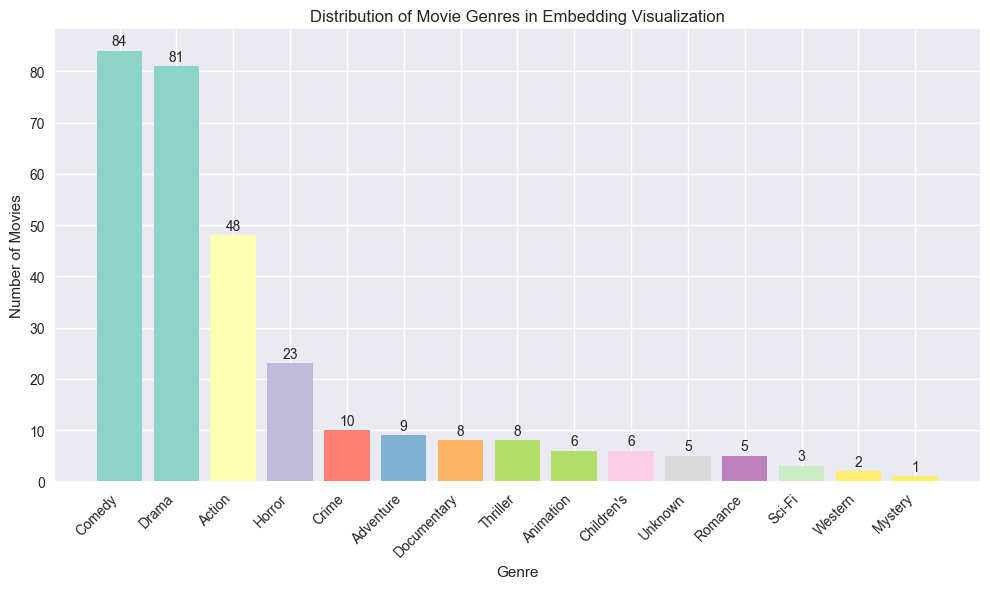

In [72]:
display_visualization_summary(tsne_result['visualization_results'], tsne_result['quality_report'])

In [73]:
pca_result = test_embedding_visualization_system(user_embeddings, item_embeddings, user_mapping, item_mapping, 'pca', movies_df)

🔄 Testing PCA visualization...

🎨 CREATING 2D EMBEDDING VISUALIZATION
   Method: PCA
   User embeddings shape: (6040, 4)
   Item embeddings shape: (3675, 4)
   Sample size for items: 300
   Visualizing 200 users and 300 items
   Combined embeddings shape: (500, 4)
   Applying PCA dimensionality reduction...
   ✅ 2D embeddings computed successfully
   User 2D embeddings shape: (200, 2)
   Item 2D embeddings shape: (300, 2)
🔄 Preparing visualization data...
   ✅ Prepared 200 user points and 300 item points
   Found 18 unique genres
🎨 Creating interactive plots...
   ✅ Created 3 interactive plots
📊 Creating static plots...
   ✅ Created 2 static plots
🔍 Analyzing embedding clusters...
   ✅ Found 10 optimal movie clusters
   Silhouette score: 0.353

📋 CREATING EMBEDDING QUALITY REPORT
✅ Embedding quality report generated


🎨 2D EMBEDDING VISUALIZATION SUMMARY
📊 Method: PCA
📏 Original Dimensions: 4D → 2D
👥 Users Visualized: 200
🎬 Movies Visualized: 300
🎭 Unique Genres: 18

🔍 Clustering Analysis:
   Optimal Clusters: 10
   Silhouette Score: 0.353
   Quality: Good

📈 Embedding Spread:
   User Spread (X): 1.053
   User Spread (Y): 1.050
   Item Spread (X): 1.045
   Item Spread (Y): 0.993

🎭 Genre Separation Analysis:
   Average Separation Ratio: 0.96
   (Higher values indicate better genre separation)

✅ 2D embedding visualization completed successfully!
   Interactive plots: 3
   Static plots: 2


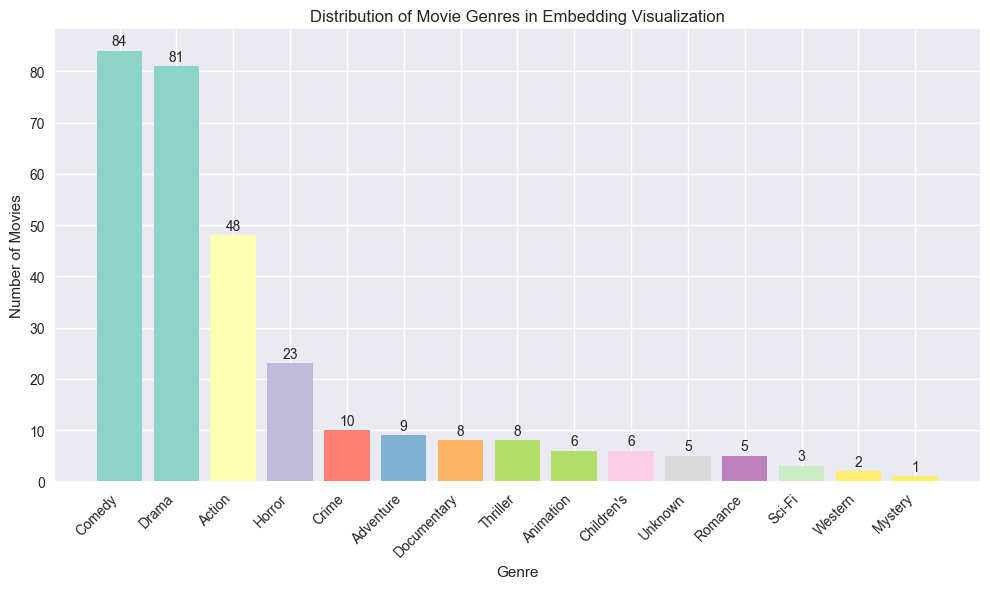

In [74]:
display_visualization_summary(pca_result['visualization_results'], pca_result['quality_report'])

### Implementation Notes (Embedding Visualization)

- **What is being visualized**: This section visualizes the learned **latent factors** from the Surprise SVD model (`pu` for users and `qi` for items). These vectors are *model parameters* learned to explain observed ratings.

- **Standardization step**: Before applying PCA/t-SNE, embeddings are standardized (zero mean / unit variance) so that the 2D projection is not dominated by a single latent dimension.

- **Sampling for speed and readability**: We visualize a subset of users/items (e.g., 200 users, 300–500 items) because projecting thousands of points can be slow (especially for t-SNE) and visually cluttered.

- **PCA vs t-SNE**:
  - **PCA** is fast and preserves global linear structure, but may not separate nonlinear patterns.
  - **t-SNE** can reveal local neighborhoods/clusters but is slower and sensitive to hyperparameters (perplexity, iterations, random seed).

- **Coloring by genre**: Movies are colored by their primary genre (derived from `GenresList` / `Genres`) to provide an intuitive sanity check: if the embedding captures meaningful structure, some genres may form loose regions (not guaranteed).

- **Interpretation caveat**: 2D projections can be misleading. Apparent clusters may be artifacts of the projection method rather than true high-dimensional separation. Use these plots as *diagnostics*, not proof of causal structure.


_____

## **7. User-Based Collaborative Filtering**

User-based collaborative filtering (User-CF) recommends items to a user by leveraging the preferences of **similar users**. The core idea is that if users have similar rating patterns in the past, they are likely to agree in the future.

### Similarity between users

Let $r_{ui}$ be the rating that user $u$ gave item $i$. Define a similarity score $s(u, v)$ between two users $u$ and $v$ based on their rating vectors.

Common choices:

- **Cosine similarity** (used in this notebook for efficiency):

$$s(u, v) = \frac{\sum_i r_{ui} r_{vi}}{\sqrt{\sum_i r_{ui}^2}\,\sqrt{\sum_i r_{vi}^2}}$$

- **Pearson correlation** (more robust to different user rating scales):

$$s(u, v) = \frac{\sum_{i \in I_{uv}} (r_{ui}-\bar r_u)(r_{vi}-\bar r_v)}{\sqrt{\sum_{i \in I_{uv}} (r_{ui}-\bar r_u)^2}\,\sqrt{\sum_{i \in I_{uv}} (r_{vi}-\bar r_v)^2}}$$

where $I_{uv}$ is the set of co-rated items and $\bar r_u$ is user $u$'s mean rating.

### Rating prediction and recommendation

Once we have neighbors $N_k(u)$ (top-$k$ similar users), we can estimate a rating for a candidate item $i$ by aggregating neighbors’ ratings.

A common weighted-average form is:

$$\hat r_{ui} = \frac{\sum_{v \in N_k(u)} s(u,v)\, r_{vi}}{\sum_{v \in N_k(u)} |s(u,v)|}$$

We then recommend items with the highest predicted $\hat r_{ui}$, typically excluding items already rated by user $u$.

### Practical considerations

- **Overlap requirement**: similarity is meaningful only when users share enough co-rated items.

- **Popularity bias**: naive aggregation tends to recommend popular items.

- **Scalability**: full user-user similarity is $O(|U|^2)$, so we often subsample users or approximate neighbors.

In [84]:
def compute_user_similarity_matrix_efficient(user_item_matrix, similarity_method='pearson',
                                           min_common_items=5, max_users=500, use_sparse=True,
                                           include_user_ids=None, random_state=42):
    """
    Efficient computation of user-user similarity matrix.

    Supports:
    - cosine similarity (fast; can be sparse)
    - pearson correlation (computed with overlap-aware NaN masking)

    Args:
        user_item_matrix (pd.DataFrame): User-item rating matrix
        similarity_method (str): 'pearson' or 'cosine'
        min_common_items (int): Minimum number of common items required
        max_users (int): Maximum number of users to consider
        use_sparse (bool): Whether to use sparse operations (cosine)
        include_user_ids (list): UserIDs that must be included in the sampled subset
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: (similarity_matrix, user_mapping, reverse_mapping)
    """
    print(f"🚀 Computing user similarity matrix efficiently using {similarity_method}...")

    if user_item_matrix is None or len(user_item_matrix) == 0:
        print("❌ Empty user-item matrix")
        return None, None, None

    # Force-include specific users
    if include_user_ids is not None and len(include_user_ids) > 0:
        include_user_ids = [int(u) for u in include_user_ids if int(u) in user_item_matrix.index]
    else:
        include_user_ids = []

    # Sample users if dataset is too large (keep most active, include samples)
    if user_item_matrix.shape[0] > max_users:
        print(f"   Sampling {max_users} users from {user_item_matrix.shape[0]} total users")

        user_activity = (user_item_matrix > 0).sum(axis=1)
        ordered_users = user_activity.sort_values(ascending=False).index.tolist()

        kept = []
        seen = set()

        for u in include_user_ids:
            if u not in seen:
                kept.append(u)
                seen.add(u)

        for u in ordered_users:
            if len(kept) >= max_users:
                break
            if u not in seen:
                kept.append(u)
                seen.add(u)

        user_item_matrix = user_item_matrix.loc[kept]

    print(f"   Final user subset: {user_item_matrix.shape[0]} users")
    print(f"   Matrix values dtype: {user_item_matrix.values.dtype}")

    try:
        user_ids = user_item_matrix.index.tolist()
        user_mapping = {user_id: idx for idx, user_id in enumerate(user_ids)}
        reverse_mapping = {idx: user_id for user_id, idx in user_mapping.items()}

        if similarity_method == 'cosine':
            if use_sparse:
                print("   Using sklearn cosine similarity...")
                matrix_values = user_item_matrix.values.astype(np.float64)
                sparse_matrix = csr_matrix(matrix_values)
                similarity_matrix = cosine_similarity(sparse_matrix)

                print("   Applying minimum common items filter (vectorized)...")
                binary_matrix = (user_item_matrix.values > 0).astype(int)
                common_items_matrix = np.dot(binary_matrix, binary_matrix.T)
                mask = common_items_matrix < min_common_items
                similarity_matrix[mask] = 0.0
                np.fill_diagonal(similarity_matrix, 1.0)

            else:
                # dense cosine
                similarity_matrix = cosine_similarity(user_item_matrix.values.astype(np.float64))
                np.fill_diagonal(similarity_matrix, 1.0)

        elif similarity_method == 'pearson':
            # Overlap-aware Pearson: treat unrated (0) as missing
            print("   Computing Pearson correlation with NaN-masked overlap...")
            mat = user_item_matrix.replace(0, np.nan)

            # corr between users => corr of rows; easiest via transpose
            sim_df = mat.T.corr(method='pearson', min_periods=min_common_items)
            similarity_matrix = sim_df.fillna(0.0).values.astype(np.float64)
            np.fill_diagonal(similarity_matrix, 1.0)

        else:
            raise ValueError(f"Unsupported similarity_method: {similarity_method}")

        print(f"   ✅ Similarity matrix computed: {similarity_matrix.shape}")
        non_diagonal = similarity_matrix[~np.eye(similarity_matrix.shape[0], dtype=bool)]
        non_zero = non_diagonal[non_diagonal != 0]
        print(f"   Non-zero similarities: {len(non_zero):,} / {len(non_diagonal):,}")
        if len(non_zero) > 0:
            print(f"   Similarity range: [{non_zero.min():.3f}, {non_zero.max():.3f}]")
            print(f"   Mean similarity: {non_zero.mean():.4f}")

        return similarity_matrix, user_mapping, reverse_mapping

    except Exception as e:
        print(f"❌ Error computing similarity matrix: {e}")
        return None, None, None


In [76]:
def find_similar_users(target_user_id, similarity_matrix, user_mapping, reverse_mapping, 
                      k=20, min_similarity=0.1):
    """
    Find K most similar users to the target user
    
    Args:
        target_user_id (int): ID of the target user
        similarity_matrix (np.ndarray): User-user similarity matrix
        user_mapping (dict): Mapping from user ID to matrix index
        reverse_mapping (dict): Mapping from matrix index to user ID
        k (int): Number of similar users to find
        min_similarity (float): Minimum similarity threshold
    
    Returns:
        list: List of tuples (user_id, similarity_score)
    """
    try:
        if target_user_id not in user_mapping:
            print(f"❌ User {target_user_id} not found in similarity matrix")
            return []
        
        target_idx = user_mapping[target_user_id]
        user_similarities = similarity_matrix[target_idx]
        
        # Get indices of users sorted by similarity (excluding the target user)
        similar_indices = np.argsort(user_similarities)[::-1]
        
        similar_users = []
        for idx in similar_indices:
            if idx != target_idx:  # Exclude the target user
                similarity_score = user_similarities[idx]
                if similarity_score >= min_similarity:
                    user_id = reverse_mapping[idx]
                    similar_users.append((user_id, similarity_score))
                    
                    if len(similar_users) >= k:
                        break
        
        return similar_users
        
    except Exception as e:
        print(f"❌ Error finding similar users: {e}")
        return []

In [77]:
def aggregate_ratings_from_similar_users(target_user_id, item_id, similar_users, 
                                       user_item_matrix, aggregation_method='weighted_average',
                                       confidence_threshold=0.5):
    """
    Aggregate ratings from similar users for a specific item
    
    Args:
        target_user_id (int): ID of the target user
        item_id (int): ID of the item to predict rating for
        similar_users (list): List of (user_id, similarity_score) tuples
        user_item_matrix (pd.DataFrame): User-item rating matrix
        aggregation_method (str): 'weighted_average', 'simple_average', or 'median'
        confidence_threshold (float): Minimum confidence score for prediction
    
    Returns:
        tuple: (predicted_rating, confidence_score, contributing_users)
    """
    try:
        if item_id not in user_item_matrix.columns:
            return None, 0.0, []
        
        contributing_ratings = []
        contributing_users = []
        total_similarity = 0.0
        
        # Collect ratings from similar users who have rated this item
        for user_id, similarity_score in similar_users:
            if user_id in user_item_matrix.index:
                rating = user_item_matrix.loc[user_id, item_id]
                
                if rating > 0:  # User has rated this item
                    contributing_ratings.append((rating, similarity_score))
                    contributing_users.append((user_id, similarity_score, rating))
                    total_similarity += abs(similarity_score)
        
        if not contributing_ratings:
            return None, 0.0, []
        
        # Calculate predicted rating based on aggregation method
        if aggregation_method == 'weighted_average':
            if total_similarity > 0:
                weighted_sum = sum(rating * abs(similarity) for rating, similarity in contributing_ratings)
                predicted_rating = weighted_sum / total_similarity
            else:
                predicted_rating = np.mean([rating for rating, _ in contributing_ratings])
        
        elif aggregation_method == 'simple_average':
            predicted_rating = np.mean([rating for rating, _ in contributing_ratings])
        
        elif aggregation_method == 'median':
            predicted_rating = np.median([rating for rating, _ in contributing_ratings])
        
        else:
            raise ValueError(f"Unknown aggregation method: {aggregation_method}")
        
        # Calculate confidence score based on:
        # 1. Number of contributing users
        # 2. Average similarity of contributing users
        # 3. Agreement among contributing users (low variance)
        n_contributors = len(contributing_ratings)
        avg_similarity = np.mean([abs(sim) for _, sim in contributing_ratings])
        rating_variance = np.var([rating for rating, _ in contributing_ratings])
        
        # Normalize confidence components
        contributor_confidence = min(n_contributors / 10.0, 1.0)  # Max confidence at 10+ contributors
        similarity_confidence = avg_similarity  # Already in [0, 1] range
        agreement_confidence = max(0, 1 - (rating_variance / 4.0))  # Lower variance = higher confidence
        
        # Combined confidence score
        confidence_score = (contributor_confidence + similarity_confidence + agreement_confidence) / 3.0
        
        return predicted_rating, confidence_score, contributing_users
        
    except Exception as e:
        print(f"❌ Error aggregating ratings: {e}")
        return None, 0.0, []

In [78]:
def generate_user_based_recommendations(target_user_id, user_item_matrix, similarity_matrix, user_mapping, reverse_mapping,
                                      movies_df, k_users=20, top_n=10, min_similarity=0.1, min_confidence=0.3):
    """
    Generate recommendations for a user using user-based collaborative filtering
    
    Args:
        target_user_id (int): ID of the target user
        user_item_matrix (pd.DataFrame): User-item rating matrix
        similarity_matrix (np.ndarray): User-user similarity matrix
        user_mapping (dict): Mapping from user ID to matrix index
        reverse_mapping (dict): Mapping from matrix index to user ID
        movies_df (pd.DataFrame): Movies metadata
        k_users (int): Number of similar users to consider
        top_n (int): Number of recommendations to return
        min_similarity (float): Minimum similarity threshold
        min_confidence (float): Minimum confidence threshold for recommendations
    
    Returns:
        pd.DataFrame: Recommendations with predicted ratings and confidence scores
    """
    print(f"🎯 Generating user-based recommendations for user {target_user_id}...")

    try:
        # Find similar users
        similar_users = find_similar_users(
            target_user_id, similarity_matrix, user_mapping, reverse_mapping,
            k=k_users, min_similarity=min_similarity
        )

        if not similar_users:
            print(f"❌ No similar users found for user {target_user_id}")
            return pd.DataFrame()

        print(f"   Found {len(similar_users)} similar users")
        print(f"   Top 3 similar users: {similar_users[:3]}")

        # Get items that the target user hasn't rated
        if target_user_id in user_item_matrix.index:
            user_ratings = user_item_matrix.loc[target_user_id]
            unrated_items = user_ratings[user_ratings == 0].index.tolist()
        else:
            # New user - all items are unrated
            unrated_items = user_item_matrix.columns.tolist()

        print(f"   Predicting ratings for {len(unrated_items)} unrated items...")

        # Predict ratings for unrated items
        recommendations = []

        for item_id in unrated_items:
            predicted_rating, confidence_score, contributing_users = aggregate_ratings_from_similar_users(
                target_user_id, item_id, similar_users, user_item_matrix,
                aggregation_method='weighted_average',
                confidence_threshold=min_confidence
            )

            if predicted_rating is not None and confidence_score >= min_confidence:
                recommendations.append({
                    'MovieID': item_id,
                    'PredictedRating': predicted_rating,
                    'ConfidenceScore': confidence_score,
                    'ContributingUsers': len(contributing_users),
                    'AvgSimilarity': np.mean([sim for _, sim, _ in contributing_users]) if contributing_users else 0
                })

        if not recommendations:
            print(f"❌ No recommendations meet confidence threshold ({min_confidence})")
            return pd.DataFrame()

        # Convert to DataFrame and sort by predicted rating and confidence
        recommendations_df = pd.DataFrame(recommendations)

        # Add movie information (align with movies_df schema used elsewhere in notebook)
        if movies_df is not None:
            if 'GenresList' in movies_df.columns:
                recommendations_df = recommendations_df.merge(
                    movies_df[['MovieID', 'Title', 'GenresList', 'Year']].rename(columns={'GenresList': 'Genres'}),
                    on='MovieID',
                    how='left'
                )
            elif 'Genres' in movies_df.columns:
                recommendations_df = recommendations_df.merge(
                    movies_df[['MovieID', 'Title', 'Genres', 'Year']],
                    on='MovieID',
                    how='left'
                )
            else:
                recommendations_df = recommendations_df.merge(
                    movies_df[['MovieID', 'Title', 'Year']],
                    on='MovieID',
                    how='left'
                )

        recommendations_df = recommendations_df.sort_values(
            ['PredictedRating', 'ConfidenceScore'],
            ascending=[False, False]
        ).head(top_n)

        print(f"   ✅ Generated {len(recommendations_df)} recommendations")
        return recommendations_df

    except Exception as e:
        print(f"❌ Error generating user-based recommendations: {e}")
        return pd.DataFrame()


In [79]:
def collect_interactive_ratings(movies_df, n_movies=10, rating_scale=(1, 5)):
    """
    Collect ratings from a new user interactively
    
    Args:
        movies_df (pd.DataFrame): Movies metadata
        n_movies (int): Number of movies to present for rating
        rating_scale (tuple): Valid rating range
    
    Returns:
        dict: Dictionary of {movie_id: rating} pairs
    """
    print("🎬 INTERACTIVE RATING COLLECTION FOR NEW USER")
    print("=" * 50)
    print(f"Please rate {n_movies} movies on a scale of {rating_scale[0]}-{rating_scale[1]}")
    print("Enter 0 to skip a movie, or 'q' to quit early")
    print()
    
    try:
        # Select popular movies (those with most ratings) for rating collection
        if 'Rating_Count' in movies_df.columns:
            popular_movies = movies_df.nlargest(n_movies * 2, 'Rating_Count')
        else:
            # Fallback: select random movies
            popular_movies = movies_df.sample(n=min(n_movies * 2, len(movies_df)))
        
        # Select diverse genres if possible
        selected_movies = popular_movies.head(n_movies)
        
        user_ratings = {}
        
        for idx, (_, movie) in enumerate(selected_movies.iterrows(), 1):
            movie_id = movie['MovieID']
            title = movie.get('Title', f'Movie {movie_id}')
            genres = movie.get('Genres', 'Unknown')
            year = movie.get('Year', 'Unknown')
            
            print(f"{idx}. {title} ({year})")
            print(f"   Genres: {genres}")
            
            while True:
                try:
                    rating_input = input(f"   Your rating ({rating_scale[0]}-{rating_scale[1]}, 0 to skip, 'q' to quit): ").strip()
                    
                    if rating_input.lower() == 'q':
                        print("Rating collection stopped by user.")
                        return user_ratings
                    
                    rating = float(rating_input)
                    
                    if rating == 0:
                        print("   Skipped.")
                        break
                    elif rating_scale[0] <= rating <= rating_scale[1]:
                        user_ratings[movie_id] = rating
                        print(f"   Rated: {rating}")
                        break
                    else:
                        print(f"   Please enter a rating between {rating_scale[0]} and {rating_scale[1]}")
                
                except ValueError:
                    print("   Please enter a valid number")
                except KeyboardInterrupt:
                    print("\nRating collection interrupted.")
                    return user_ratings
            
            print()
        
        print(f"✅ Collected {len(user_ratings)} ratings from new user")
        return user_ratings
        
    except Exception as e:
        print(f"❌ Error collecting interactive ratings: {e}")
        return {}

In [80]:
def handle_new_user_recommendations(new_user_ratings, user_item_matrix, similarity_matrix,
                                  user_mapping, reverse_mapping, movies_df,
                                  k_users=20, top_n=10, min_similarity=0.1):
    """
    Generate recommendations for a new user based on their provided ratings
    
    Args:
        new_user_ratings (dict): Dictionary of {movie_id: rating} pairs
        user_item_matrix (pd.DataFrame): Existing user-item rating matrix
        similarity_matrix (np.ndarray): User-user similarity matrix
        user_mapping (dict): Mapping from user ID to matrix index
        reverse_mapping (dict): Mapping from matrix index to user ID
        movies_df (pd.DataFrame): Movies metadata
        k_users (int): Number of similar users to consider
        top_n (int): Number of recommendations to return
        min_similarity (float): Minimum similarity threshold
    
    Returns:
        pd.DataFrame: Recommendations for the new user
    """
    print("🆕 GENERATING RECOMMENDATIONS FOR NEW USER")
    print("=" * 50)
    
    try:
        if not new_user_ratings:
            print("❌ No ratings provided by new user")
            return pd.DataFrame()
        
        print(f"New user provided {len(new_user_ratings)} ratings")
        
        # Filter new user ratings to only include movies that exist in our matrix
        valid_new_user_ratings = {}
        for movie_id, rating in new_user_ratings.items():
            if movie_id in user_item_matrix.columns:
                valid_new_user_ratings[movie_id] = rating
        
        if not valid_new_user_ratings:
            print("❌ None of the new user's rated movies exist in the filtered dataset")
            return pd.DataFrame()
        
        print(f"Valid ratings in dataset: {len(valid_new_user_ratings)} out of {len(new_user_ratings)}")
        print(f"Valid rated movies: {list(valid_new_user_ratings.keys())}")
        
        # IMPORTANT: Only search through users that are in our similarity matrix
        # Use user_mapping.keys() instead of user_item_matrix.index
        available_users = list(user_mapping.keys())
        print(f"Searching through {len(available_users)} users in similarity matrix")
        
        # Find similar existing users based on the new user's valid ratings
        similar_users = []
        
        # Lower the minimum common movies threshold for better matching
        min_common_movies = min(2, len(valid_new_user_ratings))  # At least 2 or all available
        
        for existing_user_id in available_users:
            existing_user_ratings = user_item_matrix.loc[existing_user_id]
            
            # Find common rated movies
            common_movies = []
            new_user_common = []
            existing_user_common = []
            
            for movie_id, rating in valid_new_user_ratings.items():
                if existing_user_ratings[movie_id] > 0:
                    common_movies.append(movie_id)
                    new_user_common.append(rating)
                    existing_user_common.append(existing_user_ratings[movie_id])
            
            # Calculate similarity if enough common movies
            if len(common_movies) >= min_common_movies:
                try:
                    if len(set(new_user_common)) == 1 and len(set(existing_user_common)) == 1:
                        # Both users gave the same rating to all common movies
                        correlation = 1.0 if new_user_common[0] == existing_user_common[0] else 0.0
                    else:
                        correlation, _ = stats.pearsonr(new_user_common, existing_user_common)
                    
                    if not np.isnan(correlation) and correlation >= min_similarity:
                        similar_users.append((existing_user_id, correlation))
                except Exception as e:
                    continue
        
        # Sort by similarity and take top K
        similar_users.sort(key=lambda x: x[1], reverse=True)
        similar_users = similar_users[:k_users]
        
        if not similar_users:
            print(f"❌ No similar users found (tried {len(available_users)} users, min_similarity={min_similarity})")
            print("   Lowering similarity threshold and trying again...")
            
            # Try with lower similarity threshold and minimum requirements
            for existing_user_id in available_users:
                existing_user_ratings = user_item_matrix.loc[existing_user_id]
                
                common_movies = []
                new_user_common = []
                existing_user_common = []
                
                for movie_id, rating in valid_new_user_ratings.items():
                    if existing_user_ratings[movie_id] > 0:
                        common_movies.append(movie_id)
                        new_user_common.append(rating)
                        existing_user_common.append(existing_user_ratings[movie_id])
                
                # Lower requirements: at least 1 common movie
                if len(common_movies) >= 1:
                    try:
                        if len(common_movies) == 1:
                            # Single movie: similarity based on rating difference
                            rating_diff = abs(new_user_common[0] - existing_user_common[0])
                            correlation = max(0, 1 - (rating_diff / 4.0))  # Scale 0-1
                        else:
                            if len(set(new_user_common)) == 1 and len(set(existing_user_common)) == 1:
                                correlation = 1.0 if new_user_common[0] == existing_user_common[0] else 0.5
                            else:
                                correlation, _ = stats.pearsonr(new_user_common, existing_user_common)
                        
                        if not np.isnan(correlation) and correlation > 0.0:  # Accept any positive correlation
                            similar_users.append((existing_user_id, correlation))
                    except Exception as e:
                        continue
            
            similar_users.sort(key=lambda x: x[1], reverse=True)
            similar_users = similar_users[:k_users]
        
        if not similar_users:
            print("❌ Still no similar users found even with lowered threshold")
            print("   Generating fallback recommendations based on popular movies...")
            
            # Fallback: recommend popular movies from the sampled users
            movie_popularity = {}
            movie_ratings_sum = {}
            
            for user_id in available_users:
                user_ratings = user_item_matrix.loc[user_id]
                for movie_id in user_ratings.index:
                    if user_ratings[movie_id] > 0 and movie_id not in valid_new_user_ratings:
                        if movie_id not in movie_popularity:
                            movie_popularity[movie_id] = 0
                            movie_ratings_sum[movie_id] = 0
                        movie_popularity[movie_id] += 1
                        movie_ratings_sum[movie_id] += user_ratings[movie_id]
            
            # Sort by popularity and get top movies
            popular_movies = sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)[:top_n]
            
            recommendations = []
            for movie_id, count in popular_movies:
                avg_rating = movie_ratings_sum[movie_id] / count
                movie_info = movies_df[movies_df['MovieID'] == movie_id]
                
                if not movie_info.empty:
                    movie_data = movie_info.iloc[0]
                    recommendations.append({
                        'MovieID': movie_id,
                        'Title': movie_data['Title'],
                        'Genres': movie_data['Genres'],
                        'Year': movie_data.get('Year', 'Unknown'),
                        'PredictedRating': avg_rating,
                        'ConfidenceScore': min(count / 10.0, 1.0),  # Confidence based on popularity
                        'ContributingUsers': count,
                        'AvgSimilarity': 0.0,
                        'RecommendationType': 'Popular Fallback'
                    })
            
            if recommendations:
                print(f"✅ Generated {len(recommendations)} fallback recommendations")
                return pd.DataFrame(recommendations)
            else:
                return pd.DataFrame()
        
        print(f"Found {len(similar_users)} similar users")
        print(f"Top 3 similar users: {similar_users[:3]}")
        
        # Generate recommendations based on similar users' preferences
        recommendations = []
        
        # Get movies not rated by the new user (from available movies in matrix)
        unrated_movies = [movie_id for movie_id in user_item_matrix.columns 
                         if movie_id not in valid_new_user_ratings]
        
        print(f"Considering {len(unrated_movies)} unrated movies for recommendations...")
        
        for movie_id in unrated_movies:
            ratings_from_similar = []
            similarities_from_similar = []
            
            # Collect ratings from similar users
            for user_id, similarity in similar_users:
                rating = user_item_matrix.loc[user_id, movie_id]
                if rating > 0:
                    ratings_from_similar.append(rating)
                    similarities_from_similar.append(similarity)
            
            # Calculate weighted average rating if enough data
            if len(ratings_from_similar) >= 1:  # At least 1 similar user rated this movie
                total_similarity = sum(abs(sim) for sim in similarities_from_similar)
                if total_similarity > 0:
                    weighted_rating = sum(rating * abs(sim) for rating, sim in 
                                        zip(ratings_from_similar, similarities_from_similar)) / total_similarity
                    
                    # Calculate confidence based on number of raters and average similarity
                    confidence = min(len(ratings_from_similar) / 5.0, 1.0) * np.mean([abs(sim) for sim in similarities_from_similar])
                    
                    recommendations.append({
                        'MovieID': movie_id,
                        'PredictedRating': weighted_rating,
                        'ConfidenceScore': confidence,
                        'ContributingUsers': len(ratings_from_similar),
                        'AvgSimilarity': np.mean([abs(sim) for sim in similarities_from_similar])
                    })
        
        if not recommendations:
            print("❌ No recommendations could be generated")
            return pd.DataFrame()
        
        # Convert to DataFrame and add movie information
        recommendations_df = pd.DataFrame(recommendations)
        
        if movies_df is not None:
            recommendations_df = recommendations_df.merge(
                movies_df[['MovieID', 'Title', 'Genres', 'Year']], 
                on='MovieID', 
                how='left'
            )
        
        # Sort by predicted rating and confidence
        recommendations_df = recommendations_df.sort_values(
            ['PredictedRating', 'ConfidenceScore'], 
            ascending=[False, False]
        ).head(top_n)
        
        print(f"✅ Generated {len(recommendations_df)} recommendations for new user")
        
        return recommendations_df
        
    except Exception as e:
        print(f"❌ Error generating new user recommendations: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

In [81]:
# User-Based Collaborative Filtering Pipeline (restart-safe; uses shared experiment config)

USER_CF_CONFIG = {
    'similarity_method': 'pearson',
    'min_common_items': 3,
    'max_users': 500,
    'use_sparse': True,
    'k_users': 10,
    'top_n': 10,
    'min_similarity': 0.1,
    'min_confidence': 0.2,
    'random_state': RANDOM_STATE,
}

print("🧪 User-Based Collaborative Filtering Pipeline")
print("=" * 60)
display("USER_CF_CONFIG:", USER_CF_CONFIG)

🧪 User-Based Collaborative Filtering Pipeline


'USER_CF_CONFIG:'

{'similarity_method': 'pearson',
 'min_common_items': 3,
 'max_users': 500,
 'use_sparse': True,
 'k_users': 10,
 'top_n': 10,
 'min_similarity': 0.1,
 'min_confidence': 0.2,
 'random_state': 42}

In [82]:
# 1) Build user-item matrix (full; can be large)
user_item_matrix = df.pivot_table(
    index='UserID',
    columns='MovieID',
    values='Rating',
    fill_value=0
).astype(np.float64)

print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")

User-item matrix shape: (6040, 3706)
Sparsity: 95.53%


In [86]:
# 2) Similarity matrix over a deterministic subset that includes shared sample users
similarity_matrix, user_mapping, reverse_mapping = compute_user_similarity_matrix_efficient(
    user_item_matrix,
    similarity_method=USER_CF_CONFIG['similarity_method'],
    min_common_items=USER_CF_CONFIG['min_common_items'],
    max_users=USER_CF_CONFIG['max_users'],
    use_sparse=USER_CF_CONFIG['use_sparse'],
    include_user_ids=SAMPLE_USER_IDS,
    random_state=USER_CF_CONFIG['random_state']
)

if similarity_matrix is None:
    raise RuntimeError("Failed to compute user-user similarity matrix")

🚀 Computing user similarity matrix efficiently using pearson...
   Sampling 500 users from 6040 total users
   Final user subset: 500 users
   Matrix values dtype: float64
   Computing Pearson correlation with NaN-masked overlap...
   ✅ Similarity matrix computed: (500, 500)
   Non-zero similarities: 249,492 / 249,500
   Similarity range: [-1.000, 1.000]
   Mean similarity: 0.2428


In [87]:
# 3) Pick shared sample users that exist in the computed subset
sample_users = [int(u) for u in SAMPLE_USER_IDS if int(u) in user_mapping]
if len(sample_users) == 0:
    sample_users = list(user_mapping.keys())[:min(3, len(user_mapping))]

print("🧪 Shared sample users used in User-CF demo:")
print(sample_users)

🧪 Shared sample users used in User-CF demo:
[5530, 711, 4924, 2154, 1273]


In [88]:
# 4) Generate recommendations for sample users
user_cf_recommendations = {}
for uid in sample_users:
    recs = generate_user_based_recommendations(
        uid,
        user_item_matrix,
        similarity_matrix,
        user_mapping,
        reverse_mapping,
        movies_df,
        k_users=USER_CF_CONFIG['k_users'],
        top_n=USER_CF_CONFIG['top_n'],
        min_similarity=USER_CF_CONFIG['min_similarity'],
        min_confidence=USER_CF_CONFIG['min_confidence']
    )
    user_cf_recommendations[uid] = recs
    if recs is not None and len(recs) > 0:
        display(recs.head(10))
    else:
        print("❌ No recommendations generated")

🎯 Generating user-based recommendations for user 5530...
   Found 10 similar users
   Top 3 similar users: [(1141, 0.6201116017018252), (2288, 0.5893313097671639), (3201, 0.5635428333158349)]
   Predicting ratings for 3054 unrated items...
   ✅ Generated 10 recommendations


,MovieID,PredictedRating,ConfidenceScore,ContributingUsers,AvgSimilarity,Title,Genres,Year
368,965,5.0,0.617790,3,0.553369,"39 Steps, The",[Thriller],1935
359,942,5.0,0.597276,2,0.591827,Laura,"[Crime, Film-Noir, Mystery]",1944
1464,3599,5.0,0.597276,2,0.591827,Anchors Aweigh,"[Comedy, Musical]",1945
1568,3873,5.0,0.597276,2,0.591827,Cat Ballou,"[Comedy, Western]",1965
542,1340,5.0,0.592146,2,0.576437,Bride of Frankenstein,[Horror],1935
341,911,5.0,0.587891,2,0.563672,Charade,"[Comedy, Mystery, Romance, Thriller]",1963
1217,2971,5.0,0.584804,2,0.554411,All That Jazz,[Musical],1979
489,1237,5.0,0.582761,2,0.548282,"Seventh Seal, The (Sjunde inseglet, Det)",[Drama],1957
502,1260,5.0,0.582761,2,0.548282,M,"[Crime, Film-Noir, Thriller]",1931
767,1945,5.0,0.582761,2,0.548282,On the Waterfront,"[Crime, Drama]",1954


🎯 Generating user-based recommendations for user 711...
   Found 10 similar users
   Top 3 similar users: [(1068, 0.46206900310452853), (2154, 0.44574249416020906), (3280, 0.44374158018611126)]
   Predicting ratings for 3563 unrated items...
   ✅ Generated 10 recommendations


,MovieID,PredictedRating,ConfidenceScore,ContributingUsers,AvgSimilarity,Title,Genres,Year
312,562,5.0,0.549813,2,0.449439,Welcome to the Dollhouse,"[Comedy, Drama]",1995
490,1035,5.0,0.549813,2,0.449439,"Sound of Music, The",[Musical],1965
554,1207,5.0,0.549813,2,0.449439,To Kill a Mockingbird,[Drama],1962
1147,2398,5.0,0.549813,2,0.449439,Miracle on 34th Street,[Drama],1947
1589,3330,5.0,0.549813,2,0.449439,Splendor in the Grass,[Drama],1961
1645,3469,5.0,0.549813,2,0.449439,Inherit the Wind,[Drama],1960
1707,3604,5.0,0.549813,2,0.449439,Gypsy,[Musical],1962
428,899,5.0,0.547918,2,0.443755,Singin' in the Rain,"[Musical, Romance]",1952
438,915,5.0,0.547918,2,0.443755,Sabrina,"[Comedy, Romance]",1954
727,1537,5.0,0.546271,2,0.438813,Shall We Dance? (Shall We Dansu?),[Comedy],1996


🎯 Generating user-based recommendations for user 4924...
   Found 10 similar users
   Top 3 similar users: [(1675, 1.0000000000000002), (1496, 1.0), (2154, 0.7840923153642579)]
   Predicting ratings for 3665 unrated items...
   ✅ Generated 10 recommendations


,MovieID,PredictedRating,ConfidenceScore,ContributingUsers,AvgSimilarity,Title,Genres,Year
127,246,5.0,0.625388,3,0.576164,Hoop Dreams,[Documentary],1994
630,1306,5.0,0.700000,1,1.000000,Until the End of the World (Bis ans Ende der W...,"[Drama, Sci-Fi]",1991
1358,2664,5.0,0.700000,1,1.000000,Invasion of the Body Snatchers,"[Horror, Sci-Fi]",1956
1435,2800,5.0,0.700000,1,1.000000,Little Nemo: Adventures in Slumberland,"[Animation, Children's]",1992
1463,2853,5.0,0.700000,1,1.000000,"Communion (a.k.a. Alice, Sweet Alice/Holy Terror)",[Horror],1977
1719,3404,5.0,0.700000,1,1.000000,Titanic,"[Action, Drama]",1953
567,1218,5.0,0.700000,1,1.000000,"Killer, The (Die xue shuang xiong)","[Action, Thriller]",1989
572,1223,5.0,0.628031,1,0.784092,"Grand Day Out, A","[Animation, Comedy]",1992
279,534,5.0,0.594377,1,0.683130,Shadowlands,"[Drama, Romance]",1993
573,1224,5.0,0.594377,1,0.683130,Henry V,"[Drama, War]",1989


🎯 Generating user-based recommendations for user 2154...
   Found 10 similar users
   Top 3 similar users: [(4924, 0.7840923153642579), (1260, 0.739940073395944), (2453, 0.6935847514439165)]
   Predicting ratings for 3661 unrated items...
   ✅ Generated 10 recommendations


,MovieID,PredictedRating,ConfidenceScore,ContributingUsers,AvgSimilarity,Title,Genres,Year
622,1249,5.0,0.699110,4,0.697330,Nikita (La Femme Nikita),[Thriller],1990
611,1231,5.0,0.683162,4,0.649486,"Right Stuff, The",[Drama],1983
409,745,5.0,0.666193,3,0.698579,"Close Shave, A","[Animation, Comedy, Thriller]",1995
1823,3512,5.0,0.642069,3,0.626207,Return to Me,"[Drama, Romance]",2000
462,904,5.0,0.638810,2,0.716430,Rear Window,"[Mystery, Thriller]",1954
596,1207,5.0,0.638810,2,0.716430,To Kill a Mockingbird,[Drama],1962
559,1096,5.0,0.631084,2,0.693253,Sophie's Choice,[Drama],1982
1213,2357,5.0,0.631084,2,0.693253,Central Station (Central do Brasil),[Drama],1998
746,1449,5.0,0.628478,2,0.685433,Waiting for Guffman,[Comedy],1996
362,598,5.0,0.628031,1,0.784092,Window to Paris,[Comedy],1994


🎯 Generating user-based recommendations for user 1273...
   Found 10 similar users
   Top 3 similar users: [(4161, 0.5897068185405367), (2010, 0.5166666261335217), (1194, 0.48957349018588325)]
   Predicting ratings for 3372 unrated items...
   ✅ Generated 10 recommendations


,MovieID,PredictedRating,ConfidenceScore,ContributingUsers,AvgSimilarity,Title,Genres,Year
918,2022,5.0,0.549678,2,0.449034,"Last Temptation of Christ, The",[Drama],1988
1398,3000,5.0,0.549678,2,0.449034,"Princess Mononoke, The (Mononoke Hime)","[Action, Adventure, Animation]",1997
841,1889,5.0,0.514212,1,0.442637,Insomnia,[Thriller],1997
1263,2687,5.0,0.514212,1,0.442637,Tarzan,"[Animation, Children's]",1999
555,1248,5.0,0.631173,4,0.493518,Touch of Evil,"[Crime, Film-Noir, Thriller]",1958
1478,3182,5.0,0.602435,3,0.507306,Mr. Death: The Rise and Fall of Fred A. Leucht...,[Documentary],1999
1586,3462,5.0,0.581442,3,0.444325,Modern Times,[Comedy],1936
1288,2726,5.0,0.574190,2,0.522569,"Killing, The","[Crime, Film-Noir]",1956
168,320,5.0,0.563236,1,0.589707,Suture,"[Film-Noir, Thriller]",1993
1432,3090,5.0,0.563236,1,0.589707,Matewan,[Drama],1987


In [89]:
# 5) Predict ratings for shared sample (user, item) pairs where possible
print("🔮 User-CF rating prediction on shared sample user/item pairs")
rng_local = np.random.default_rng(USER_CF_CONFIG['random_state'])

sample_items = [int(i) for i in SAMPLE_ITEM_IDS if int(i) in user_item_matrix.columns]
if len(sample_items) == 0:
    sample_items = rng_local.choice(user_item_matrix.columns.values, size=min(3, len(user_item_matrix.columns)), replace=False).tolist()

for uid in sample_users[:min(3, len(sample_users))]:
    # Get similar users once per uid
    sim_users = find_similar_users(
        uid,
        similarity_matrix,
        user_mapping,
        reverse_mapping,
        k=USER_CF_CONFIG['k_users'],
        min_similarity=USER_CF_CONFIG['min_similarity']
    )

    for mid in sample_items[:min(3, len(sample_items))]:
        pred, conf, contributors = aggregate_ratings_from_similar_users(
            uid,
            int(mid),
            sim_users,
            user_item_matrix,
            aggregation_method='weighted_average',
            confidence_threshold=0.0
        )
        actual = float(user_item_matrix.loc[uid, int(mid)]) if (uid in user_item_matrix.index and int(mid) in user_item_matrix.columns) else 0.0
        actual_str = f"{actual:.1f}" if actual > 0 else "(unrated)"
        if pred is None:
            print(f"user={uid}, movie={mid}: pred=None, actual={actual_str}")
        else:
            print(f"user={uid}, movie={mid}: pred={pred:.3f}, conf={conf:.3f}, contributors={len(contributors)}, actual={actual_str}")

# 6) Package outputs
user_cf_results = {
    'user_item_matrix': user_item_matrix,
    'similarity_matrix': similarity_matrix,
    'user_mapping': user_mapping,
    'reverse_mapping': reverse_mapping,
    'recommendations': user_cf_recommendations,
    'config': USER_CF_CONFIG
}

🔮 User-CF rating prediction on shared sample user/item pairs
user=5530, movie=2618: pred=None, actual=(unrated)
user=5530, movie=3633: pred=2.349, conf=0.588, contributors=3, actual=(unrated)
user=5530, movie=3811: pred=None, actual=(unrated)
user=711, movie=2618: pred=None, actual=(unrated)
user=711, movie=3633: pred=4.000, conf=0.507, contributors=1, actual=(unrated)
user=711, movie=3811: pred=4.000, conf=0.508, contributors=1, actual=(unrated)
user=4924, movie=2618: pred=None, actual=(unrated)
user=4924, movie=3633: pred=4.000, conf=0.556, contributors=1, actual=(unrated)
user=4924, movie=3811: pred=3.000, conf=0.560, contributors=1, actual=(unrated)


### Implementation Notes (User-Based Collaborative Filtering)

- **Why we keep an “efficient” similarity function**: full user-user similarity is $O(|U|^2)$. Even for a few thousand users, computing all pairwise overlaps and correlations can become slow. In this notebook we compute similarities on a bounded subset (e.g., `max_users=500`) for interactive experimentation.

- **Shared sampling / reproducibility**: the similarity subset is selected deterministically and is forced to **include the global `SAMPLE_USER_IDS`**, so that demos and diagnostics remain consistent across algorithms.

- **Cosine similarity on raw ratings is usually positive**: ratings are non-negative (1–5), so cosine similarity tends to be $>0$ for most user pairs once they share a few co-rated items. This can produce a *very dense* similarity matrix and makes “nearest neighbors” less discriminative.

- **Overlap filtering**: we apply a minimum overlap (`min_common_items`) via a co-rated count matrix. If `min_common_items` is too small, almost every pair passes and density approaches 100%.

- **How to make neighbors more meaningful**:
  - Increase `min_common_items` (e.g., 10–30).
  - Use **Pearson correlation** or mean-center ratings before cosine (reduces scale/popularity effects).
  - Add **shrinkage / significance weighting** so small overlaps don’t create strong similarities.
  - Keep only the **top-k** neighbors per user (sparsify the similarity graph).

- **Recommendation runtime**: generating recommendations by iterating over *all* unrated items can be expensive (thousands of items). Practical speedups include:
  - Candidate pruning: score only items rated by the neighbor set, or only the most popular items.
  - Vectorization / sparse operations for aggregation.

- **What to evaluate next (consistent with earlier sections)**: create a held-out set of rated (user, item) pairs for users in the similarity subset and report RMSE/MAE, then generate recommendations for the shared `SAMPLE_USER_IDS`.


_____

## **8. Conclusion: What We Learned Across Approaches**

We implemented and tested multiple recommenders on the same movie ratings data:

- **Item-based collaborative filtering (Pearson correlation)**

- **Item-based KNN with cosine similarity (baseline-corrected neighborhood model)**

- **Matrix factorization (Surprise SVD)**

- **User-based collaborative filtering**

Below are the key takeaways from running these methods side-by-side.

### A. Predictive accuracy vs. interpretability is a real tradeoff

- **Neighborhood models (item-item / user-user)** provide *local, human-explainable* reasoning: “we recommend this because it is similar to items you rated” or “similar users liked it.”

- **Matrix factorization (SVD)** provides a *compact global representation* that typically generalizes well, but latent factors are not directly interpretable.

In practice, we used neighborhood methods as a **diagnostic and explainable baseline**, and SVD as a **strong global baseline for rating prediction**.

### B. Metrics are only comparable when the evaluation protocol is the same

In this notebook, different sections used different evaluation regimes:

- The **KNN held-out evaluation** reported (on a small held-out set of 8 pairs):
  - **RMSE:** 0.7535
  - **MAE:** 0.6547
  - with relatively low confidence values (reflecting sparse or weak neighbor signal).

- The **SVD evaluation** reported (on a much larger Surprise split):
  - **RMSE:** 0.9129
  - **MAE:** 0.7235

These numbers are informative within each section, but they are **not strictly apples-to-apples** because the test sets (size and construction) differ. The most important lesson: **a shared, identical held-out protocol is required to rank models fairly.**

### C. Baseline correction and overlap constraints matter more than the similarity function alone

Across neighborhood approaches, the most impactful “quality” levers were:

- **Mean-centering / baselines** (reduces popularity bias and scale effects)

- **Minimum overlap** constraints (avoid spurious similarities from tiny intersections)

- **Shrinkage / significance weighting** (downweights unreliable similarities)

This is why the refactored KNN pipeline focused on baseline correction and overlap filtering rather than building a larger similarity matrix.

### D. User-based cosine similarity can become too dense on non-negative ratings

In the User-CF pipeline we observed that, with cosine similarity on raw ratings and a small overlap threshold, the similarity matrix can become nearly fully non-zero. This teaches two practical points:

- **Cosine on non-negative ratings often yields broadly positive similarity**, which can reduce neighbor selectivity.

- For User-CF, you often need stronger constraints (higher `min_common_items`, mean-centering, or Pearson correlation) to get meaningful “nearest neighbors.”

### E. Embeddings are useful for diagnostics, not as a primary recommender by themselves

The embedding-visualization section shows how latent factors can be projected into 2D (PCA/t-SNE) to sanity-check structure. The key takeaway is that these projections are **diagnostic**: they can hint at clustering or collapse, but they do not replace rating-based evaluation.

### Recommended next steps (to make the comparison definitive)

- **Standardize evaluation**: create one consistent held-out set of rated (user, item) pairs and evaluate *all* models on it (RMSE/MAE + coverage).

- **Standardize recommendation evaluation**: report hit-rate/precision@K on a top-N protocol (leave-one-out per user, or time-based split).

- **Hybrid strategy**:
  - Use **SVD** to generate candidate items efficiently.
  - Re-rank with an **interpretable neighborhood score** or business rules.

- **Production concerns**: cache/sparsify similarities, restrict candidate sets, and measure latency/memory.

Overall, the strongest lesson is that the best recommender is not “one algorithm” but a **carefully evaluated and well-engineered pipeline** with consistent data splits, robust similarity estimation, and clear tradeoffs between accuracy, explainability, and scalability.